In [1]:
import scanpy as sc
import scanpy.external as sce
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import numpy as np
import Bio.SeqIO as SeqIO
import sys
from tqdm import tqdm
import re
import scipy.stats as stats
from pygenomeviz import GenomeViz
from scipy.stats import ttest_rel
from scipy.stats import pearsonr
from matplotlib.lines import Line2D
import seaborn as sns
import os
from scipy.stats import ttest_rel
import warnings
warnings.filterwarnings("ignore")
import math
sys.path.append('/Users/giacomo.glotzer/Desktop/Rockefeller/Kronauer/analysis')
from transcriptomics import *
from hcr import *
from primers import * 
from plotting import * 
black_plotting()

Initializing transcriptomics package
Initializing HCR package
Initializing custom primer package
Initializing plotting package


In [2]:
sc.set_figure_params(dpi=100, color_map="viridis_r")
sc.settings.verbosity = 0 
sc.logging.print_header()

scanpy==1.10.1 anndata==0.10.7 umap==0.5.5 numpy==1.26.4 scipy==1.13.0 pandas==2.2.1 scikit-learn==1.4.2 statsmodels==0.14.1 igraph==0.11.4 pynndescent==0.5.12


In [3]:
# set pd max columns to 100 and max rows to 10 
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 10)

## Genome

In [4]:
# Load genome
genome_fasta_path = '/Users/giacomo.glotzer/Desktop/Rockefeller/Kronauer/scRNAseq/AMellifera/genome/GCF_003254395.2_Amel_HAv3.1_genomic.fna'
genome_seq = SeqIO.to_dict(SeqIO.parse(genome_fasta_path, "fasta"))

In [5]:
# Get number of scaffolds 
scaffolds = list(genome_seq.keys())
print(f'Number of scaffolds: {len(scaffolds)}')

# Make a dictionary of scaffold lengths
scaffold_lengths = {scaffold:len(genome_seq[scaffold].seq) for scaffold in scaffolds}
scaffold_lengths = pd.DataFrame.from_dict(scaffold_lengths, orient='index', columns=['length'])
scaffold_lengths = scaffold_lengths.sort_values(by='length', ascending=False)
scaffold_lengths

Number of scaffolds: 177


length
NC_037638.1     27754200
NC_037643.1     17789102
NC_037648.1     16352600
NC_037639.1     16089512
NC_037644.1     14198698
...                  ...
NW_020555856.1      3152
NW_020555857.1      3072
NW_020555858.1      2987
NW_020555946.1      2376
NW_020555947.1      2302

[177 rows x 1 columns]

## Custom OR Transcriptome
- Gene uses `gene_id` and transcript uses `transcript_id`
- Only run this once

In [6]:
"""genome_fasta_path = '/Users/giacomo.glotzer/Desktop/Rockefeller/Kronauer/scRNAseq/AMellifera/genome/GCF_003254395.2_Amel_HAv3.1_genomic.fna'
transcriptome_path = "/Users/giacomo.glotzer/Desktop/Rockefeller/Kronauer/scRNAseq/AMellifera/transcriptome/Amel_HAv31_ncbi.gtf"
object_name = "/Users/giacomo.glotzer/Desktop/Rockefeller/Kronauer/scRNAseq/AMellifera/transcriptome/amellifera_transcriptome"
update_transcriptome_object(genome_fasta_path, transcriptome_path, object_name, save_biotype=True)"""

'genome_fasta_path = \'/Users/giacomo.glotzer/Desktop/Rockefeller/Kronauer/scRNAseq/AMellifera/genome/GCF_003254395.2_Amel_HAv3.1_genomic.fna\'\ntranscriptome_path = "/Users/giacomo.glotzer/Desktop/Rockefeller/Kronauer/scRNAseq/AMellifera/transcriptome/Amel_HAv31_ncbi.gtf"\nobject_name = "/Users/giacomo.glotzer/Desktop/Rockefeller/Kronauer/scRNAseq/AMellifera/transcriptome/amellifera_transcriptome"\nupdate_transcriptome_object(genome_fasta_path, transcriptome_path, object_name, save_biotype=True)'

In [7]:
object_name = "/Users/giacomo.glotzer/Desktop/Rockefeller/Kronauer/scRNAseq/AMellifera/transcriptome/amellifera_transcriptome"
tr = load_transcriptome_object(object_name)

In [8]:
check_exons_contain_all_features(tr)

## OR DB
- Blastn revealed that "Or2" is Apis Mellifera ortholog of Orco 

In [10]:
all_genes = list(tr.genes.keys())

In [11]:
ta_db_path = '/Users/giacomo.glotzer/Desktop/Rockefeller/Kronauer/scRNAseq/AMellifera/or_groups_from_Zhang_supplement.xlsx'
ta_db = pd.read_excel(ta_db_path)
ta_db.head(5)

OR gene names in NCBI  Robertson, H. M., & Wanner, K. W. (2006)   Pident   \
0          LOC100578400                                        NA       0.0   
1          LOC102653858                                        NA       0.0   
2          LOC102653897                                        NA       0.0   
3          LOC102653979                                        NA       0.0   
4        LOC102656567-b                                        NA       0.0   

  OR gene names in this study      Group    Start      End   Width  Strand   \
0                LOC100578400     Group9   9370774  9373667    2894      -    
1                LOC102653858    Group13   1003533  1013279    9747      +    
2                LOC102653897    Group13    919759   924795    5037      +    
3                LOC102653979   GroupUN24   198771   200342    1572      -    
4              LOC102656567-b     Group9   9749864  9751731    1868      -    

    Transcript ID   Adjusted  
0  XM_026442780.1        NaN  
1     GSAman00023        NaN  
2  XM_026444719.1        NaN  
3  XM_026445955.1        1.0  
4     GSAman00027        NaN

In [12]:
# Remove trailing spaces 
ta_db = ta_db.applymap(lambda x: x.strip() if isinstance(x, str) else x)
ta_db.columns = [col.strip() for col in ta_db.columns]

In [13]:
ta_db = ta_db.rename(columns={"OR gene names in NCBI": "gene_name"})

In [14]:
# Gene name clean: remove anything after the "-" 
ta_db['gene_name_snrna'] = ta_db['gene_name']
ta_db['gene_name'] = ta_db['gene_name'].str.split("-").str[0]

In [15]:
ta_db['in_tr'] = ta_db['gene_name'].isin(all_genes)
print(f"Identified {ta_db['in_tr'].sum()} ORs in the transcriptome out of {len(ta_db)}")

Identified 149 ORs in the transcriptome out of 150


In [16]:
# Drop the missing OR 
ta_db = ta_db[ta_db['in_tr']]
ta_db = ta_db.reset_index(drop=True)

In [17]:
ta_db['group'] = ta_db['Group'].str.extract(r'(\d+)').astype(int)

In [18]:
# rename OR gene names in this study to "alt_name" 
ta_db = ta_db.rename(columns={"OR gene names in this study": "alt_name"})

In [19]:
or_db = ta_db[['gene_name', 'group', 'alt_name', 'gene_name_snrna']]

# Save the scaffold, start, end, strand, n_exons, and nine_exon columns
for i, row in or_db.iterrows():
    gene_obj = tr.get_gene(row["gene_name"])
    if len(gene_obj.transcripts) > 0: 
        transcript = gene_obj.get_transcript_longest_cds() 
        scaffold = transcript.chromosome 
        start, end = transcript.get_bounds() 
        strand = transcript.strand
        n_exons = len(transcript.exons)
        or_db.loc[i, "scaffold"] = scaffold
        or_db.loc[i, "start"] = start
        or_db.loc[i, "end"] = end
        or_db.loc[i, "strand"] = strand
        or_db.loc[i, "n_exons"] = n_exons
        or_db.loc[i, "nine_exon"] = n_exons == 9
    else:
        print(f"ORX {row["gene_name"]} has no transcripts")
or_db

gene_name  group        alt_name gene_name_snrna        scaffold  \
0    LOC100578400      9    LOC100578400    LOC100578400     NC_037646.1   
1    LOC102653858     13    LOC102653858    LOC102653858     NC_037650.1   
2    LOC102653897     13    LOC102653897    LOC102653897     NC_037650.1   
3    LOC102653979     24    LOC102653979    LOC102653979  NW_020555859.1   
4    LOC102656567      9  LOC102656567-b  LOC102656567-b     NC_037646.1   
..            ...    ...             ...             ...             ...   
144  LOC100576940     12            Or90  LOC100576940-b     NC_037649.1   
145     LOC724911     12            Or91       LOC724911     NC_037649.1   
146     LOC725052     12            Or94       LOC725052     NC_037649.1   
147  LOC100576839     12            Or96    LOC100576839     NC_037649.1   
148          Or98     11            Or98            Or98     NC_037648.1   

          start         end strand  n_exons nine_exon  
0     9370774.0   9373667.0      -      8.0     False  
1     1003533.0   1013279.0      +      9.0      True  
2      919759.0    924795.0      +     10.0     False  
3      198771.0    200342.0      -      3.0     False  
4     9749864.0   9755364.0      -     11.0     False  
..          ...         ...    ...      ...       ...  
144    856323.0    863200.0      +     12.0     False  
145    863501.0    869687.0      +      6.0     False  
146    871777.0    875072.0      +      6.0     False  
147    875161.0    882860.0      +     12.0     False  
148  11138454.0  11140441.0      -      9.0      True  

[149 rows x 10 columns]

In [20]:
# Sort by scaffold and start 
or_db = or_db.sort_values(["scaffold", "start"]).reset_index(drop=True)
or_db['rank'] = or_db.index 
or_db

gene_name  group      alt_name gene_name_snrna        scaffold  \
0             Or2      1           Or2             Or2     NC_037638.1   
1    LOC107966050      1  LOC107966050    LOC107966050     NC_037638.1   
2    LOC102656429      1         Or121    LOC102656429     NC_037638.1   
3       LOC724763      1         Or160       LOC724763     NC_037638.1   
4    LOC102654074      2         Or118    LOC102654074     NC_037639.1   
..            ...    ...           ...             ...             ...   
144  LOC107966034     16      Or4-like    LOC107966034     NC_037653.1   
145  LOC102654216     24        Or158F    LOC102654216  NW_020555859.1   
146     LOC726834     24         Or148     LOC726834-b  NW_020555859.1   
147  LOC102653979     24  LOC102653979    LOC102653979  NW_020555859.1   
148  LOC113219362     24  LOC113219362    LOC113219362  NW_020555860.1   

          start         end strand  n_exons nine_exon  rank  
0     5723757.0   5749095.0      +      9.0      True     0  
1    10753650.0  10756361.0      -      5.0     False     1  
2    14291041.0  14328695.0      +      7.0     False     2  
3    16995814.0  16999831.0      +      6.0     False     3  
4     1056169.0   1059703.0      +      6.0     False     4  
..          ...         ...    ...      ...       ...   ...  
144     57762.0     60321.0      +      8.0     False   144  
145    128605.0    130993.0      -      6.0     False   145  
146    145511.0    173503.0      -      9.0      True   146  
147    198771.0    200342.0      -      3.0     False   147  
148     66474.0     69178.0      -      7.0     False   148  

[149 rows x 11 columns]

In [21]:
# Count how many ORs are 9E 
n_nine_exon_ORs = or_db["nine_exon"].sum()
print(f"Identified {n_nine_exon_ORs} 9-exon ORs")

Identified 17 9-exon ORs


In [22]:
# Drop rows where scaffold, start and end is the same as the previous row
or_db = or_db.drop_duplicates(subset=["scaffold", "start", "end"], keep="first")
or_db = or_db.reset_index(drop=True)
or_db

gene_name  group      alt_name gene_name_snrna        scaffold  \
0             Or2      1           Or2             Or2     NC_037638.1   
1    LOC107966050      1  LOC107966050    LOC107966050     NC_037638.1   
2    LOC102656429      1         Or121    LOC102656429     NC_037638.1   
3       LOC724763      1         Or160       LOC724763     NC_037638.1   
4    LOC102654074      2         Or118    LOC102654074     NC_037639.1   
..            ...    ...           ...             ...             ...   
132  LOC107966034     16      Or4-like    LOC107966034     NC_037653.1   
133  LOC102654216     24        Or158F    LOC102654216  NW_020555859.1   
134     LOC726834     24         Or148     LOC726834-b  NW_020555859.1   
135  LOC102653979     24  LOC102653979    LOC102653979  NW_020555859.1   
136  LOC113219362     24  LOC113219362    LOC113219362  NW_020555860.1   

          start         end strand  n_exons nine_exon  rank  
0     5723757.0   5749095.0      +      9.0      True     0  
1    10753650.0  10756361.0      -      5.0     False     1  
2    14291041.0  14328695.0      +      7.0     False     2  
3    16995814.0  16999831.0      +      6.0     False     3  
4     1056169.0   1059703.0      +      6.0     False     4  
..          ...         ...    ...      ...       ...   ...  
132     57762.0     60321.0      +      8.0     False   144  
133    128605.0    130993.0      -      6.0     False   145  
134    145511.0    173503.0      -      9.0      True   146  
135    198771.0    200342.0      -      3.0     False   147  
136     66474.0     69178.0      -      7.0     False   148  

[137 rows x 11 columns]

## Annotate Tandem Arrays - old

In [23]:
"""ta_db_path = '/Users/giacomo.glotzer/Desktop/Rockefeller/Kronauer/scRNAseq/AMellifera/or_groups_from_Zhang_supplement.xlsx'
ta_db = pd.read_excel(ta_db_path)
ta_db.head(5)
# Remove trailing spaces 
ta_db = ta_db.applymap(lambda x: x.strip() if isinstance(x, str) else x)
ta_db.columns = [col.strip() for col in ta_db.columns]
ta_db = ta_db.rename(columns={"OR gene names in NCBI": "gene_name"})
# Gene name clean: remove anything after the "-" 
ta_db['gene_name_clean'] = ta_db['gene_name'].str.split("-").str[0]
ta_db['in_tr'] = ta_db['gene_name_clean'].isin(all_genes)
print(f"Identified {ta_db['in_tr'].sum()} ORs in the transcriptome out of {len(ta_db)}")
# Drop the missing OR 
ta_db = ta_db[ta_db['in_tr']]
ta_db = ta_db.reset_index(drop=True)
ta_db['tandem_array'] = ta_db['Group'].str.extract(r'(\d+)').astype(int)
# rename OR gene names in this study to "alt_name" 
ta_db = ta_db.rename(columns={"OR gene names in this study": "alt_name"})
or_db = pd.DataFrame(all_ORs, columns=['gene_name'])

# Save the scaffold, start, end, strand, n_exons, and nine_exon columns
for i, row in or_db.iterrows():
    gene_obj = tr.get_gene(row["gene_name"])
    if len(gene_obj.transcripts) > 0: 
        transcript = gene_obj.get_transcript_longest_cds() 
        scaffold = transcript.chromosome 
        start, end = transcript.get_bounds() 
        strand = transcript.strand
        n_exons = len(transcript.exons)
        or_db.loc[i, "scaffold"] = scaffold
        or_db.loc[i, "start"] = start
        or_db.loc[i, "end"] = end
        or_db.loc[i, "strand"] = strand
        or_db.loc[i, "n_exons"] = n_exons
        or_db.loc[i, "nine_exon"] = n_exons == 9
    else:
        print(f"ORX {row["gene_name"]} has no transcripts")
or_db"""

'ta_db_path = \'/Users/giacomo.glotzer/Desktop/Rockefeller/Kronauer/scRNAseq/AMellifera/or_groups_from_Zhang_supplement.xlsx\'\nta_db = pd.read_excel(ta_db_path)\nta_db.head(5)\n# Remove trailing spaces \nta_db = ta_db.applymap(lambda x: x.strip() if isinstance(x, str) else x)\nta_db.columns = [col.strip() for col in ta_db.columns]\nta_db = ta_db.rename(columns={"OR gene names in NCBI": "gene_name"})\n# Gene name clean: remove anything after the "-" \nta_db[\'gene_name_clean\'] = ta_db[\'gene_name\'].str.split("-").str[0]\nta_db[\'in_tr\'] = ta_db[\'gene_name_clean\'].isin(all_genes)\nprint(f"Identified {ta_db[\'in_tr\'].sum()} ORs in the transcriptome out of {len(ta_db)}")\n# Drop the missing OR \nta_db = ta_db[ta_db[\'in_tr\']]\nta_db = ta_db.reset_index(drop=True)\nta_db[\'tandem_array\'] = ta_db[\'Group\'].str.extract(r\'(\\d+)\').astype(int)\n# rename OR gene names in this study to "alt_name" \nta_db = ta_db.rename(columns={"OR gene names in this study": "alt_name"})\nor_db = pd.D

## Assign tandem arrays 
- Same Strand 
- Same Scaffold 
- Max distance 50kb 

In [24]:
# Is start always < end 
sum(or_db["start"] > or_db["end"])

0

In [25]:
# Look for groups of ORs that are on the same scaffold, same strand, and are max distance 50kb apart 
max_distance = 10_000 # 10kb 
or_db = or_db.sort_values(["scaffold", "start"]).reset_index(drop=True)
or_db["tandem_array"] = None 
or_db['distance'] = None
for i, row in or_db.iterrows(): 
    if i == 0:
        or_db.at[i, "tandem_array"] = 1 
        continue
    prev_row = or_db.loc[i-1]
    if row["scaffold"] == prev_row["scaffold"] and row["strand"] == prev_row["strand"]:
        # Check for overlap, if there is overlap, skip
        if prev_row['end'] > row['start']:
            print(f"Overlap between {prev_row['gene_name']} and {row['gene_name']}, skipping")
            if prev_row['end'] > row['end']:
                print("Current row is nested")
        # Check if the intergenic distance is less than max_distance
        distance = row["start"] - prev_row["end"]
        if distance < max_distance:
            or_db.at[i, "tandem_array"] = prev_row["tandem_array"]
            or_db.at[i, "distance"] = distance
        else:
            or_db.at[i, "tandem_array"] = prev_row["tandem_array"] + 1
    else:
        or_db.at[i, "tandem_array"] = prev_row["tandem_array"] + 1 

# Drop rows where tandem_array is None
or_db = or_db.dropna(subset=["tandem_array"])
or_db = or_db.reset_index(drop=True)

or_db['ta_size'] = or_db['tandem_array'].map(or_db['tandem_array'].value_counts())

Overlap between LOC724673 and LOC102655218, skipping
Current row is nested
Overlap between Or35 and LOC100577226, skipping
Overlap between LOC102653637 and LOC102653703, skipping
Overlap between LOC100576246 and LOC100576212, skipping


In [26]:
# Drop rows where distance < 0 
or_db = or_db[~(or_db['distance'] < 0)]
or_db = or_db.reset_index(drop=True)

In [27]:
# Save the ta_index: the index of each OR within its TA
or_db = or_db.sort_values(["scaffold", "start"]).reset_index(drop=True)
for ta in or_db.tandem_array.unique():
    ta_size = or_db.loc[or_db.tandem_array == ta].shape[0]
    for i in range(ta_size):
        or_db.loc[or_db.tandem_array == ta, "ta_index"] = range(ta_size)

or_db['ta_index'] = or_db['ta_index'].astype(int)

# Save the predominant strand of each TA 
for ta in or_db.tandem_array.unique():
    ta_strand = or_db.loc[or_db.tandem_array == ta, "strand"].value_counts().index[0]
    or_db.loc[or_db.tandem_array == ta, "ta_strand"] = ta_strand 

In [28]:
or_db

gene_name  group      alt_name gene_name_snrna        scaffold  \
0             Or2      1           Or2             Or2     NC_037638.1   
1    LOC107966050      1  LOC107966050    LOC107966050     NC_037638.1   
2    LOC102656429      1         Or121    LOC102656429     NC_037638.1   
3       LOC724763      1         Or160       LOC724763     NC_037638.1   
4    LOC102654074      2         Or118    LOC102654074     NC_037639.1   
..            ...    ...           ...             ...             ...   
128  LOC107966034     16      Or4-like    LOC107966034     NC_037653.1   
129  LOC102654216     24        Or158F    LOC102654216  NW_020555859.1   
130     LOC726834     24         Or148     LOC726834-b  NW_020555859.1   
131  LOC102653979     24  LOC102653979    LOC102653979  NW_020555859.1   
132  LOC113219362     24  LOC113219362    LOC113219362  NW_020555860.1   

          start         end strand  n_exons nine_exon  rank tandem_array  \
0     5723757.0   5749095.0      +      9.0      True     0            1   
1    10753650.0  10756361.0      -      5.0     False     1            2   
2    14291041.0  14328695.0      +      7.0     False     2            3   
3    16995814.0  16999831.0      +      6.0     False     3            4   
4     1056169.0   1059703.0      +      6.0     False     4            5   
..          ...         ...    ...      ...       ...   ...          ...   
128     57762.0     60321.0      +      8.0     False   144           36   
129    128605.0    130993.0      -      6.0     False   145           37   
130    145511.0    173503.0      -      9.0      True   146           38   
131    198771.0    200342.0      -      3.0     False   147           39   
132     66474.0     69178.0      -      7.0     False   148           40   

    distance  ta_size  ta_index ta_strand  
0       None        1         0         +  
1       None        1         0         -  
2       None        1         0         +  
3       None        1         0         +  
4       None        1         0         +  
..       ...      ...       ...       ...  
128     None        1         0         +  
129     None        1         0         -  
130     None        1         0         -  
131     None        1         0         -  
132     None        1         0         -  

[133 rows x 16 columns]

In [29]:
# Export or_db 
or_db.to_csv('/Users/giacomo.glotzer/Desktop/Rockefeller/Kronauer/scRNAseq/AMellifera/amell_or_db.csv', index=False)

## Plot each tandem array 

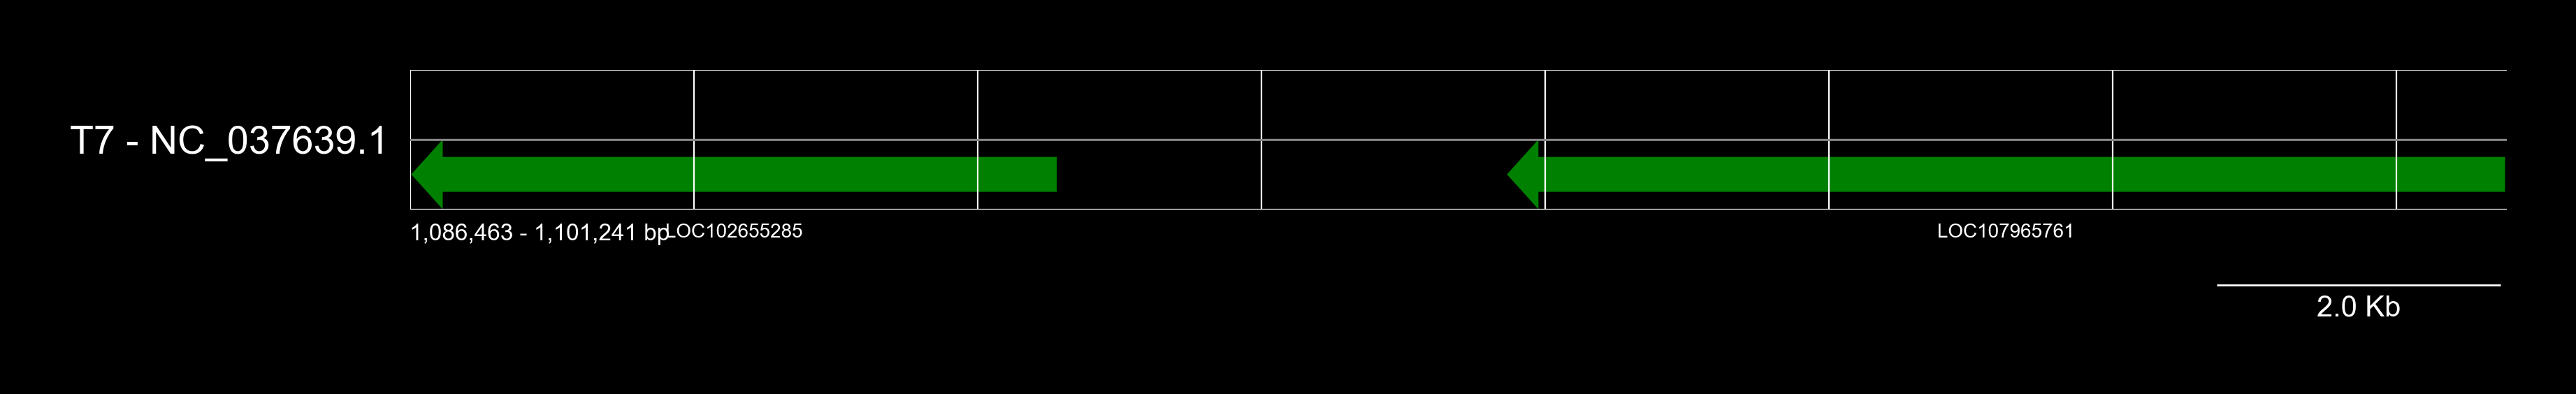

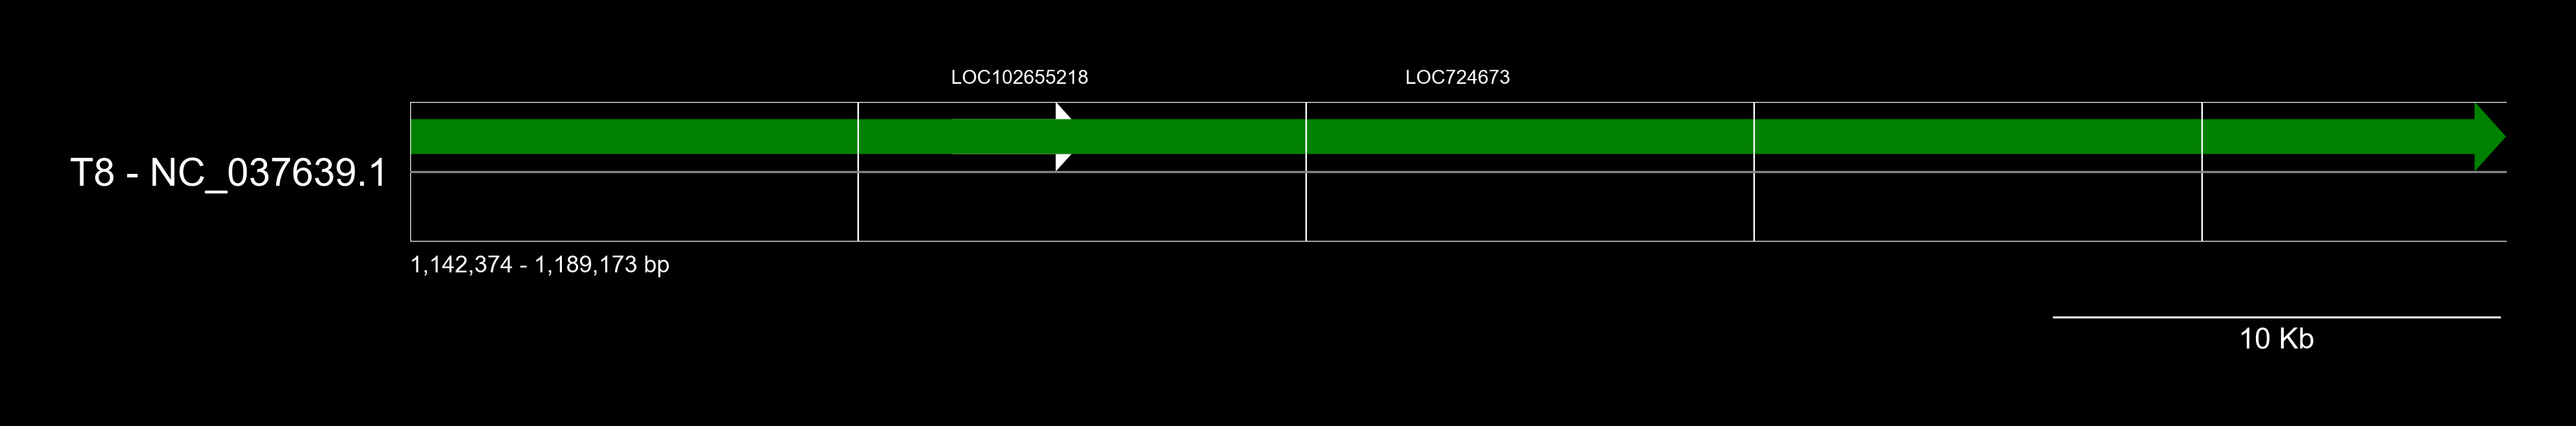

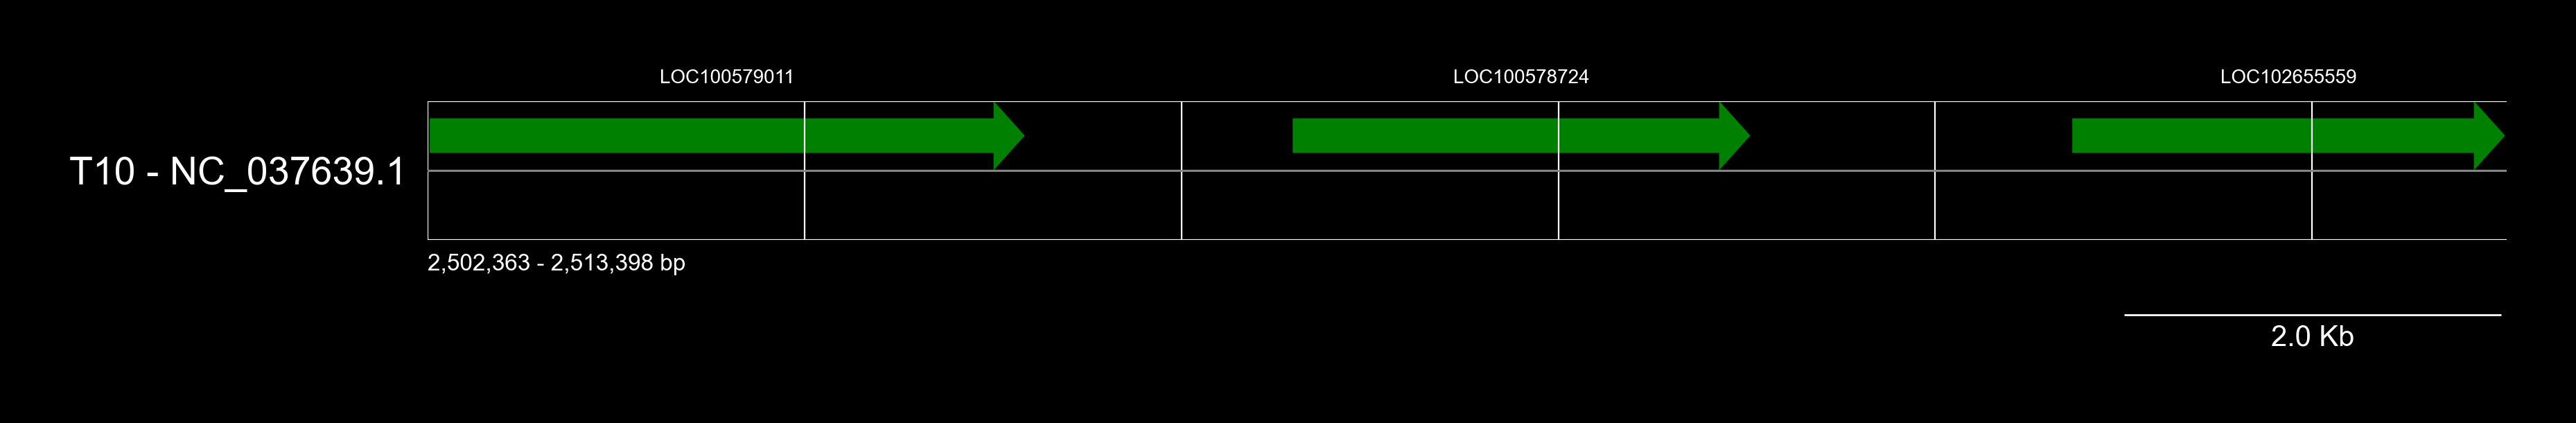

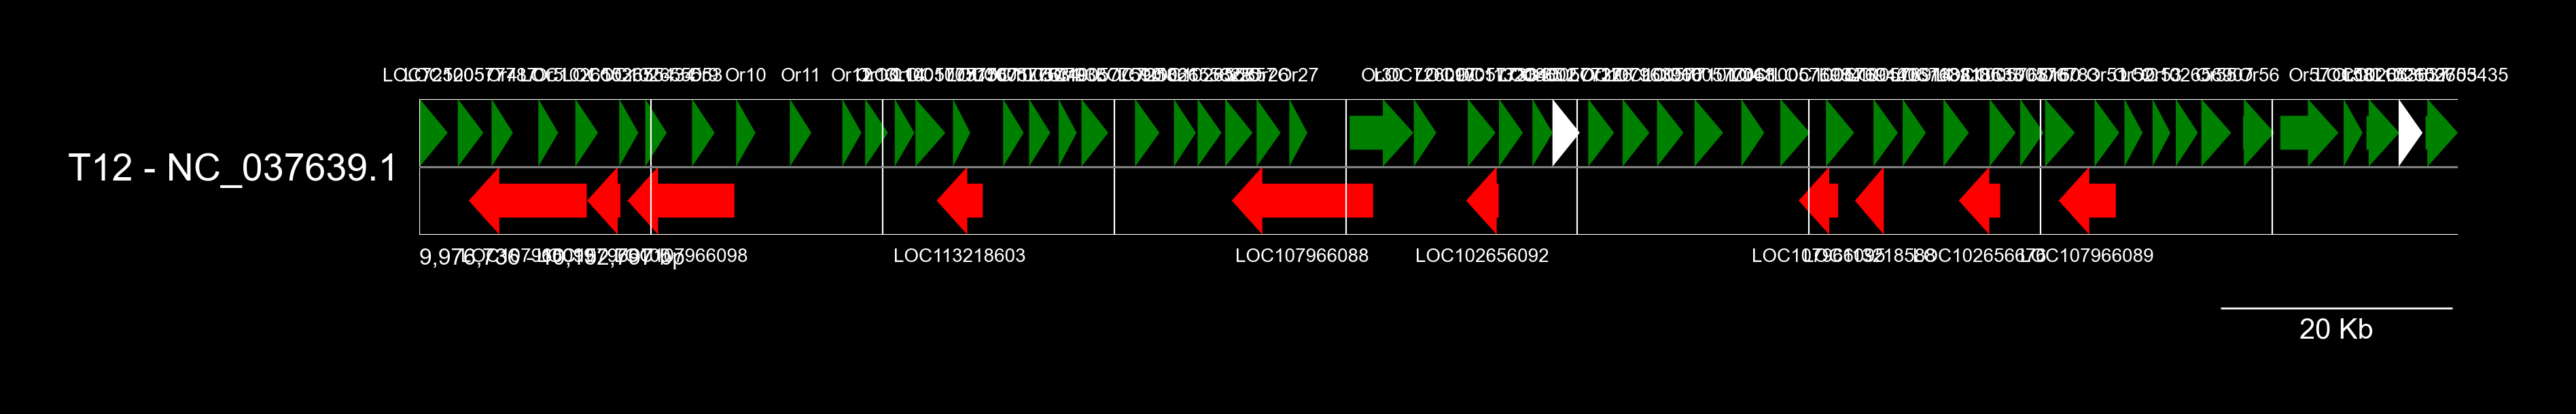

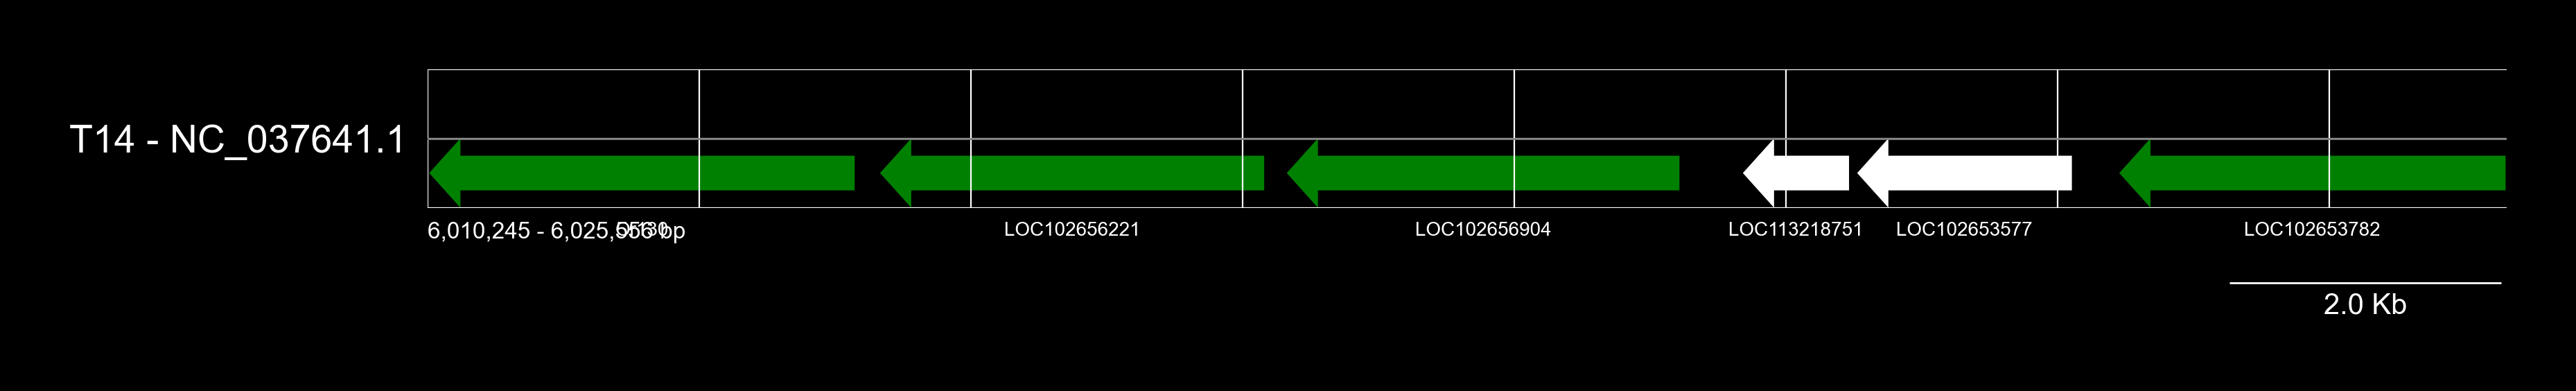

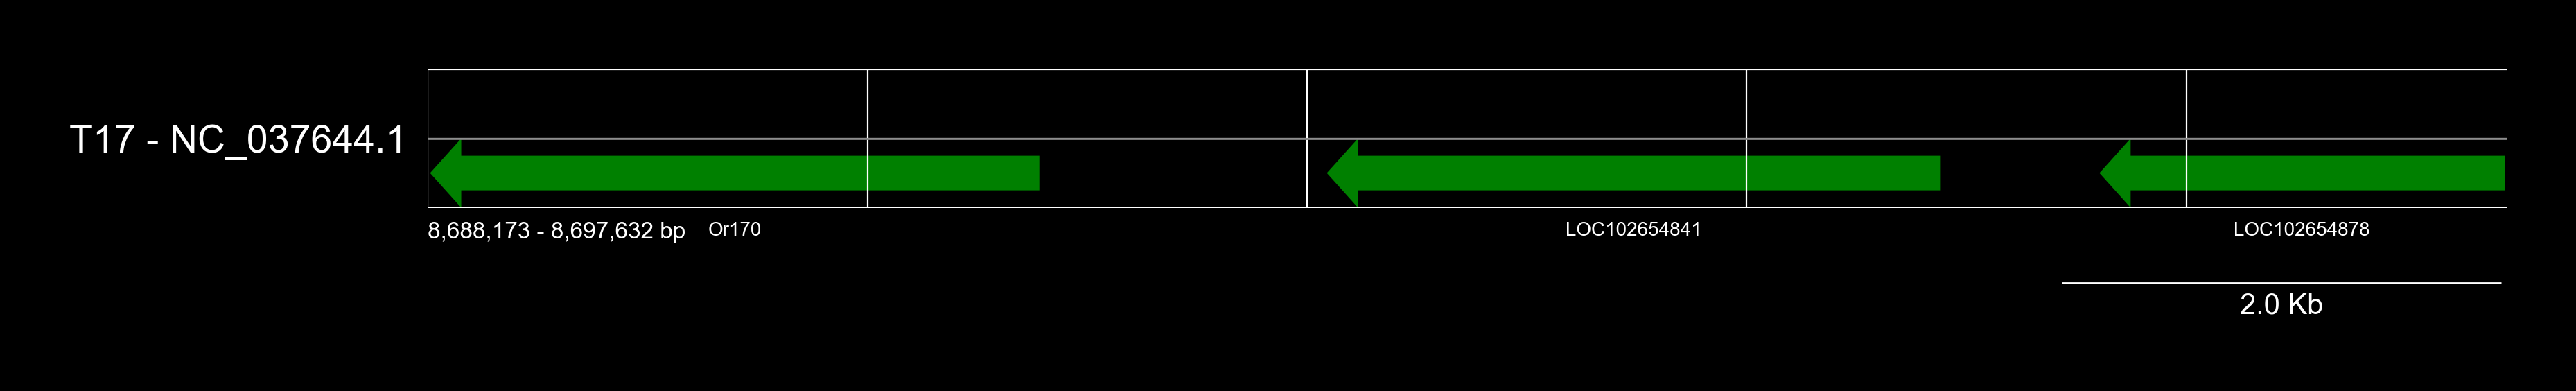

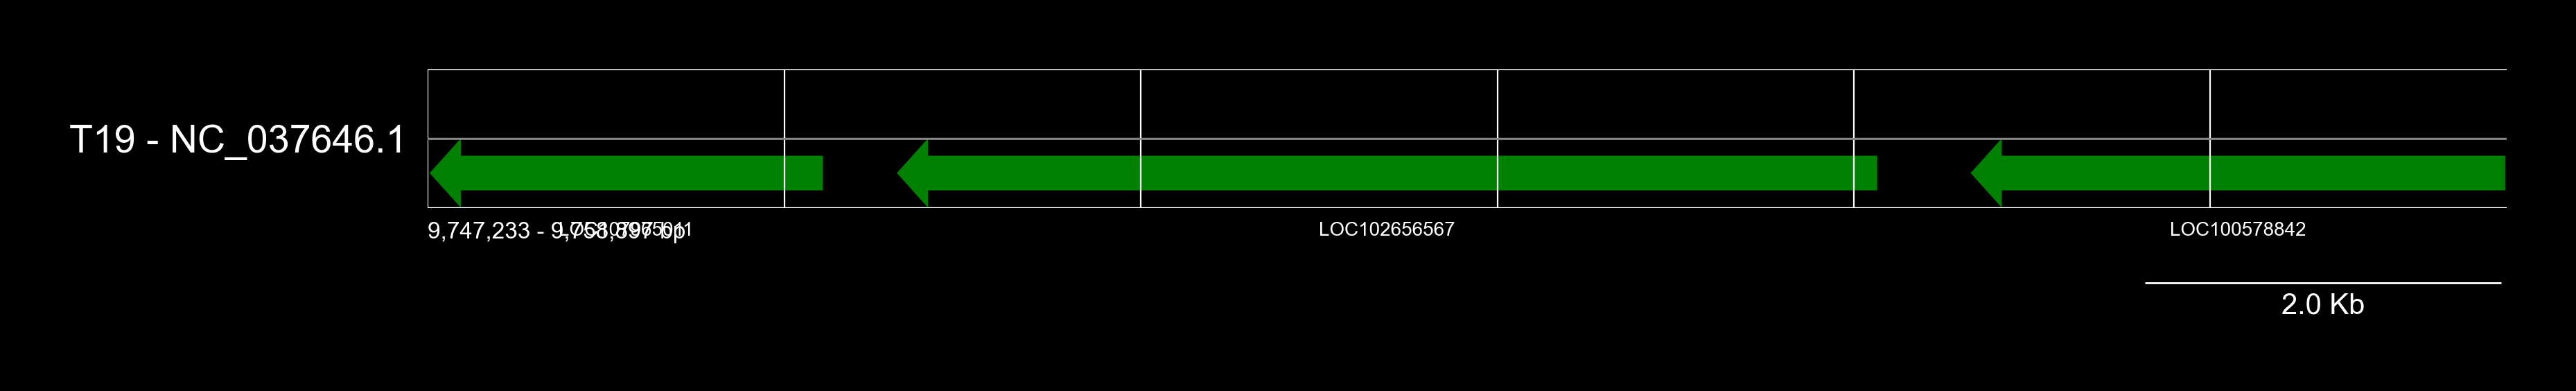

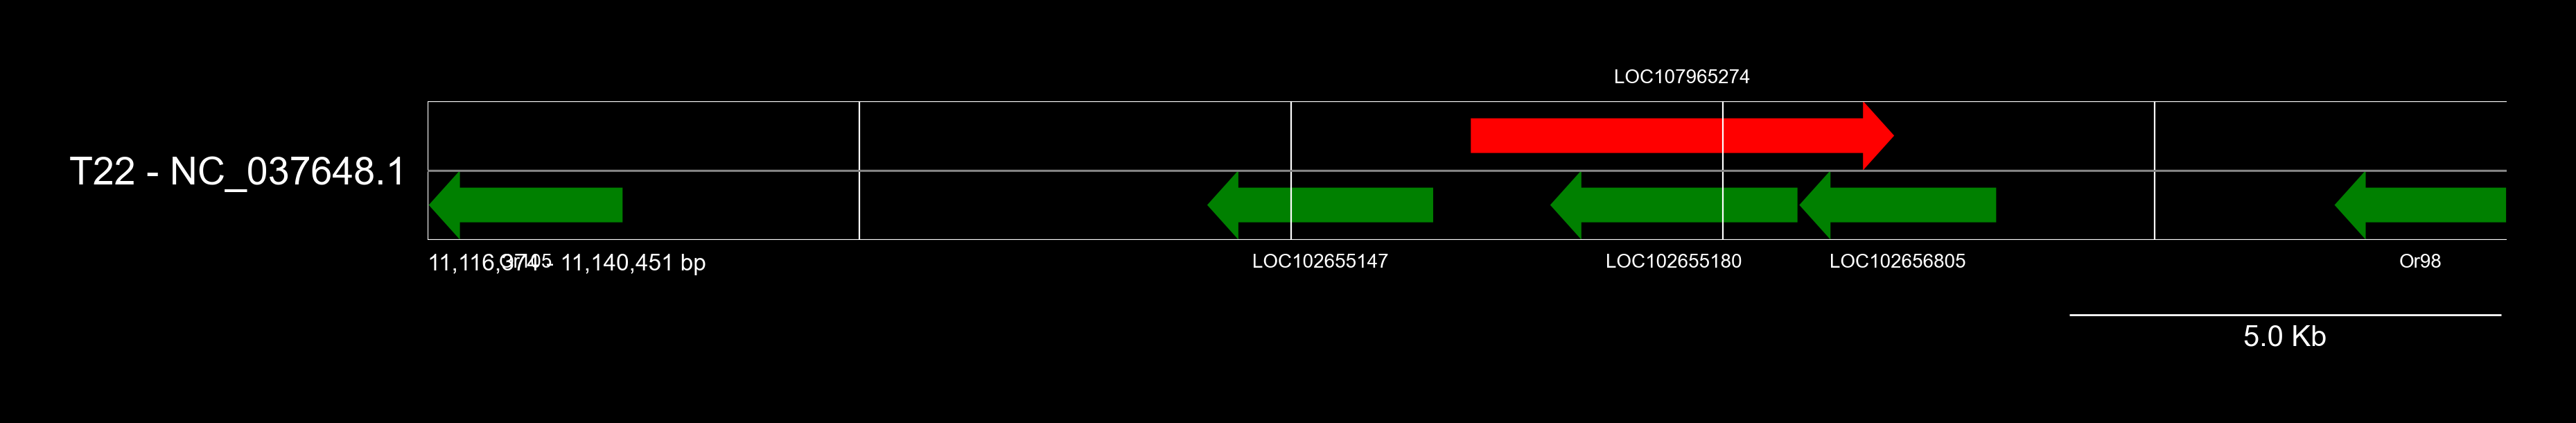

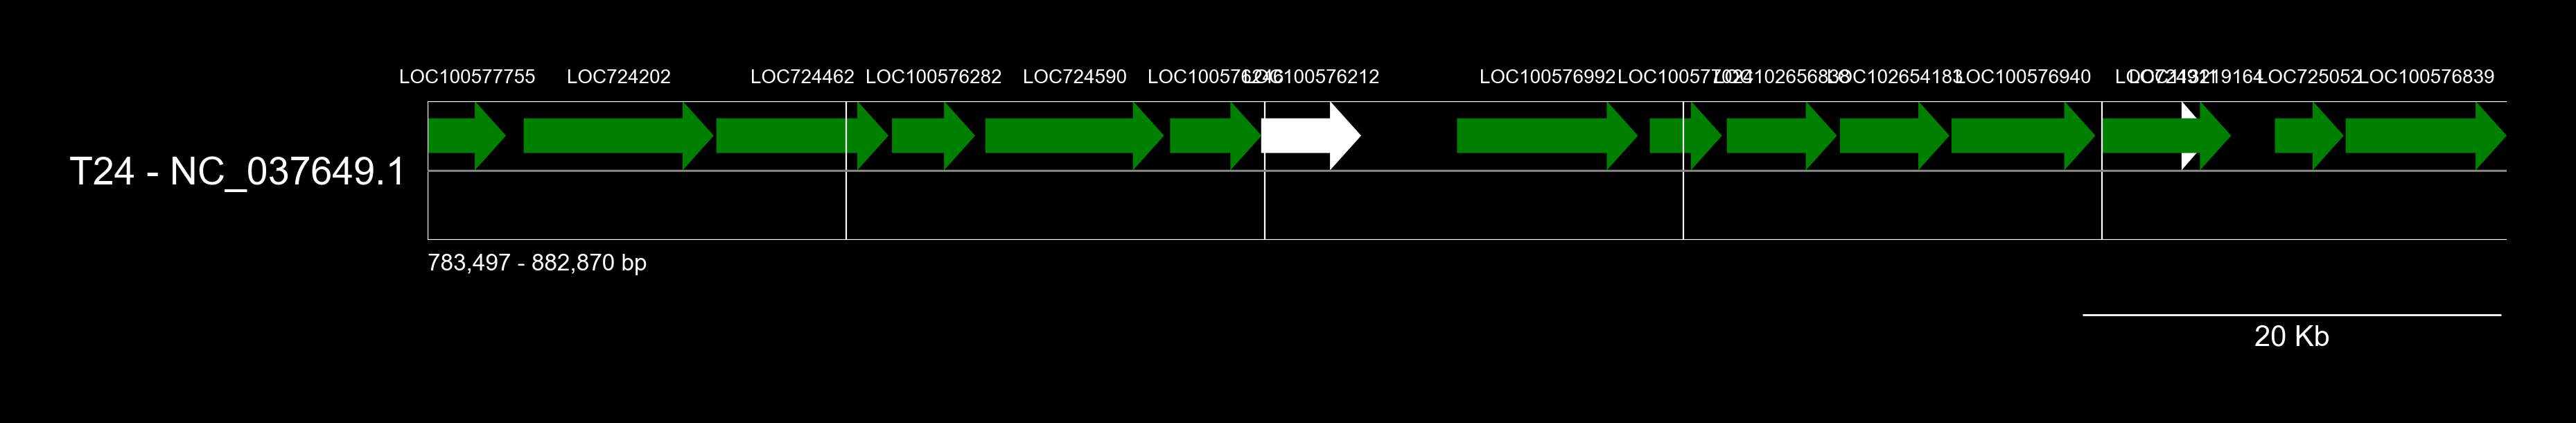

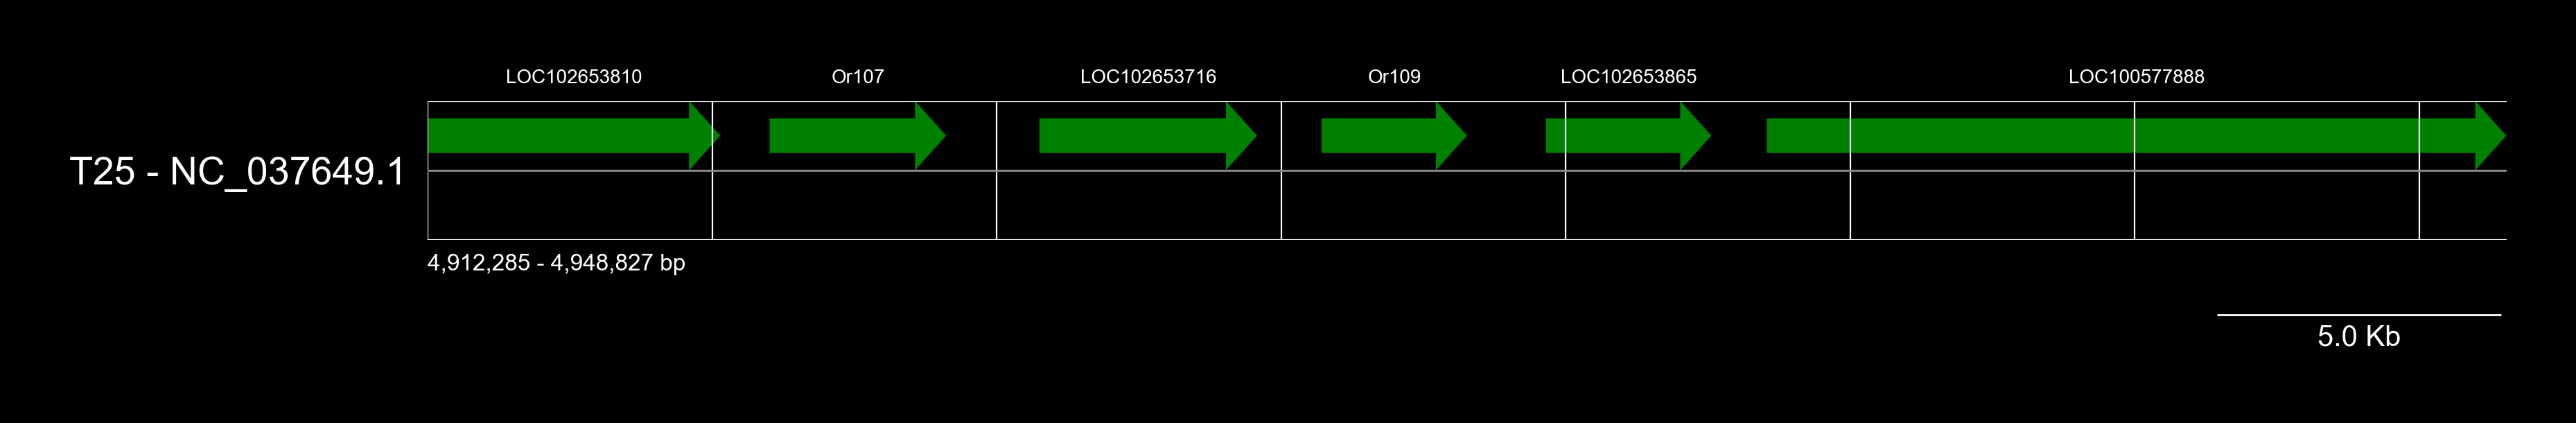

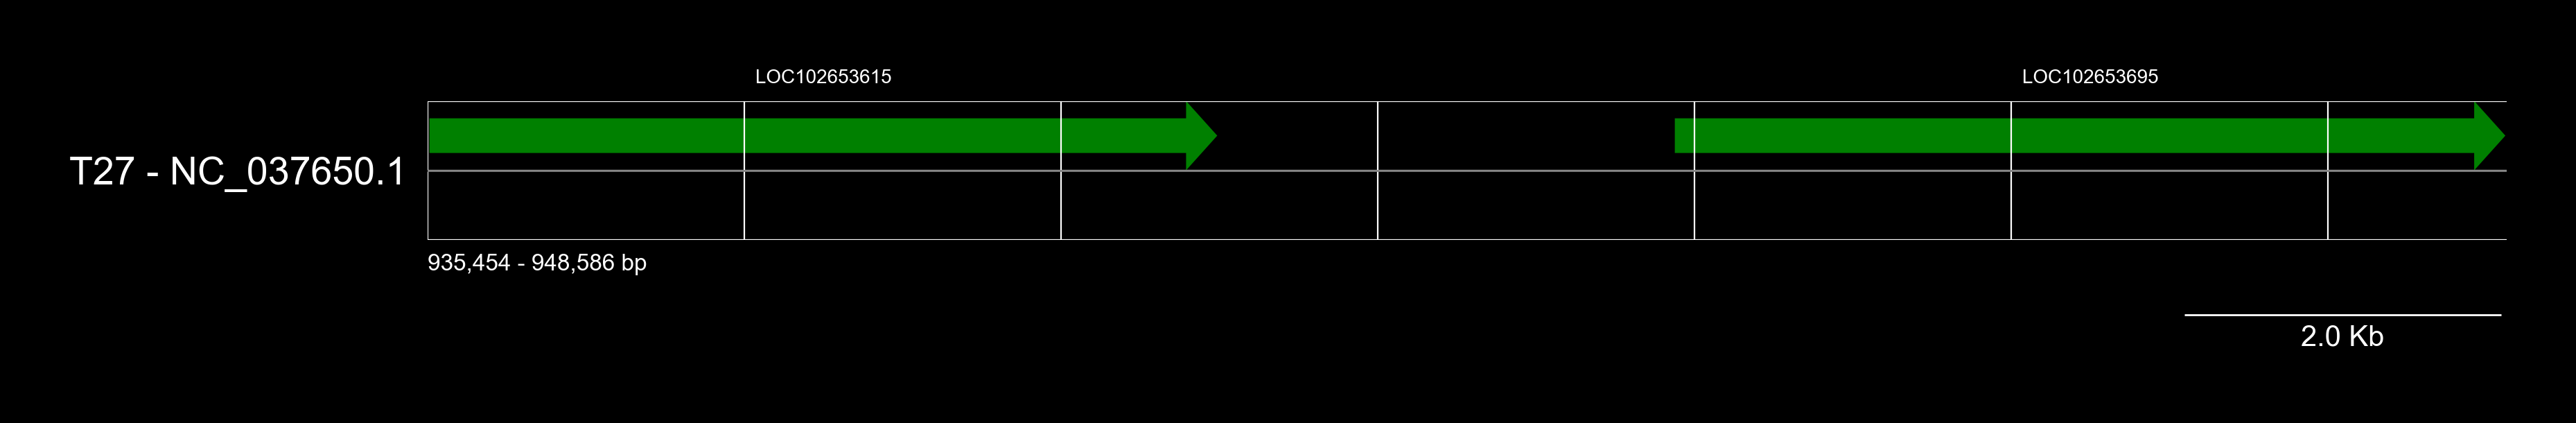

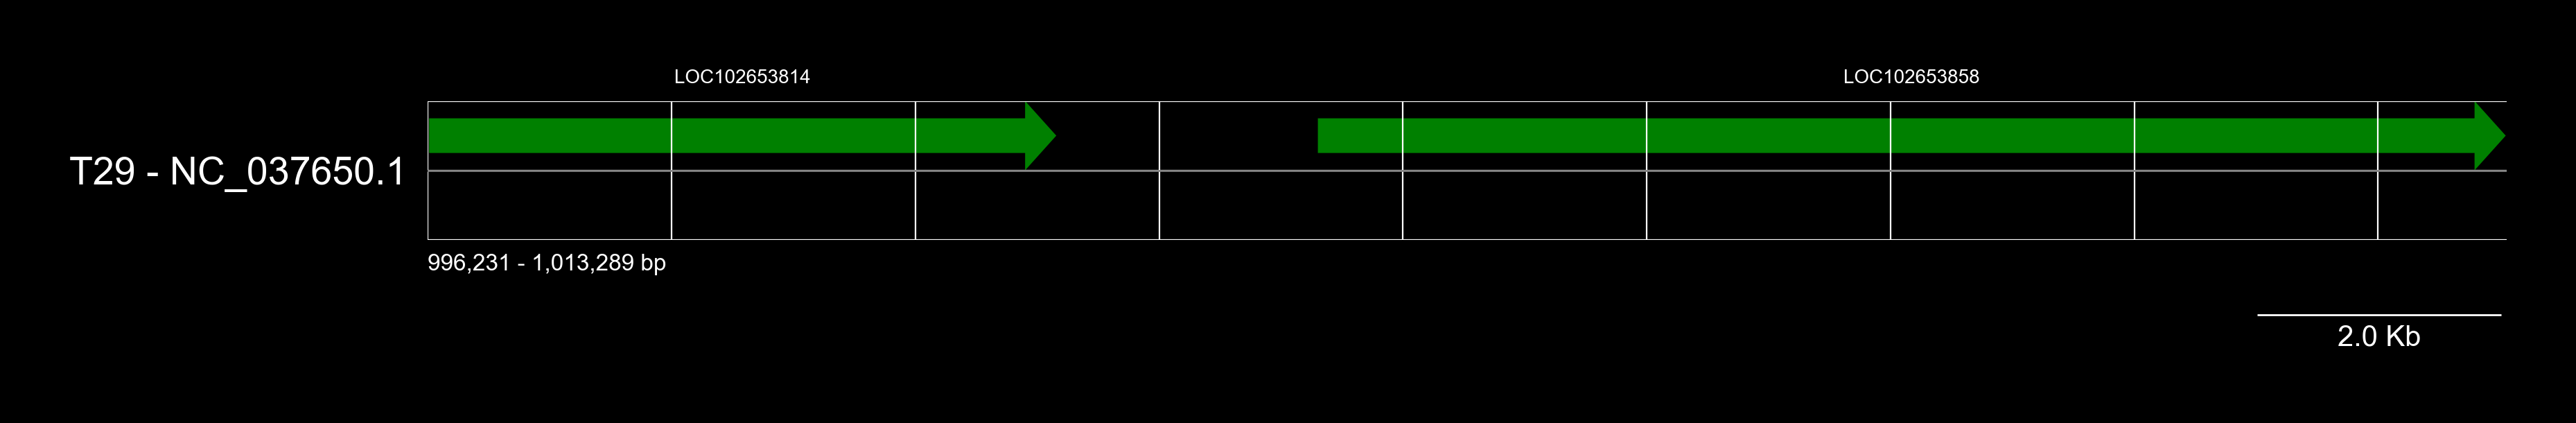

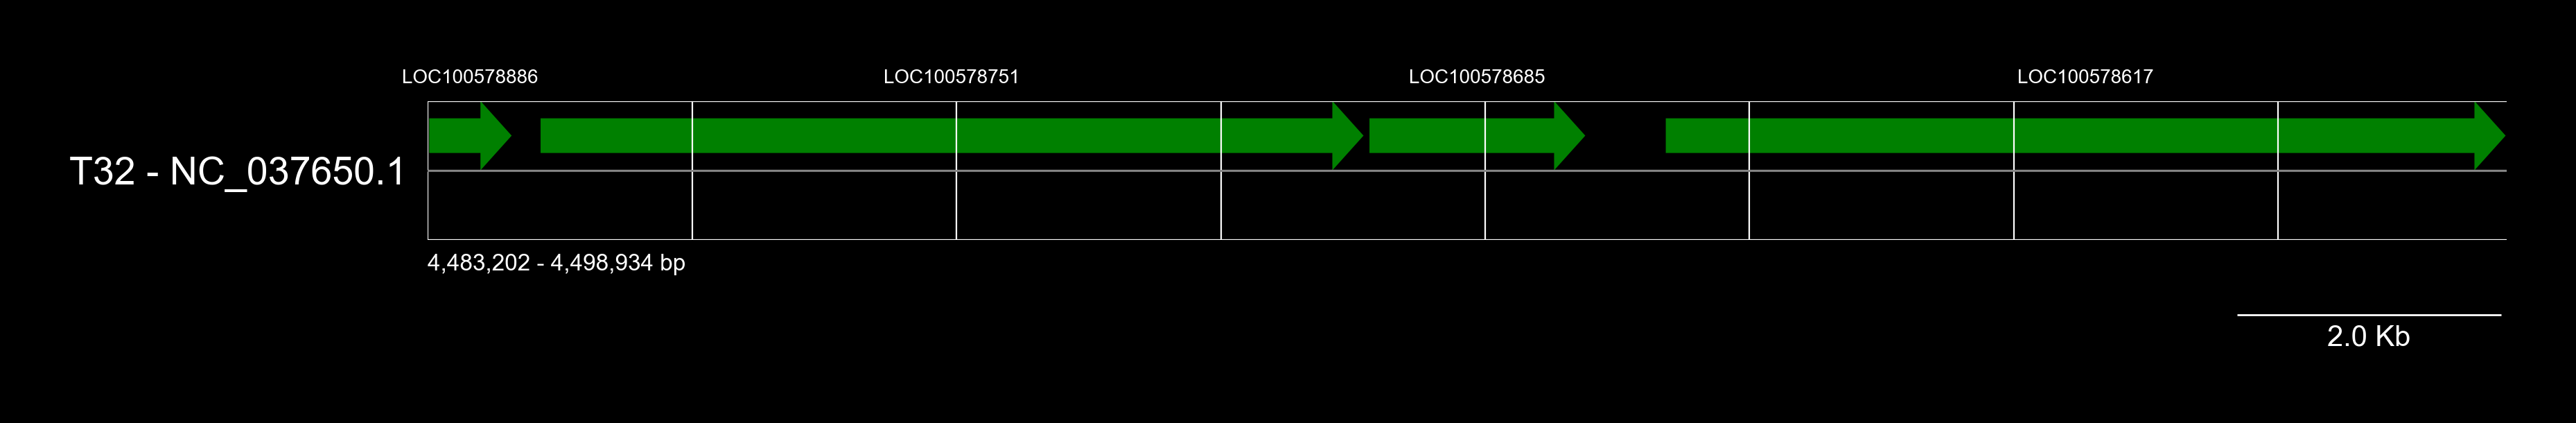

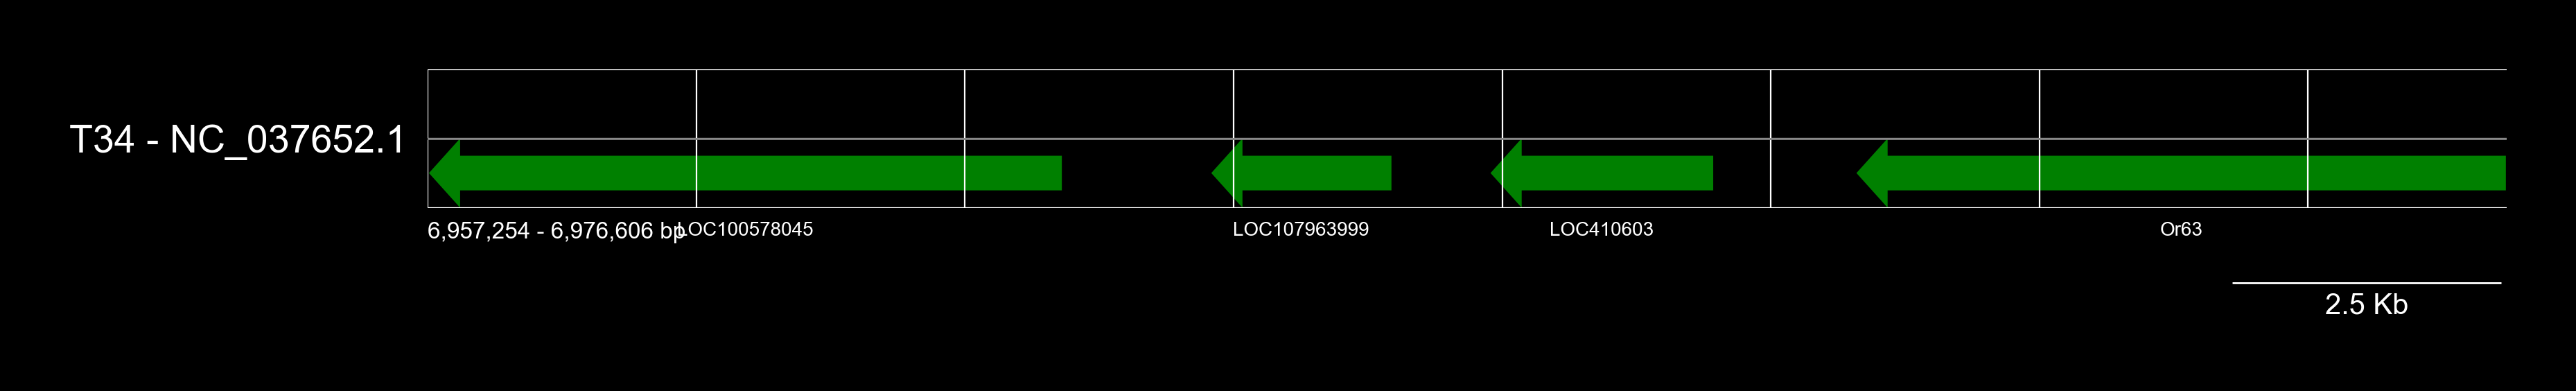

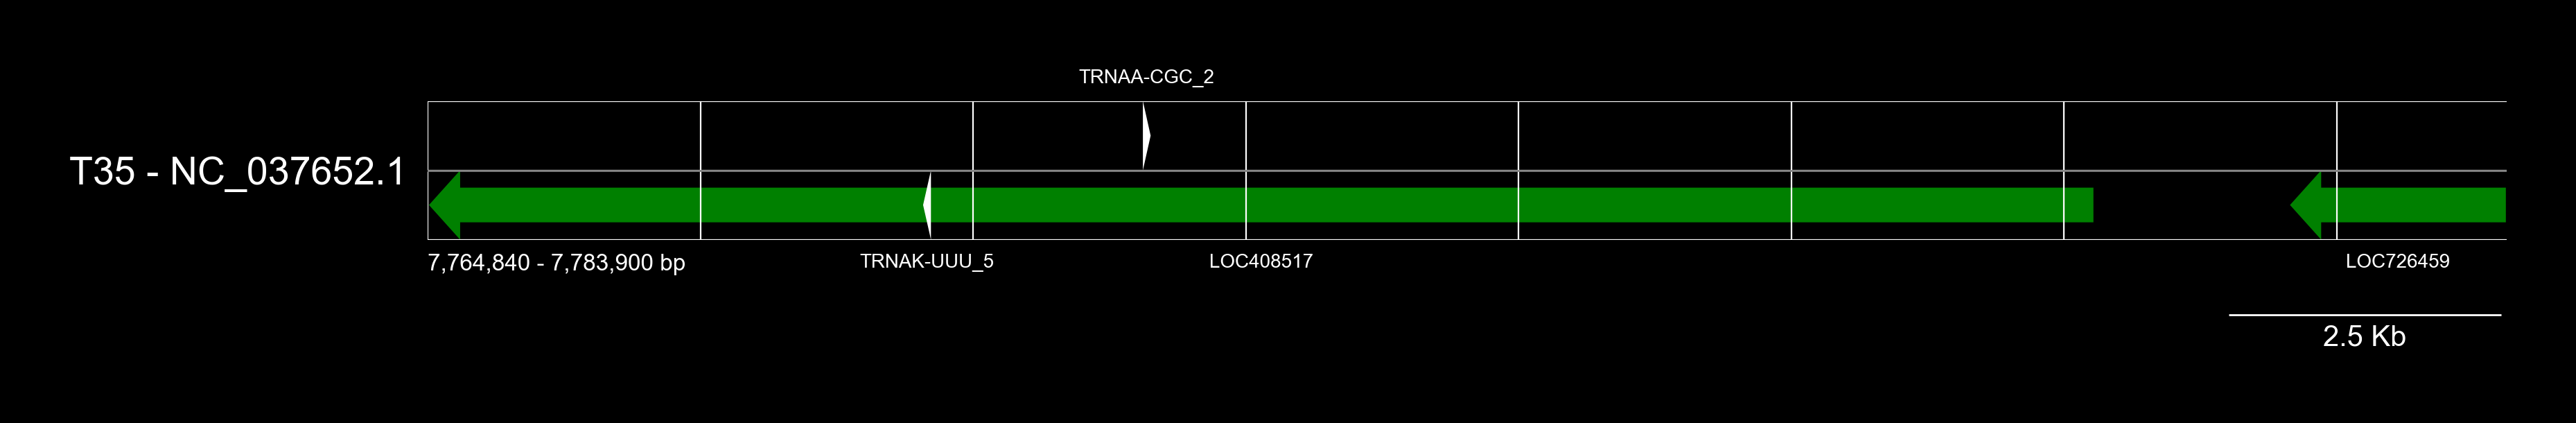

In [30]:
# get TAs with 2 or more ORs
tas = or_db[or_db['ta_size'] > 1]['tandem_array'].unique()

for ta_ in tas: 
    genes = or_db[or_db['tandem_array'] == ta_]
    start = genes['start'].min() - 10 
    end = genes['end'].max() + 10 
    scaffold = genes['scaffold'].iloc[0]

    genes_to_plot = [] 

    for gene in list(tr.genes.keys()): 
        gene_obj = tr.get_gene(gene) 
        if gene_obj.chromosome != scaffold: 
            continue
        if len(gene_obj.transcripts) > 0: 
            transcript = gene_obj.get_transcript_longest_cds()
            if transcript.get_bounds()[0] > start and transcript.get_bounds()[1] < end:
                genes_to_plot.append(gene)
    
    gene_bounds = [tr.get_gene(gene).get_transcript_longest_cds().get_bounds() for gene in genes_to_plot]

    gv = GenomeViz(track_align_type="center", theme="dark")
    gv.set_scale_bar(ymargin=0.5)

    # Get bounds 
    track = gv.add_feature_track(f"T{ta_} - {scaffold}", segments = (int(start), int(end)))
    track.add_sublabel()

    # Add gene models to plot 
    for gene in genes_to_plot:
        transcript = tr.get_gene(gene).get_transcript_longest_cds()
        if transcript.biotype == 'lnc_RNA': 
            color = 'red'
        elif gene in or_db['gene_name'].values or gene in or_db['gene_name_snrna'].values:
            color = 'green'
        else: 
            color = 'white'
            
        bounds = transcript.get_bounds()
        strand = np.where(transcript.strand == '+', 1, -1) 
        vpos = "top" if strand == 1 else "bottom"
        track.add_feature(
            int(bounds[0]),
            int(bounds[1]), 
            strand, 
            plotstyle='arrow', 
            fc=color, 
            arrow_shaft_ratio = 0.5, 
            label=gene, 
            text_kws={'color': 'white', 
                    'rotation': 0, 
                    'vpos': vpos, 
                    'hpos': 'center', 
                    'size':10}
        )

    fig = gv.plotfig()
    plt.show()

In [31]:
or_db.loc[or_db['tandem_array'] == 12]

gene_name  group alt_name gene_name_snrna     scaffold       start  \
14     LOC725205      2      Or1       LOC725205  NC_037639.1   9976746.0   
15  LOC100577787      2      Or3    LOC100577787  NC_037639.1   9980044.0   
16           Or4      2      Or4             Or4  NC_037639.1   9982958.0   
17           Or5      2      Or5             Or5  NC_037639.1   9986998.0   
18  LOC102655367      2      Or6    LOC102655367  NC_037639.1   9990191.0   
..           ...    ...      ...             ...          ...         ...   
62          Or56      2     Or56            Or56  NC_037639.1  10134234.0   
63          Or57      2     Or57            Or57  NC_037639.1  10137451.0   
64          Or58      2     Or58            Or58  NC_037639.1  10142917.0   
65  LOC102653637      2     Or59    LOC102653637  NC_037639.1  10144891.0   
66  LOC102655435      2     Or61    LOC102655435  NC_037639.1  10149997.0   

           end strand  n_exons nine_exon  rank tandem_array distance  ta_size  \
14   9979176.0      +      5.0     False    16           12     None       55   
15   9982251.0      +      4.0     False    17           12    868.0       55   
16   9984808.0      +      5.0     False    18           12    707.0       55   
17   9988716.0      +      5.0     False    19           12   2190.0       55   
18   9992152.0      +      4.0     False    20           12   1475.0       55   
..         ...    ...      ...       ...   ...          ...      ...      ...   
62  10136939.0      +      6.0     False    66           12   1027.0       55   
63  10142473.0      +      7.0     False    67           12    512.0       55   
64  10144562.0      +      6.0     False    68           12    444.0       55   
65  10147722.0      +      6.0     False    69           12    329.0       55   
66  10152787.0      +      6.0     False    71           12    262.0       55   

    ta_index ta_strand  
14         0         +  
15         1         +  
16         2         +  
17         3         +  
18         4         +  
..       ...       ...  
62        48         +  
63        49         +  
64        50         +  
65        51         +  
66        52         +  

[53 rows x 16 columns]

In [32]:
# How many unique TAs? 
n_unique_tas = or_db.tandem_array.nunique()
print(f"Identified {n_unique_tas} unique TAs")

Identified 40 unique TAs


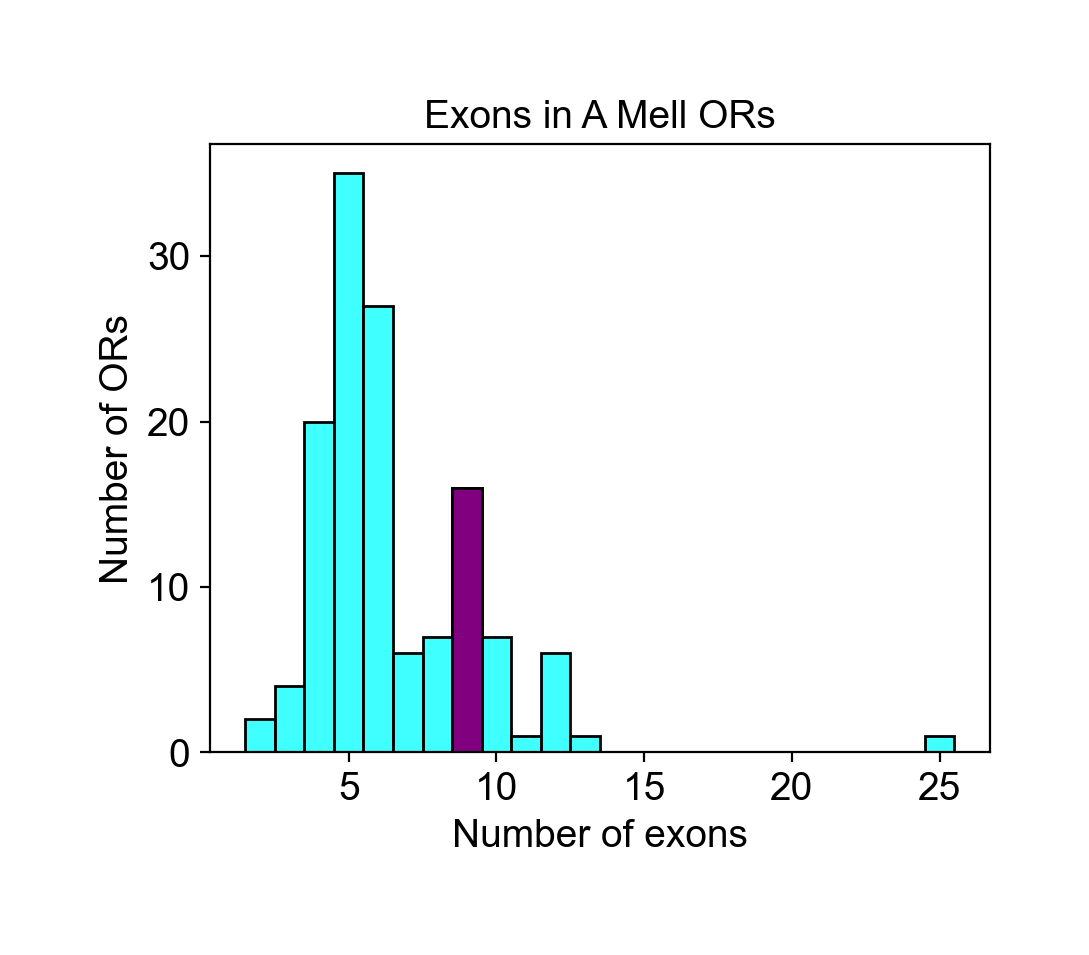

In [33]:
# Plot the distribution of exon numbers in ORs
white_plotting()
plt.figure(figsize=(5, 4))
sns.histplot(or_db["n_exons"], color="cyan", discrete=True)
plt.bar(9, or_db["n_exons"].value_counts()[9], color="purple", edgecolor="black", width=1)
plt.xlabel("Number of exons")
plt.ylabel("Number of ORs")
plt.title("Exons in A Mell ORs")
plt.show()

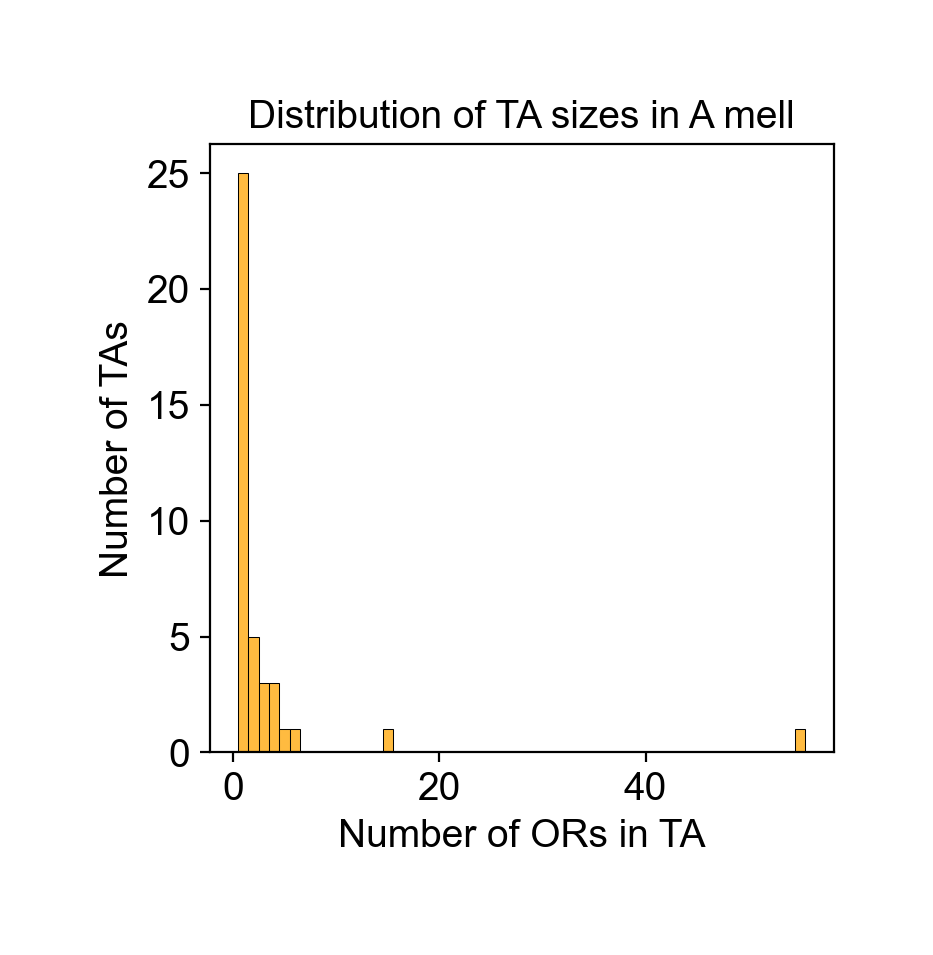

In [34]:
# Plot the distribution of TA sizes
first_rows = or_db.groupby('tandem_array').first()
white_plotting()
plt.figure(figsize=(4, 4))
sns.histplot(first_rows.ta_size, color="orange", discrete=True)
plt.xlabel("Number of ORs in TA")
plt.ylabel("Number of TAs")
plt.title("Distribution of TA sizes in A mell")
plt.show()

## Load scRNAseq Data

In [35]:
base_dir = "/Users/giacomo.glotzer/Desktop/Rockefeller/Kronauer/scRNAseq/AMellifera/scRNAseq/"
samples = ["Forager", "Nurse", "NewlyEmerged"]
adatas = {}
for sample in samples:
    input_dir = base_dir + sample 
    adata = sc.read_10x_mtx(input_dir, var_names='gene_symbols', cache=True)  
    adata.var_names_make_unique()
    adata.obs["sample"] = sample
    adatas[sample] = adata

In [36]:
adatas

{'Forager': AnnData object with n_obs × n_vars = 4615 × 12370
     obs: 'sample'
     var: 'gene_ids', 'feature_types',
 'Nurse': AnnData object with n_obs × n_vars = 3359 × 12370
     obs: 'sample'
     var: 'gene_ids', 'feature_types',
 'NewlyEmerged': AnnData object with n_obs × n_vars = 3543 × 12370
     obs: 'sample'
     var: 'gene_ids', 'feature_types'}

In [37]:
"""# Get cell IDs 
adatas["Forager"].obs["cell_id"] = adatas["Forager"].obs.index.to_series().apply(lambda x: x + "-F")
adatas["Nurse"].obs["cell_id"] = adatas["Nurse"].obs.index.to_series().apply(lambda x: x + "-N")
adatas["NewlyEmerged"].obs["cell_id"] = adatas["NewlyEmerged"].obs.index.to_series().apply(lambda x: x + "-NE")

# Concatenate adatas into adata 
adata = adatas["Forager"].concatenate(adatas["Nurse"], adatas["NewlyEmerged"])
adata

# PCA 
sc.pp.pca(adata) 
print("Performed PCA")

# Harmony Integration: When you have clear batch labels (e.g., different time points) and want to align datasets while preserving biological variability. 
sce.pp.harmony_integrate(adata, 'batch')"""

'# Get cell IDs \nadatas["Forager"].obs["cell_id"] = adatas["Forager"].obs.index.to_series().apply(lambda x: x + "-F")\nadatas["Nurse"].obs["cell_id"] = adatas["Nurse"].obs.index.to_series().apply(lambda x: x + "-N")\nadatas["NewlyEmerged"].obs["cell_id"] = adatas["NewlyEmerged"].obs.index.to_series().apply(lambda x: x + "-NE")\n\n# Concatenate adatas into adata \nadata = adatas["Forager"].concatenate(adatas["Nurse"], adatas["NewlyEmerged"])\nadata\n\n# PCA \nsc.pp.pca(adata) \nprint("Performed PCA")\n\n# Harmony Integration: When you have clear batch labels (e.g., different time points) and want to align datasets while preserving biological variability. \nsce.pp.harmony_integrate(adata, \'batch\')'

In [38]:
timepoint = "NewlyEmerged"
adata = adatas[timepoint]

In [39]:
# QC 
sc.pp.calculate_qc_metrics(adata, inplace=True)
adata

AnnData object with n_obs × n_vars = 3543 × 12370
    obs: 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes'
    var: 'gene_ids', 'feature_types', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

In [40]:
# Filter genes and cells
sc.pp.filter_genes(adata, min_cells=2)  # Remove genes expressed in fewer than 10 cells
print(f"Number of cells: {adata.n_obs}, number of genes: {adata.n_vars} after filtering genes")

sc.pp.filter_cells(adata, min_genes=100)  # Remove cells with fewer than 200 genes expressed
print(f"Number of cells: {adata.n_obs}, number of genes: {adata.n_vars} after filtering cells")

Number of cells: 3543, number of genes: 11128 after filtering genes
Number of cells: 3542, number of genes: 11128 after filtering cells


In [41]:
# Verify that the gene names are in the transcriptome
all_genes = [gene for gene in list(tr.genes.keys())]
adata.var["in_tr"] = adata.var.index.isin(all_genes)
print(f"Identified {adata.var['in_tr'].sum()} genes in the transcriptome out of {adata.n_vars}")

Identified 11085 genes in the transcriptome out of 11128


In [42]:
# Verify that the gene names in the OR database are in the transcriptome
adata.var["in_or_db"] = adata.var.index.isin(or_db["gene_name"])
print(f"Identified {adata.var['in_or_db'].sum()} ORs in the snRNAseq data out of {or_db.shape[0]}")

Identified 121 ORs in the snRNAseq data out of 133


In [43]:
# Use 'gene_name_snrna' when querying ORs in adata 
adata.var["in_or_db"] = adata.var.index.isin(or_db["gene_name_snrna"])
print(f"Identified {adata.var['in_or_db'].sum()} ORs in the snRNAseq data out of {or_db.shape[0]}")

Identified 133 ORs in the snRNAseq data out of 133


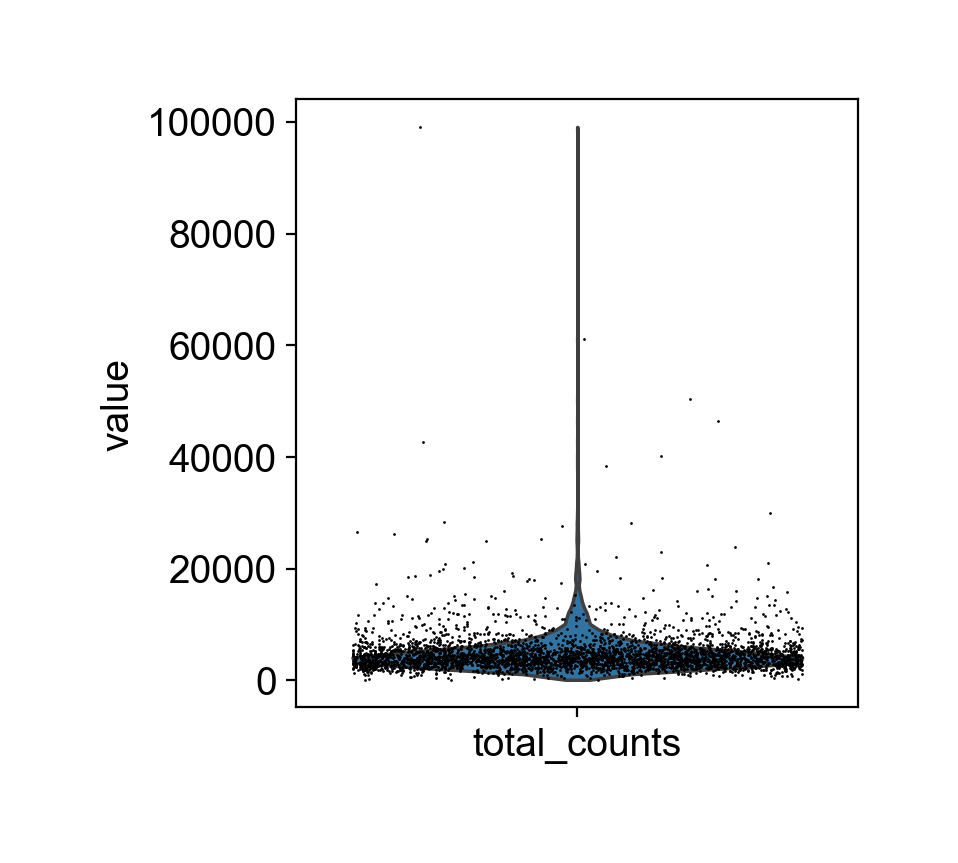

In [44]:
white_plotting()    
sc.pl.violin(adata, ['total_counts'], jitter=0.4, log=False)

In [45]:
# Normalize total counts per cell
sc.pp.normalize_total(adata, target_sum=1e4) # Obir value 
print("Normalizing total counts per cell")

# Log-transform the data
sc.pp.log1p(adata)  
print("Log-transforming data")

Normalizing total counts per cell
Log-transforming data


In [46]:
# PCA 
sc.pp.pca(adata) 
print("Performed PCA")

Performed PCA


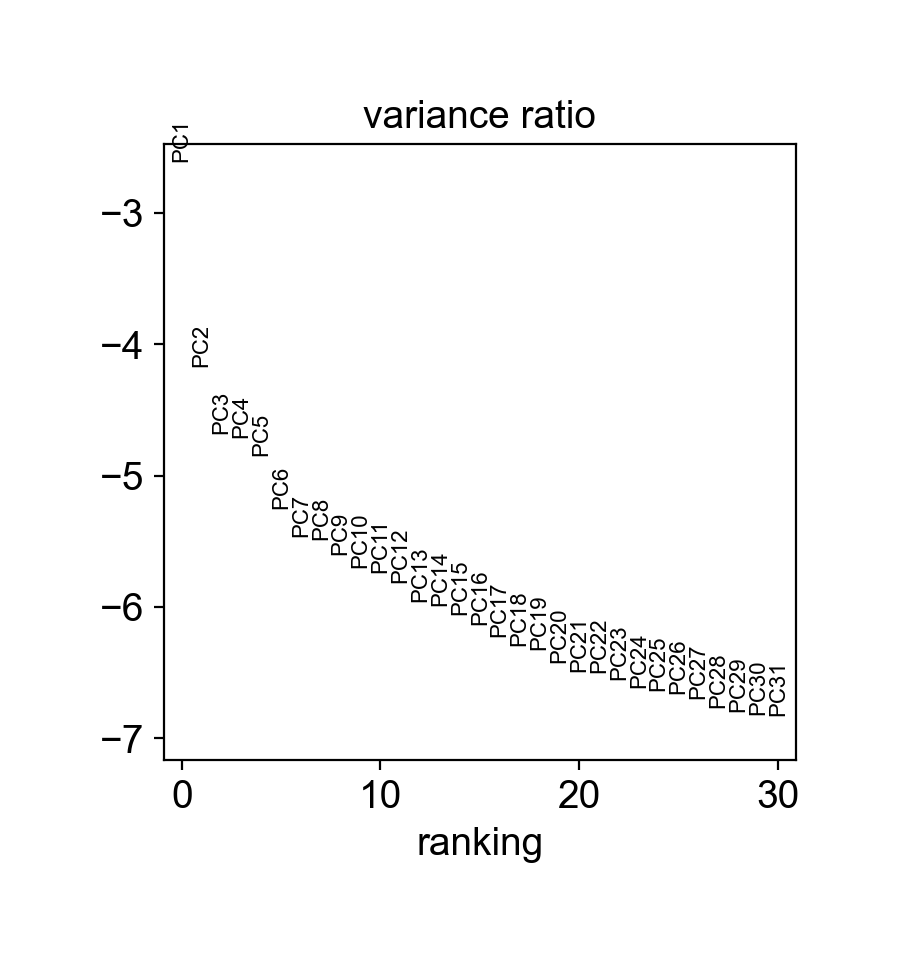

In [47]:
sc.pl.pca_variance_ratio(adata, log=True)

In [48]:
sc.pp.highly_variable_genes(adata, min_mean=0.001, max_mean=5, min_disp=0.5)

In [49]:
sc.pp.neighbors(adata, n_neighbors=30, n_pcs=30, use_rep="X_pca")

In [50]:
sc.tl.umap(adata) 
print("Computed UMAP")

Computed UMAP


In [51]:
sc.tl.leiden(adata, resolution=0.5) 
print("Performed Leiden clustering")

Performed Leiden clustering


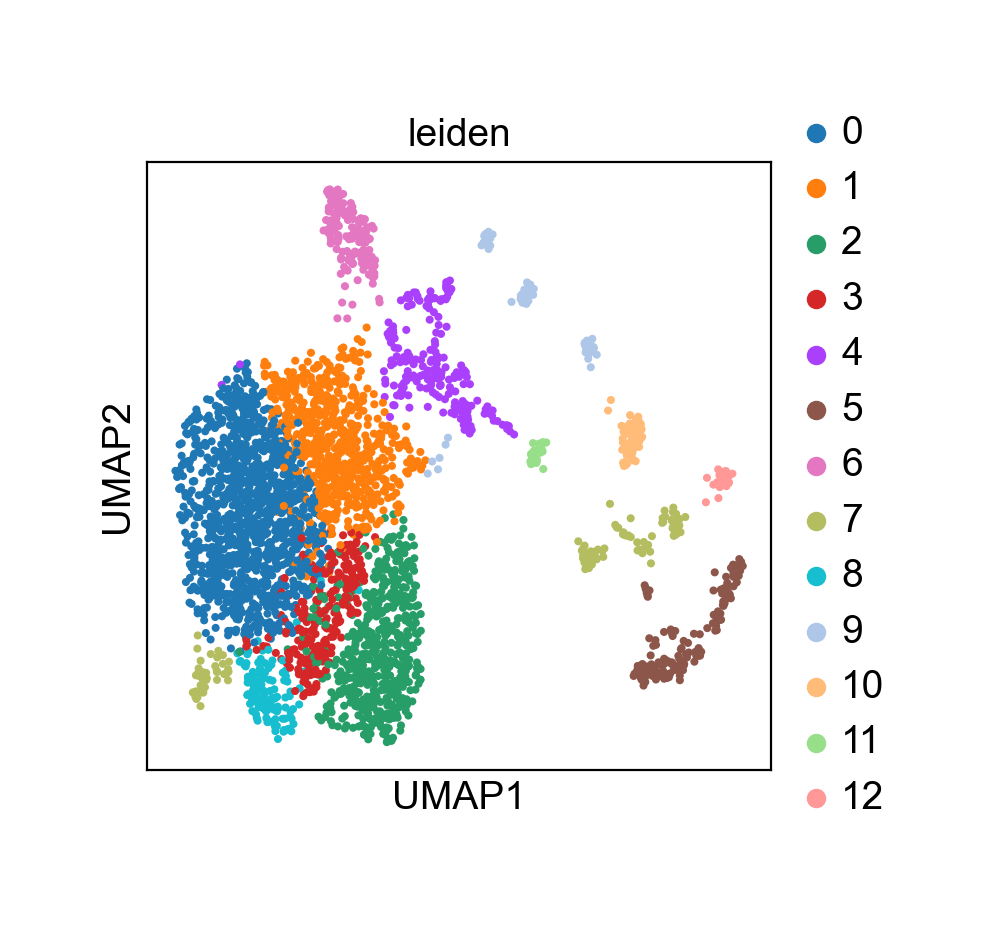

In [52]:
# Plot
sc.pl.umap(adata, color=["leiden"])

## Unsupervised Bubble Plot

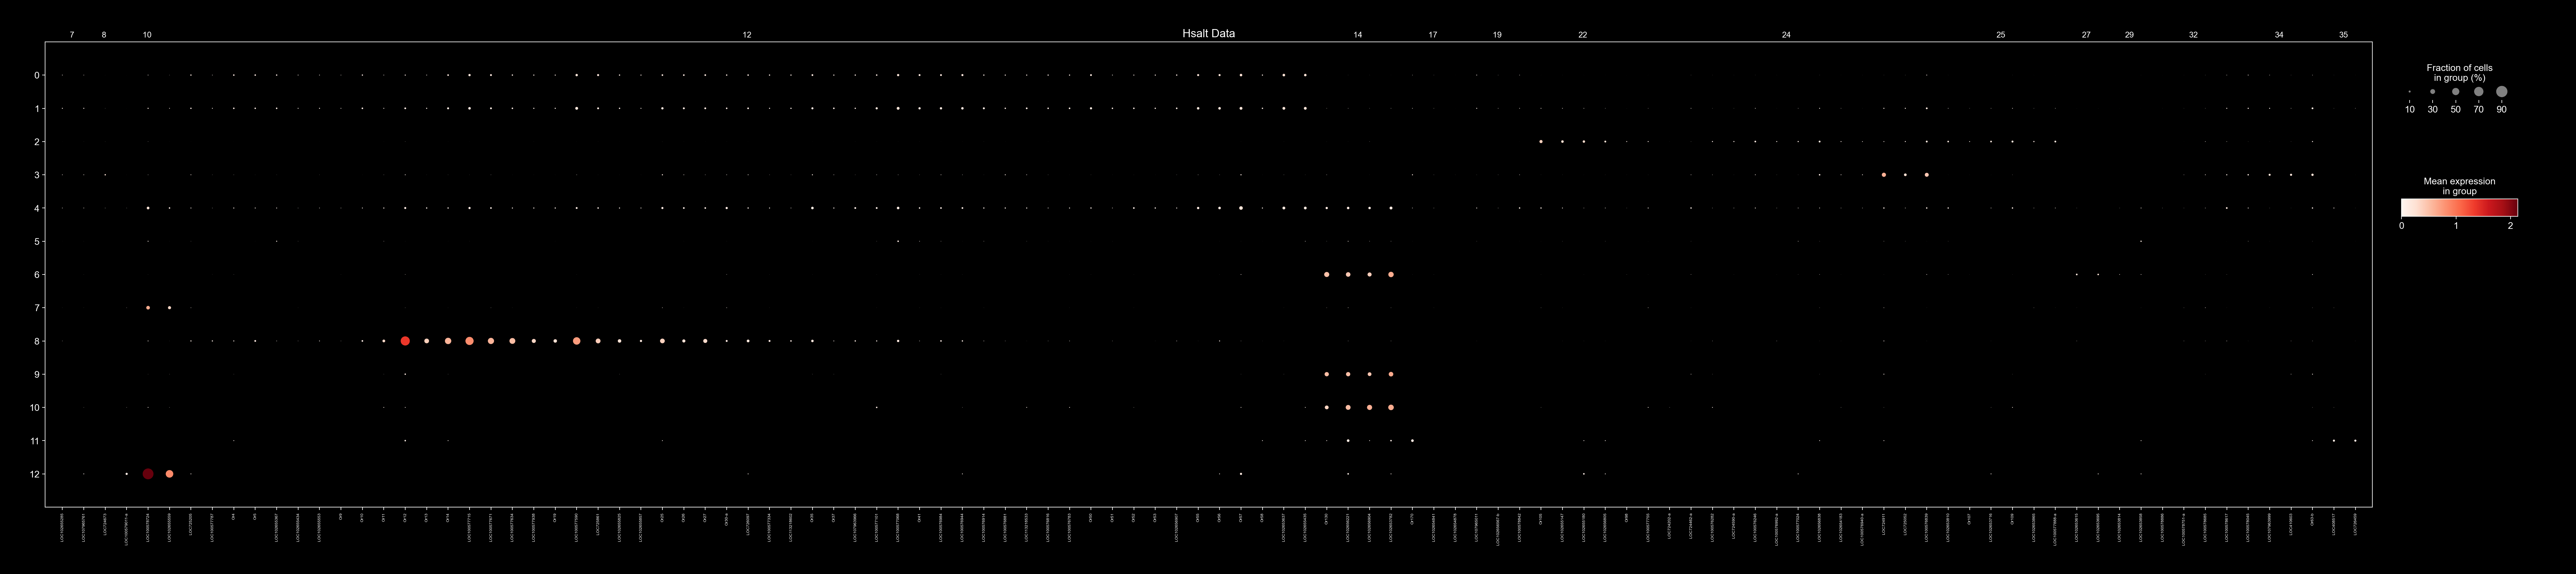

In [53]:
# Convert ta_size to int 
or_db["ta_size"] = or_db["ta_size"].astype(int)
# Sort by tandem array size
or_db_sorted = or_db.sort_values(by=['ta_size'])
# Remove TAs with size less than 3 
or_db_sorted_subset = or_db_sorted[or_db_sorted['ta_size'] > 1]
# Create a dictionary of TAs to ORs
ta_to_ors = or_db_sorted_subset.groupby('tandem_array')['gene_name_snrna'].apply(list).to_dict()

# Sort each list of ORs by start position
for ta, ors in ta_to_ors.items():
    ta_to_ors[ta] = sorted(ors, key=lambda x: or_db.loc[or_db.gene_name_snrna == x, 'start'].values[0])

# Convert keys to string 
ta_to_ors = {str(k): v for k, v in ta_to_ors.items()}

# Plot bubble plot of P1 clusters vs genes 
black_plotting()
f, ax = plt.subplots(1, 1, figsize=(50, 10))
dp = sc.pl.dotplot(adata, ta_to_ors, groupby="leiden", ax=ax, show=False)

ax = dp["mainplot_ax"]
# Loop through ticklabels and make them italic
for l in ax.get_xticklabels():
    l.set_size(5)

# Adjust the fontsize of the top labels 
group_ax = dp["gene_group_ax"]  # This is the axis for the grouping variable labels

# Adjust the font size of the group labels
for text in group_ax.texts:  # group_ax.texts holds the text objects for the group labels
    text.set_fontsize(10) 

# Add ylabel 
ax.set_title("Hsalt Data")

# Adjust spacing of axes so that size_legend_ax and color_legend_ax are visible 
dp['mainplot_ax'].set_position([0.1, 0.1, 0.8, 0.8])  # Shrink mainplot_ax width to 0.6
dp['gene_group_ax'].set_position([0.1, 0.85, 0.8, 0.05])  # Align gene_group_ax with mainplot_ax

dp["size_legend_ax"].set_position([0.91, 0.8, 0.04, 0.05])  # Position size legend
dp["color_legend_ax"].set_position([0.91, 0.6, 0.04, 0.03])  # Position color legend

plt.show()

## Save Tandem Array to Data

In [54]:
# Tandem array based assignment
tandem_array_matrix = pd.DataFrame(0, index=adata.obs_names, columns=or_db['tandem_array'].unique().astype(str))
for array in or_db['tandem_array'].unique():
    tandem_array_matrix[array] = adata[:, or_db[or_db['tandem_array'] == array]['gene_name_snrna']].X.sum(axis=1)

# Add the tandem array matrix to the data 
adata.obsm['tandem_array'] = tandem_array_matrix.values

# Assign clusters to cells based on the tandem array with the highest expression
adata.obs['tandem_array_cluster'] = tandem_array_matrix.idxmax(axis=1).values.astype(str) 

## Bubble Plot of Tandem Array Clusters vs ORs

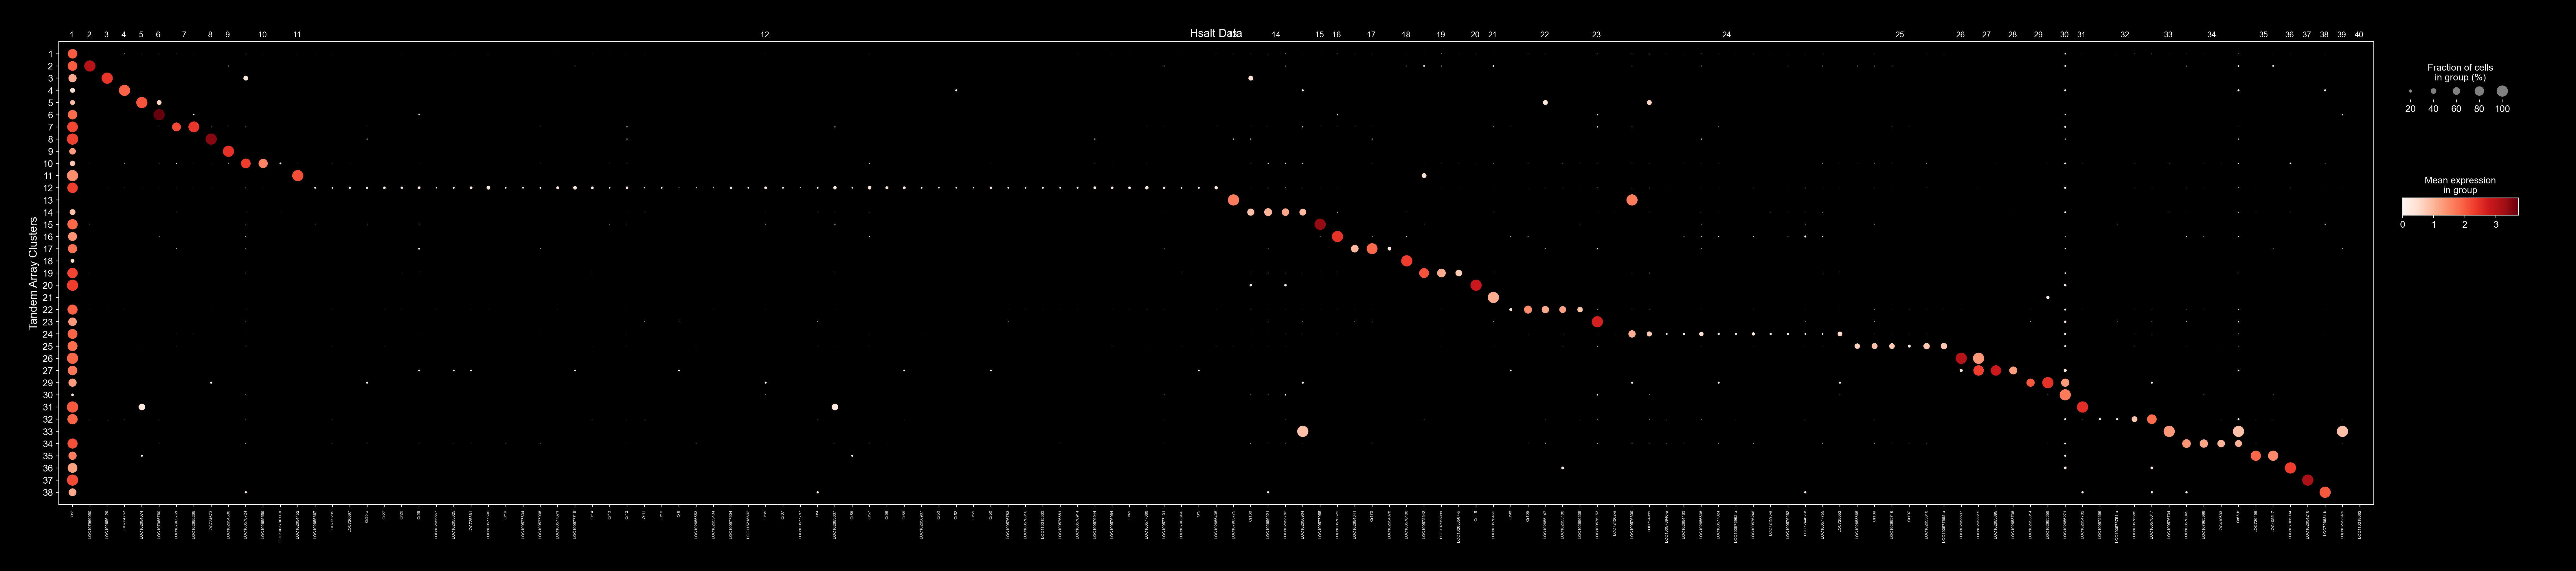

In [55]:
# Convert ta_size to int 
or_db["ta_size"] = or_db["ta_size"].astype(int)
# Sort by tandem array size
or_db_sorted = or_db.sort_values(by=['ta_size'])
# Remove TAs with size less than 3 
or_db_sorted_subset = or_db_sorted[or_db_sorted['ta_size'] > 0]
# Create a dictionary of TAs to ORs
ta_to_ors = or_db_sorted_subset.groupby('tandem_array')['gene_name_snrna'].apply(list).to_dict()
# Convert keys to string 
ta_to_ors = {str(k): v for k, v in ta_to_ors.items()}

# Plot bubble plot of P1 clusters vs genes 
black_plotting()
f, ax = plt.subplots(1, 1, figsize=(50, 10))
dp = sc.pl.dotplot(adata, ta_to_ors, groupby="tandem_array_cluster", ax=ax, show=False)

ax = dp["mainplot_ax"]
# Loop through ticklabels and make them italic
for l in ax.get_xticklabels():
    l.set_size(5)

# Adjust the fontsize of the top labels 
group_ax = dp["gene_group_ax"]  # This is the axis for the grouping variable labels

# Adjust the font size of the group labels
for text in group_ax.texts:  # group_ax.texts holds the text objects for the group labels
    text.set_fontsize(10) 

# Add ylabel 
ax.set_ylabel('Tandem Array Clusters')
ax.set_title("Hsalt Data")

# Adjust spacing of axes so that size_legend_ax and color_legend_ax are visible 
dp['mainplot_ax'].set_position([0.1, 0.1, 0.8, 0.8])  # Shrink mainplot_ax width to 0.6
dp['gene_group_ax'].set_position([0.1, 0.85, 0.8, 0.05])  # Align gene_group_ax with mainplot_ax

dp["size_legend_ax"].set_position([0.91, 0.8, 0.04, 0.05])  # Position size legend
dp["color_legend_ax"].set_position([0.91, 0.6, 0.04, 0.03])  # Position color legend

plt.show()

## Ladder Example

In [56]:
# Value counts for tandem_array 
or_db['tandem_array'].value_counts()

tandem_array
12    53
24    14
25     6
22     5
34     4
      ..
6      1
5      1
4      1
3      1
40     1
Name: count, Length: 40, dtype: int64

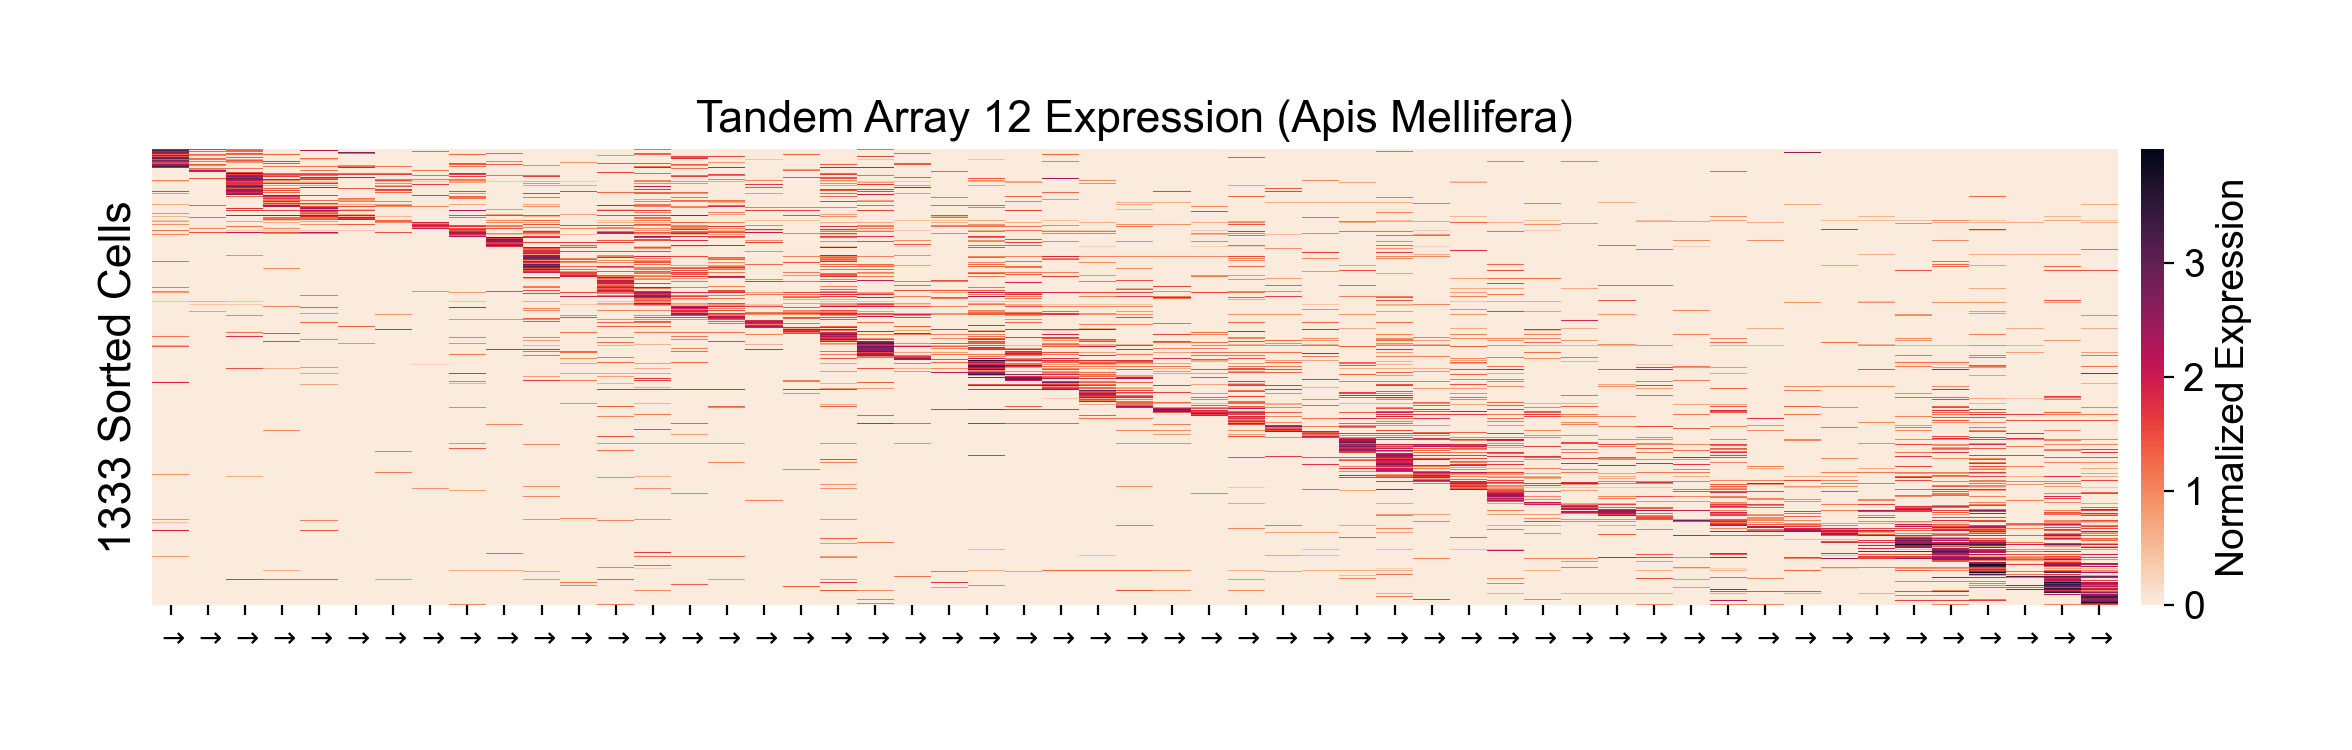

In [209]:
TA = 12

subset = or_db[or_db.tandem_array == TA]
genes = subset.gene_name_snrna.values
cells = adata[adata.obs['tandem_array_cluster'] == str(TA)]
expression = pd.DataFrame(cells[:, genes].X.toarray(), columns=genes, index=cells.obs_names)
expression['top_or'] = expression.idxmax(axis=1)
expression['top_or'] = pd.Categorical(expression['top_or'], categories=genes, ordered=True)
expression = expression.sort_values('top_or', ascending=True)


# Plot a heatmap of the expression data, with or_db gene order on the x axis and expression on the y axis
white_plotting()
fig, ax = plt.subplots(1, 1, figsize=(15, 3))
sns.heatmap(expression.iloc[:, :-1], cmap=sns.color_palette("rocket_r", as_cmap=True), ax=ax, xticklabels=True, yticklabels=False, cbar_kws={'label': 'Normalized Expression', 'pad': 0.01})
ax.set_ylabel(f'{cells.shape[0]} Sorted Cells', fontsize=16)
ax.set_xlabel('')
plt.title(f'Tandem Array {TA} Expression (Apis Mellifera)', fontsize=16)

# Modify the x-tick labels: Remove Or5- prefix and add orientation
xticks = ax.get_xticks()
xticklabels = subset.gene_name.values
#xticklabels = [f"{x} \n {tr.get_gene(x).strand}" for x in xticklabels]
xticklabels = [f"{tr.get_gene(x).strand}" for x in xticklabels]
#xticklabels = [re.sub('HsOr','',x) for x in xticklabels]
xticklabels = [re.sub(r'(-)', r'$\\leftarrow$', x) for x in xticklabels]
xticklabels = [re.sub(r'(\+)', r'$\\rightarrow$', x) for x in xticklabels]
ax.set_xticklabels(xticklabels)
plt.xticks(rotation=0, fontsize=10)
ax.grid(False)
plt.show()

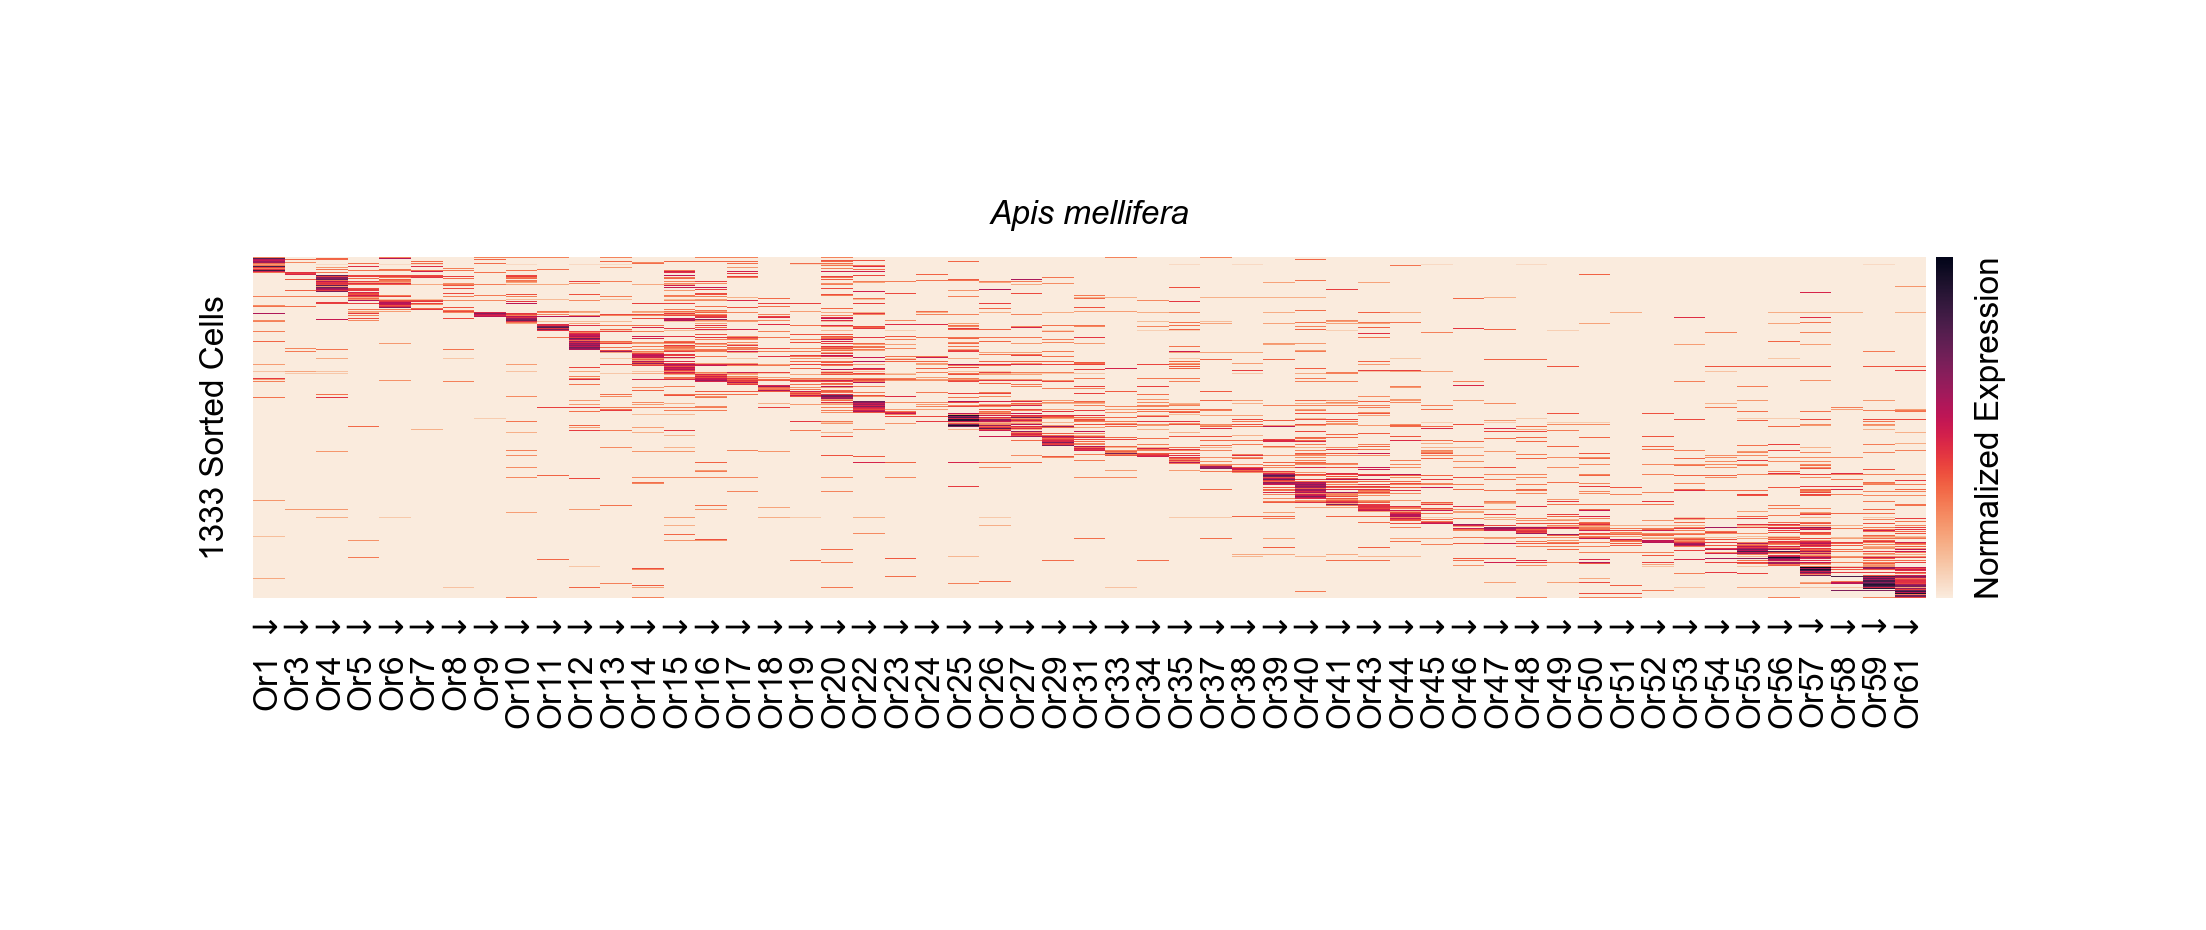

In [57]:
TA = 12

subset = or_db[or_db.tandem_array == TA]
genes = subset.gene_name_snrna.values
cells = adata[adata.obs['tandem_array_cluster'] == str(TA)]
expression = pd.DataFrame(cells[:, genes].X.toarray(), columns=genes, index=cells.obs_names)
expression['top_or'] = expression.idxmax(axis=1)
expression['top_or'] = pd.Categorical(expression['top_or'], categories=genes, ordered=True)
expression = expression.sort_values('top_or', ascending=True)

# Plot a heatmap of the expression data, with or_db gene order on the x axis and expression on the y axis
white_plotting()
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']
fig, ax = plt.subplots(1, 1, figsize=(5.5, 1.75), dpi=200)
sns.heatmap(expression.iloc[:, :-1], 
            cmap=sns.color_palette("rocket_r", as_cmap=True), 
            ax=ax, 
            xticklabels=True, 
            yticklabels=False, 
            cbar_kws={'pad': 0.005}
            )

cbar = ax.collections[0].colorbar
cbar.set_ticks([])
cbar.set_label('Normalized Expression', fontsize=6) 

ax.set_ylabel(f'{cells.shape[0]} Sorted Cells', fontsize=6)
ax.set_xlabel('')
ax.set_title(f'Apis mellifera', fontsize=6, style='italic')

# Modify the x-tick labels: Remove Or5- prefix and add orientation
gene_names = subset.gene_name.values
alt_names = subset.alt_name.values
#$\it{text you want to show in italics}$
xticklabels = [f"{alt_names[i]} {tr.get_gene(gene_names[i]).strand}" for i in range(len(gene_names))]
xticklabels = [re.sub(r'(-)', r'$\\uparrow$', x) for x in xticklabels]
xticklabels = [re.sub(r'(\+)', r'$\\downarrow$', x) for x in xticklabels]
ax.set_xticklabels(xticklabels)
plt.xticks(rotation=90, fontsize=6)
ax.xaxis.set_ticks_position('none')
ax.tick_params(axis='x', which='major', pad=0)
ax.grid(False)

plt.tight_layout()
plt.savefig(f"/Users/giacomo.glotzer/Desktop/Rockefeller/Kronauer/lncRNA Paper/figure_pdfs/Amell-T12-staircase.pdf", format="pdf", pad_inches=0, bbox_inches=0, transparent=False)

plt.show()

# Coexpression

In [58]:
# Make a dataframe with cell ID in a column and individual columns for each OR 
cell_or_expression = pd.DataFrame(index=adata.obs.index, columns=or_db.gene_name_snrna)
for i, row in or_db.iterrows(): 
    cell_or_expression[row.gene_name_snrna] = adata[:,row['gene_name_snrna']].X.toarray().flatten()

# Drop Or2 from cell_or_expression
cell_or_expression = cell_or_expression.drop(columns='Or2')

In [59]:
# Sort by nine_exon 
or_db['ta_size'] = or_db['ta_size'].astype(int)
or_db = or_db.sort_values(by=['ta_size'])
all_TAs = or_db[or_db['ta_size']>1]['tandem_array'].unique()

# Make a matrix to store the counts of coexpression between each pair of TAs
TA_coexpression_counts = np.zeros((len(all_TAs), len(all_TAs)))
for i, TA_1 in enumerate(all_TAs): 
    for j, TA_2 in enumerate(all_TAs):
        if i > j: 
            # Get the ORs in TA1 and TA2
            ORs_TA_1 = or_db.loc[or_db.tandem_array == TA_1, 'gene_name_snrna'] 
            ORs_TA_2 = or_db.loc[or_db.tandem_array == TA_2, 'gene_name_snrna'] 

            # Get the number of cells expressing ORs from TA1 and TA2 
            num_cells_TA1 = cell_or_expression.loc[(cell_or_expression[ORs_TA_1] > 0).any(axis=1)].shape[0] 
            num_cells_TA2 = cell_or_expression.loc[(cell_or_expression[ORs_TA_2] > 0).any(axis=1)].shape[0] 

            # Get the number of cells expressing ORs from both TA1 and TA2
            num_cells_TA1_and_TA2_p1 = cell_or_expression.loc[(cell_or_expression[ORs_TA_1] > 0).any(axis=1) & (cell_or_expression[ORs_TA_2] > 0).any(axis=1)].shape[0] 
            TA_coexpression_counts[i, j] = num_cells_TA1_and_TA2_p1 / (num_cells_TA1 + num_cells_TA2 - num_cells_TA1_and_TA2_p1)


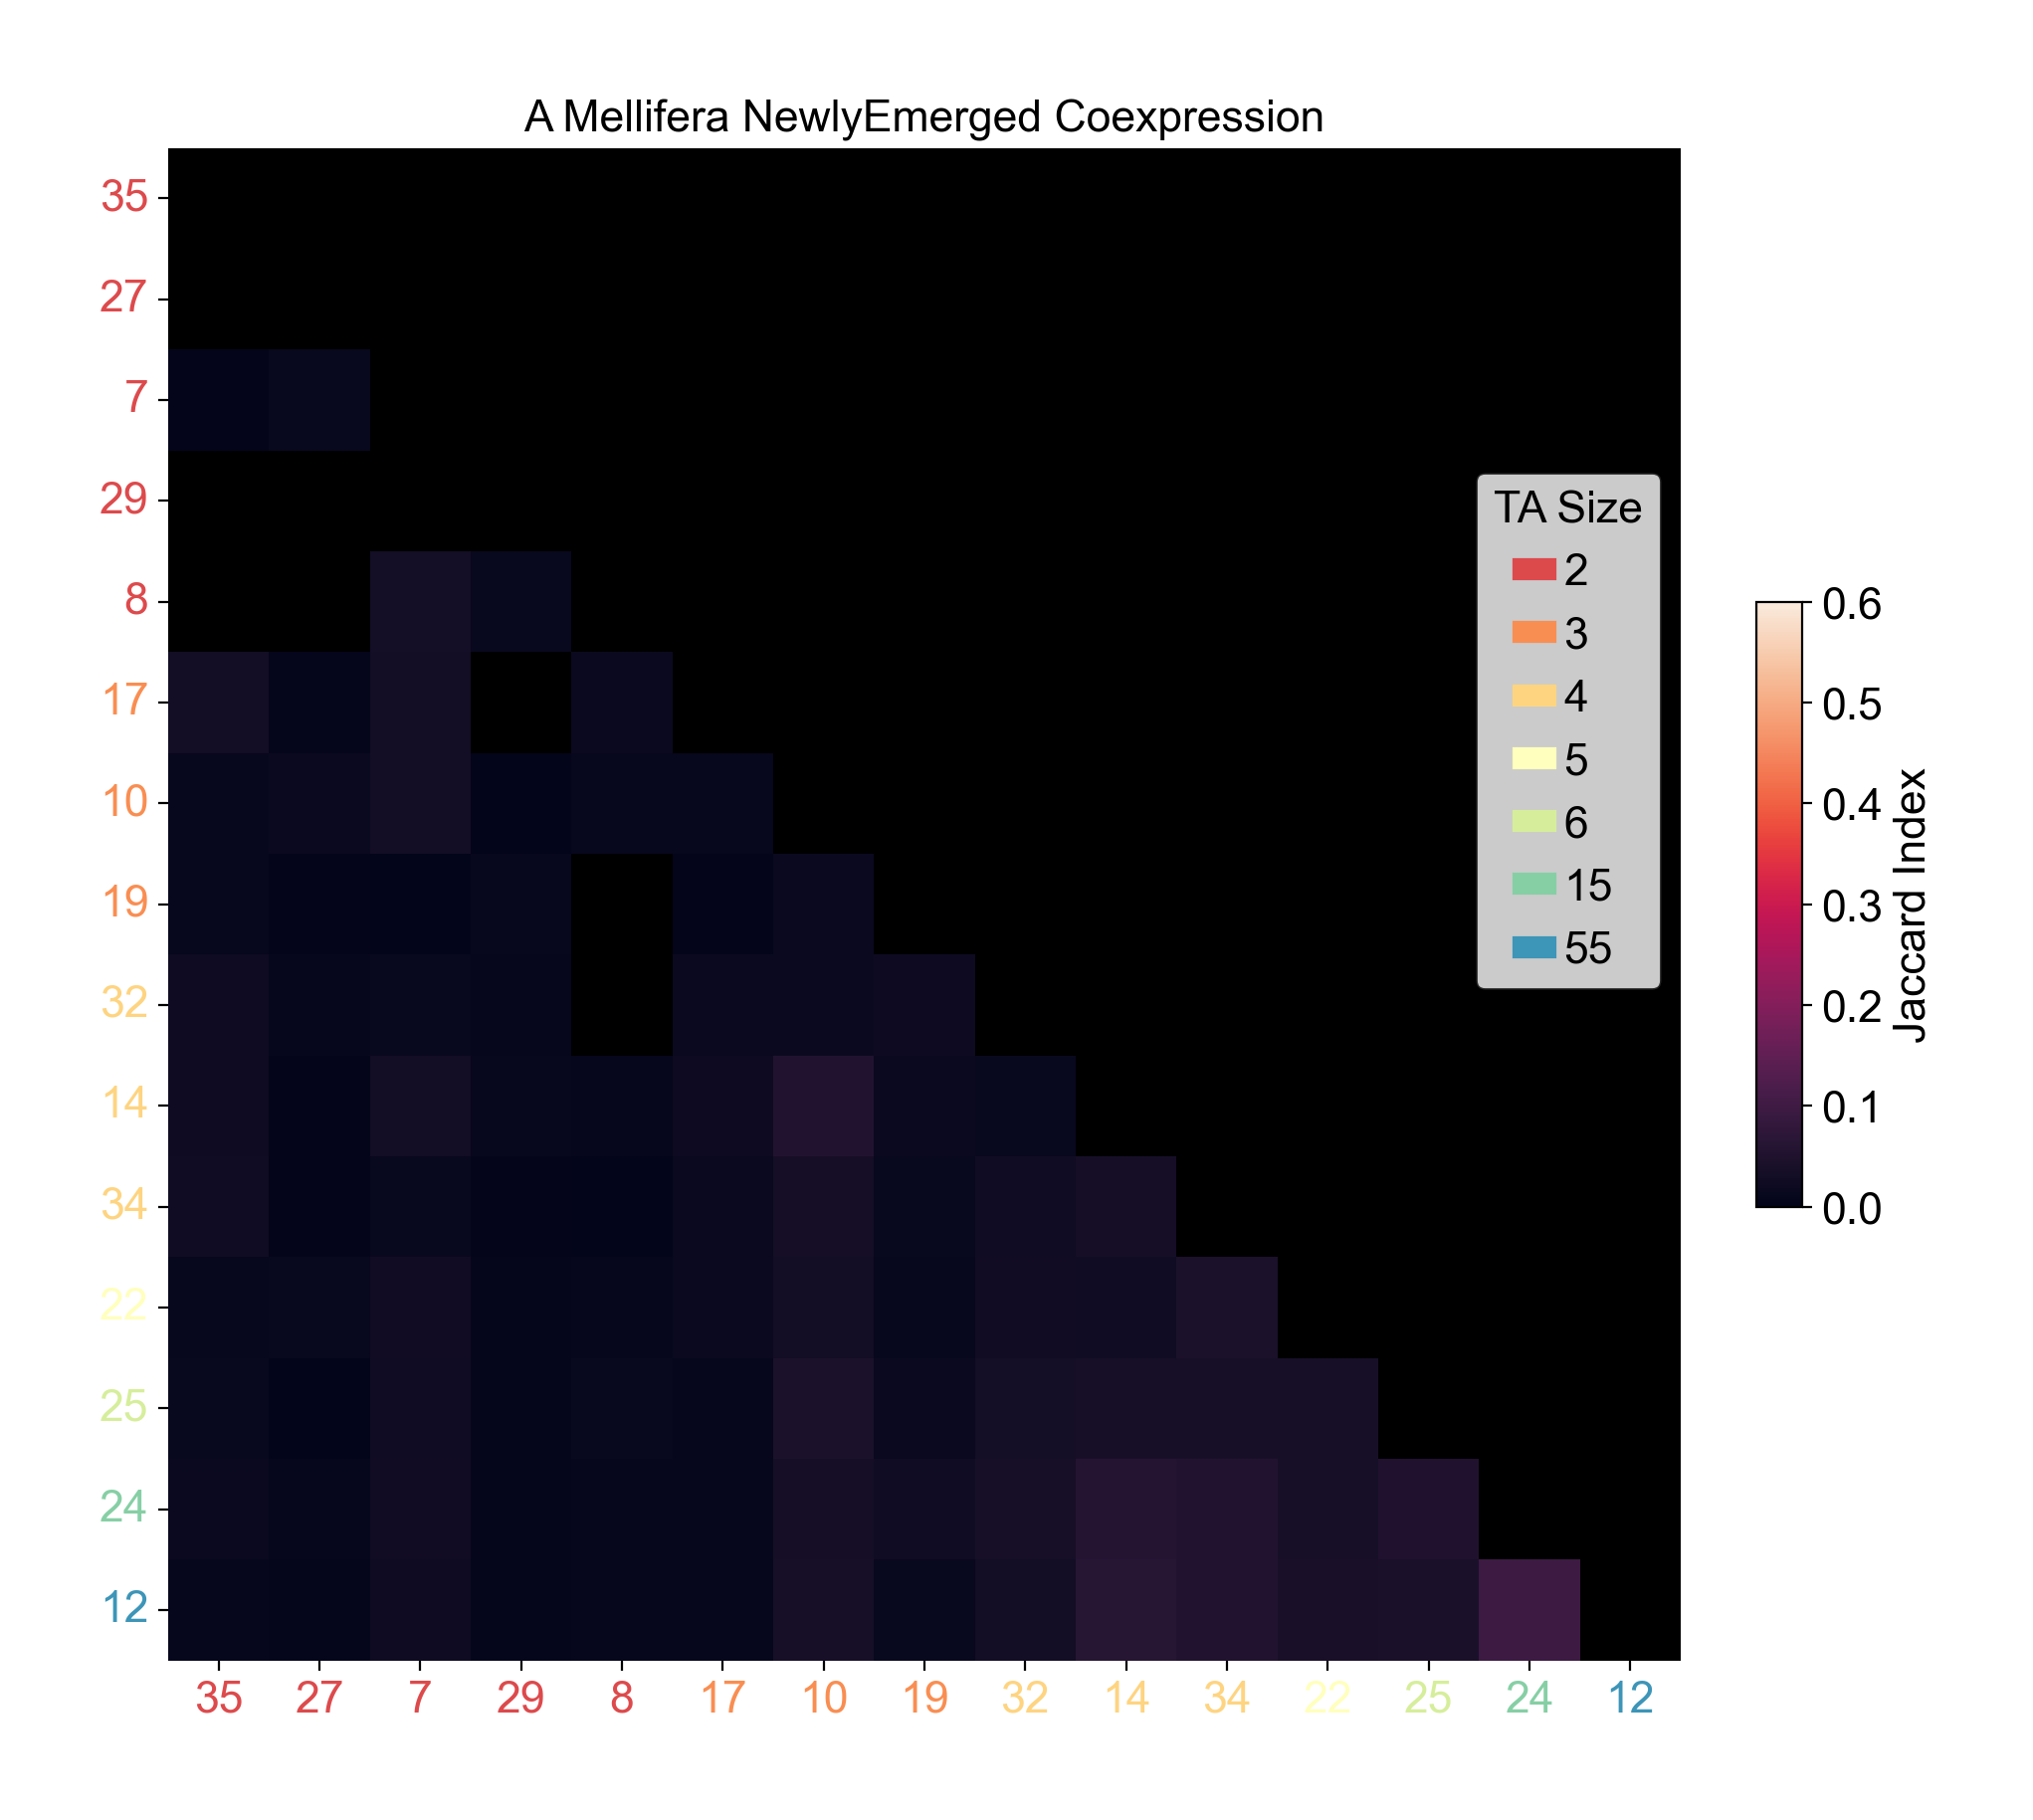

In [60]:
# Plot the heatmap
f, ax = plt.subplots(1, 1, figsize=(10, 10))
fontsize = 16

# Load the original 'rocket' colormap
original_cmap = sns.color_palette("rocket", as_cmap=True)

# Create a new colormap with black as the first color
colors = [(0, 0, 0)] + [original_cmap(i) for i in range(256)]  # Start with black
custom_cmap = LinearSegmentedColormap.from_list("modified_rocket", colors)

sns.heatmap(
    TA_coexpression_counts, 
    ax=ax, 
    vmin=0, vmax=0.6, cmap=custom_cmap, square=True, 
    xticklabels=all_TAs, yticklabels=all_TAs, cbar=False
)
ax.set_title(f'A Mellifera {timepoint} Coexpression', fontsize=fontsize)

# Create a ScalarMappable for the colorbar
sm = plt.cm.ScalarMappable(cmap='rocket', norm=plt.Normalize(vmin=0, vmax=0.6))

# Add an inset axis to place the colorbar
cbar_ax = ax.inset_axes([1.05, 0.3, 0.03, 0.4])  # Adjust [x, y, width, height] for placement
cbar = plt.colorbar(sm, cax=cbar_ax, orientation='vertical')
cbar.set_label('Jaccard Index', fontsize=fontsize)
cbar.ax.tick_params(labelsize=fontsize)

# Assign colors for each chromosome 
all_TAs_size = [or_db[or_db['tandem_array'] == TA1]['ta_size'].values[0] for TA1 in all_TAs]
unique_sizes = sorted(set(all_TAs_size))
colors = sns.color_palette("Spectral", len(unique_sizes))
color_dict = dict(zip(unique_sizes, colors))

xticks = ax.get_xticklabels()
yticks = ax.get_yticklabels()
for i, (xtick, ytick) in enumerate(zip(xticks, yticks)):
    color = color_dict[all_TAs_size[i]]
    xtick.set_color(color)
    ytick.set_color(color)
ax.tick_params(axis='x', labelsize=fontsize, rotation=0)
ax.tick_params(axis='y', labelsize=fontsize, rotation=0)

# Add legend
legend_elements = [Line2D([0], [0], color=color, lw=8, label=label)
                   for label, color in color_dict.items()]
ax.legend(
    handles=legend_elements, 
    title='TA Size',
    fontsize=fontsize, 
    title_fontsize=fontsize,
    bbox_to_anchor=(0.85, 0.8), 
    loc='upper left'
)

plt.show()

## Ranked TA Data 
- Make one single dataframe per dataset containing expression data for all cells 
- For each cell, sort the ORs by expression, then map the ORs to tandem arrays, then take the top 10 **unique** highest-expressing TAs 
- For each TA, save not only the expression of hte highest-expressing OR, but also the expression of the other ORs in the tandem array 
- Save the index of the OR in the TA relative to the highest-expressing valence OR in `ta_index_rel`
- Save the rank of the TA in `ta_rank` 
- Save the expression of each OR in each cell in `expression` 
- Save the cell ID in `cell_index` 
- Exclude T72 which includes Orco 

In [61]:
results_list = []  # Use a list to collect results efficiently

max_TAs = 10 # Number of top TAs to consider

# Precompute OR-to-Tandem Array and OR-to-TA Index mappings
or_db = or_db.sort_values(by=['scaffold', 'start'])
or_to_ta = or_db.set_index('gene_name_snrna')['tandem_array'].to_dict()
or_to_ta_index = or_db.set_index('gene_name_snrna')['ta_index'].to_dict()
or_to_strand = or_db.set_index('gene_name_snrna')['strand'].to_dict()

# Iterate over cells
for cell in tqdm(cell_or_expression.index, desc='Processing Cells'):
    # Get the ORs sorted by expression
    cell_expression = cell_or_expression.loc[cell]
    
    # get nonzero expression 
    cell_expression_nonzero = cell_expression[cell_expression > 0]

    # nonzero ORs sorted by expression, descending, top to bottom 
    ORs_sorted = cell_expression_nonzero.sort_values(ascending=False).index.values

    # Map ORs to Tandem Arrays and filter for valid entries
    TAs_sorted = pd.Series([or_to_ta[or_] for or_ in ORs_sorted])

    # Get unique TAs while preserving order 
    # pd.unique preserves order
    TAs_sorted_unique = pd.unique(TAs_sorted)

    # Get the top max_TAs TAs if there are more than max_TAs
    TAs_sorted_unique_top = TAs_sorted_unique[:max_TAs]

    # Get the highest expressing OR for each unique TA 
    valence_ORs = [ORs_sorted[np.where(TAs_sorted == TA)[0][0]] for TA in TAs_sorted_unique_top]

    # Process each top OR
    for i, or_ in enumerate(valence_ORs):
        or_index = or_to_ta_index[or_]
        or_TA = or_to_ta[or_]
        or_strand_multiplier = -1 if or_to_strand[or_] == "-" else 1

        # Filter Tandem Array ORs
        TA_ORs = or_db[or_db['tandem_array'] == or_TA].copy()
        TA_ORs['ta_index_rel'] = TA_ORs['ta_index'] - or_index  # Adjust TA indices relative to the top OR
        TA_ORs['ta_index_rel'] = TA_ORs['ta_index_rel'] * or_strand_multiplier # Invert the indices if strand is "-" 
        
        # Add expression values and cell information
        TA_ORs['expression'] = cell_expression[TA_ORs['gene_name_snrna']].values
        TA_ORs['cell_index'] = cell
        TA_ORs['ta_rank'] = i

        # sort by relative order 
        TA_ORs = TA_ORs.sort_values(by='ta_index_rel', ascending=True).reset_index(drop=True)

        # Append relevant columns to the results list
        
        results_list.append(
            TA_ORs[['cell_index', 'ta_rank', 'tandem_array', 'gene_name_snrna', 'ta_index_rel', 'expression', 'strand', 'ta_size', 'ta_index']]
        )

# Combine all results into a DataFrame
results = pd.concat(results_list, ignore_index=True)
results.ta_index_rel = results.ta_index_rel.astype(int)

Processing Cells: 100%|██████████| 3542/3542 [00:04<00:00, 760.49it/s]


In [62]:
results.ta_index_rel = results.ta_index_rel.astype(int)

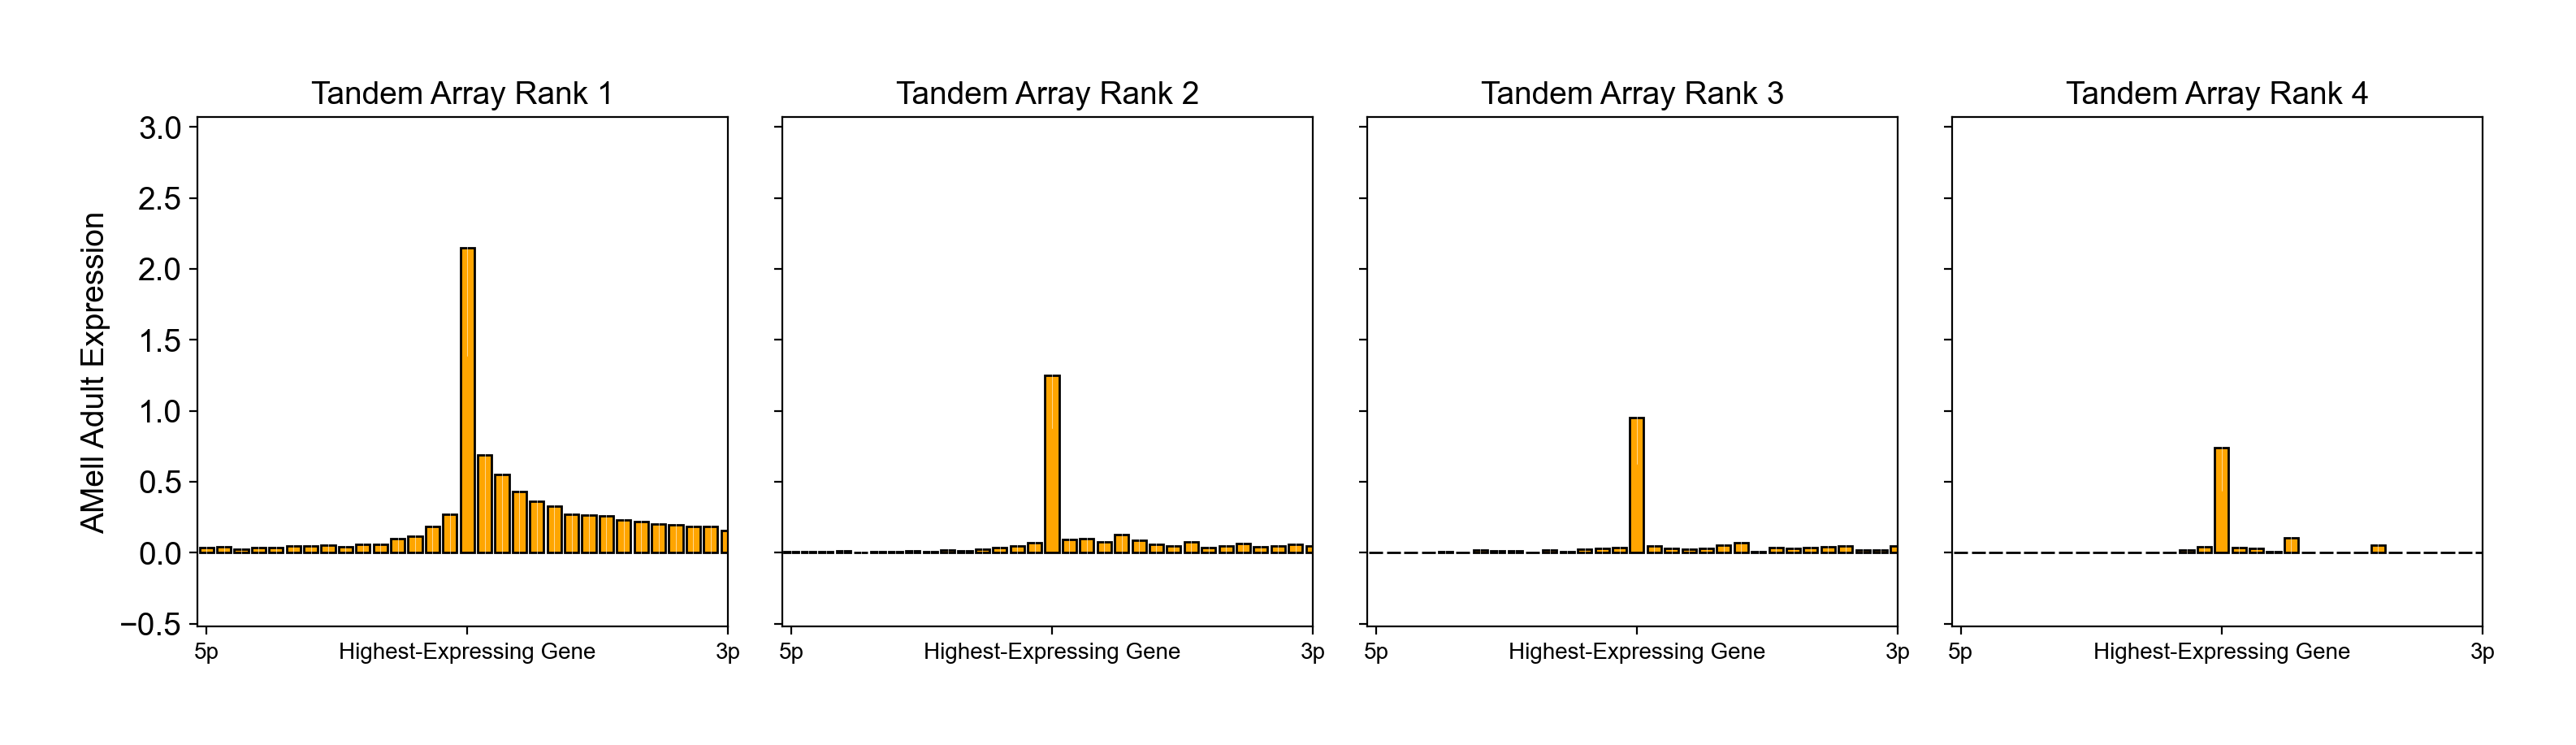

In [63]:
# Make 3 subplots, plotting ta_rank 0-2, average expression for each ta_index (only plot -10 to +10) 
num_TAs = 4
num_ORs = 15
f, ax = plt.subplots(1, num_TAs, figsize=(15, 4), sharey=True, sharex=True)
ax = ax.flatten()
for i in range(num_TAs):
    # Plot P1 
    ta_results = results[results['ta_rank'] == i]
    ta_results = ta_results[(ta_results['ta_index_rel'] >= -num_ORs) & (ta_results['ta_index_rel'] <= num_ORs)]
    sns.barplot(data=ta_results, x='ta_index_rel', y='expression', ax=ax[i], errcolor='white', facecolor='orange', edgecolor='black', ci='sd', errwidth=0.2)
    ax[i].set_title(f'Tandem Array Rank {i+1}')
    ax[i].set_xlabel('')
    ax[i].tick_params(axis='x', labelsize=10)

    # Set xticks to 5p, 0, and 3p 
    ax[i].set_xticks([0, num_ORs, 2*num_ORs])
    ax[i].set_xticklabels(['5p', 'Highest-Expressing Gene', '3p'])

ax[0].set_xlabel('')
ax[0].set_ylabel('AMell Adult Expression')
plt.tight_layout()
plt.show()

#### Calculate the proportion of cells expressing from TA with rank > 1 
- Normalize by the number of cells in each dataset 
- Exclude ta_rank 0 (valence OR tandem array) 
- Exclude small TAs 
- Order by TA size

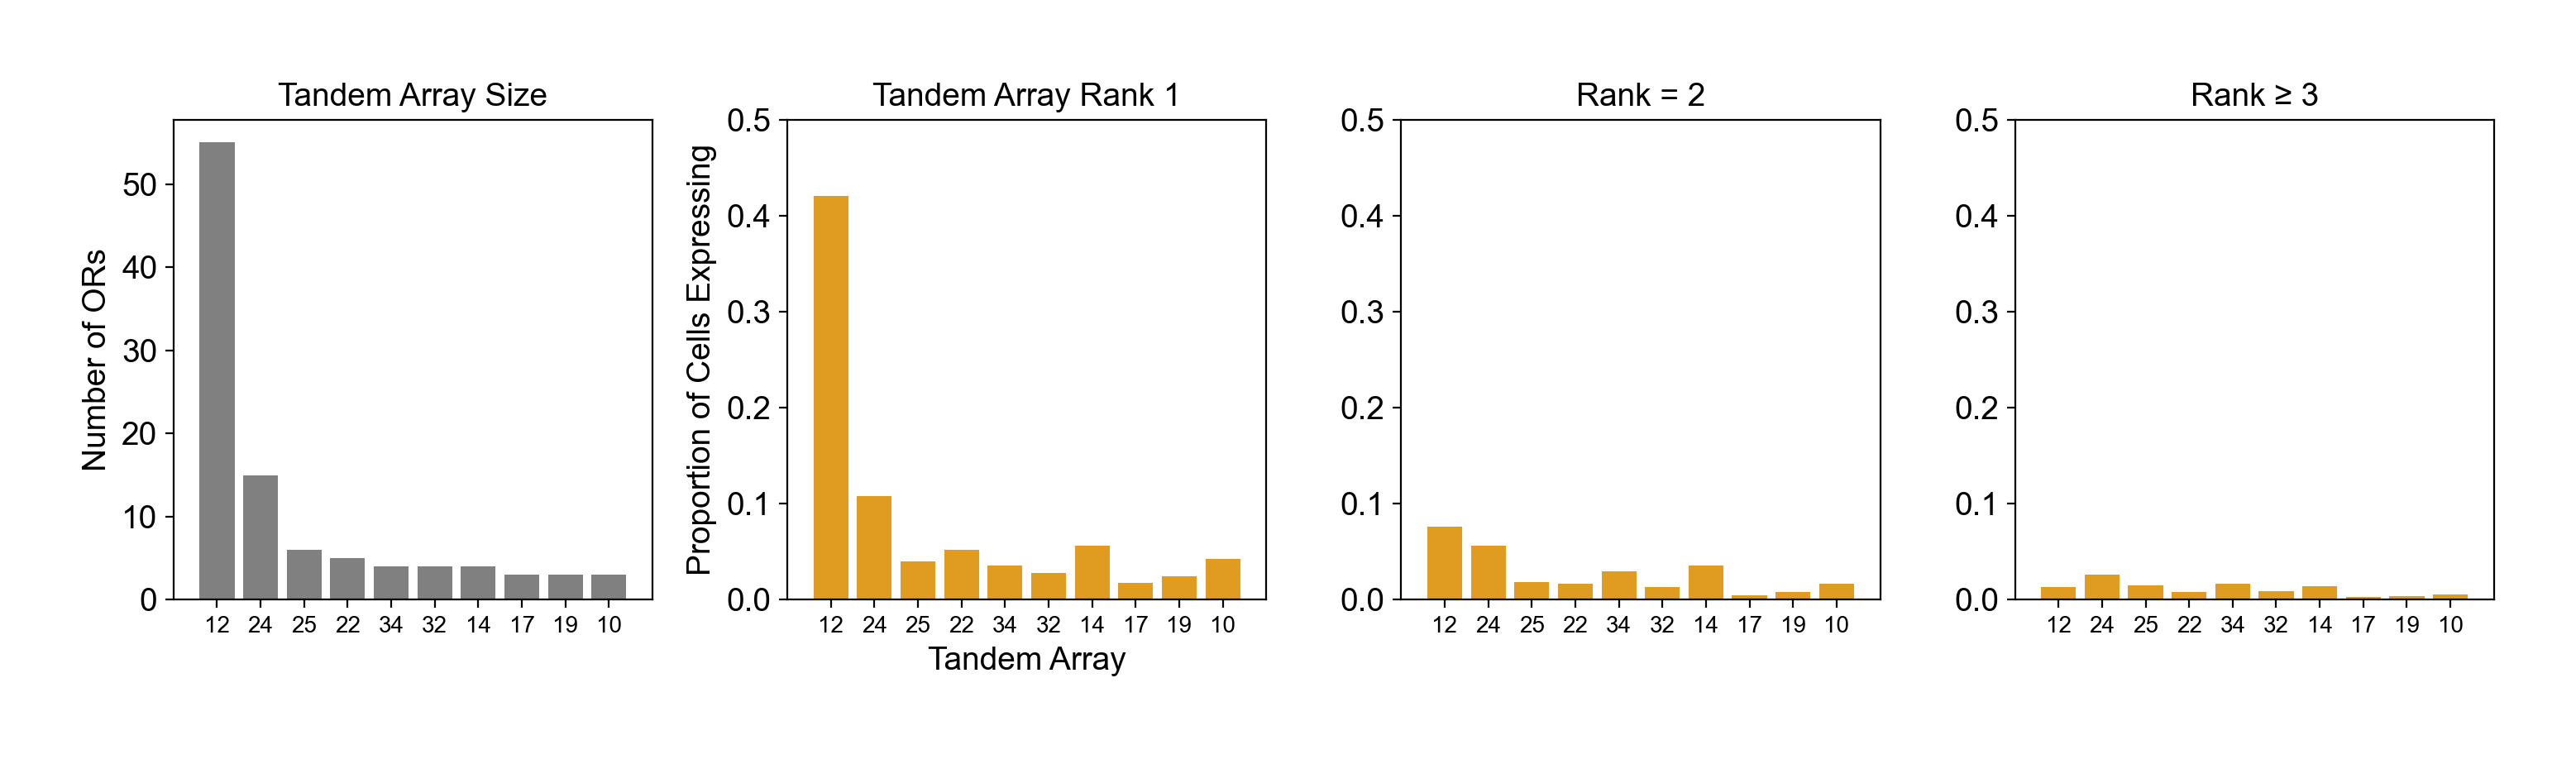

In [64]:
# Plot large TAs on x, plot # cells expressing from that TA with rank 2 on y, color by P1 and P14
or_db_sorted = or_db.sort_values(by='ta_size', ascending=False)
large_TAs = or_db_sorted[or_db_sorted['ta_size'] > 2]['tandem_array'].unique()

n_cells = results['cell_index'].nunique()

f, ax = plt.subplots(1, 4, figsize=(15, 4))
ax = ax.flatten()

n_ranks = 3

rank_thresholds = np.arange(n_ranks)

for rank_thresh in rank_thresholds: 

    # Filter 
    if rank_thresh < n_ranks - 1: 
        results_filtered = results[(results['tandem_array'].isin(large_TAs)) & (results['ta_rank'] == rank_thresh)]
        ax[rank_thresh+1].set_title(f'Rank = {rank_thresh+1}')
    else: 
        results_filtered = results[(results['tandem_array'].isin(large_TAs)) & (results['ta_rank'] >= rank_thresh)]
        ax[rank_thresh+1].set_title(f'Rank ≥ {rank_thresh+1}')

    # Get the number of cells expressing from each TA
    num_cells = results_filtered.groupby(['tandem_array'])['cell_index'].nunique().reset_index()

    # Rename the column
    num_cells = num_cells.rename(columns={'cell_index': 'num_cells'})

    # Divide by the total number of cells to get the proportion
    num_cells['num_cells'] = num_cells['num_cells'] / n_cells

    # Add the TA size to the dataframe
    num_cells['ta_size'] = num_cells['tandem_array'].apply(lambda x: or_db.loc[or_db['tandem_array'] == x, 'ta_size'].values[0])

    # Sort 
    num_cells = num_cells.sort_values(by=['ta_size', 'tandem_array'])

    # Bar plot of num_cells vs tandem_array, Group hue 
    sns.barplot(data=num_cells, x='tandem_array', y='num_cells', palette=['orange'], order=large_TAs, ax=ax[rank_thresh+1], legend=None)
    ax[rank_thresh+1].set_xlabel('')
    ax[rank_thresh+1].set_ylabel('')
    ax[rank_thresh+1].tick_params(axis='x', labelsize=10)
    ax[rank_thresh+1].set_xlim(-1, len(large_TAs))
    ax[rank_thresh+1].set_ylim(0, 0.5)

# Plot ta_size vs tandem_array on first plot
sns.barplot(data=num_cells, x='tandem_array', y='ta_size', color='grey', ax=ax[0], order=large_TAs)
ax[0].set_xlabel('')
ax[0].set_ylabel('Number of ORs')
ax[0].tick_params(axis='x', labelsize=10)
ax[0].set_xlim(-1, len(large_TAs))
ax[0].set_title("Tandem Array Size")

# Add legend to first plot
ax[1].set_title('Tandem Array Rank 1')
ax[1].set_ylabel('Proportion of Cells Expressing')
ax[1].set_xlabel('Tandem Array')

plt.tight_layout()
plt.show()

## Histograms of Probability of Each OR Being the Top OR 

Theoretical Probability: 0.007518796992481203
Identified 131 Valence ORs


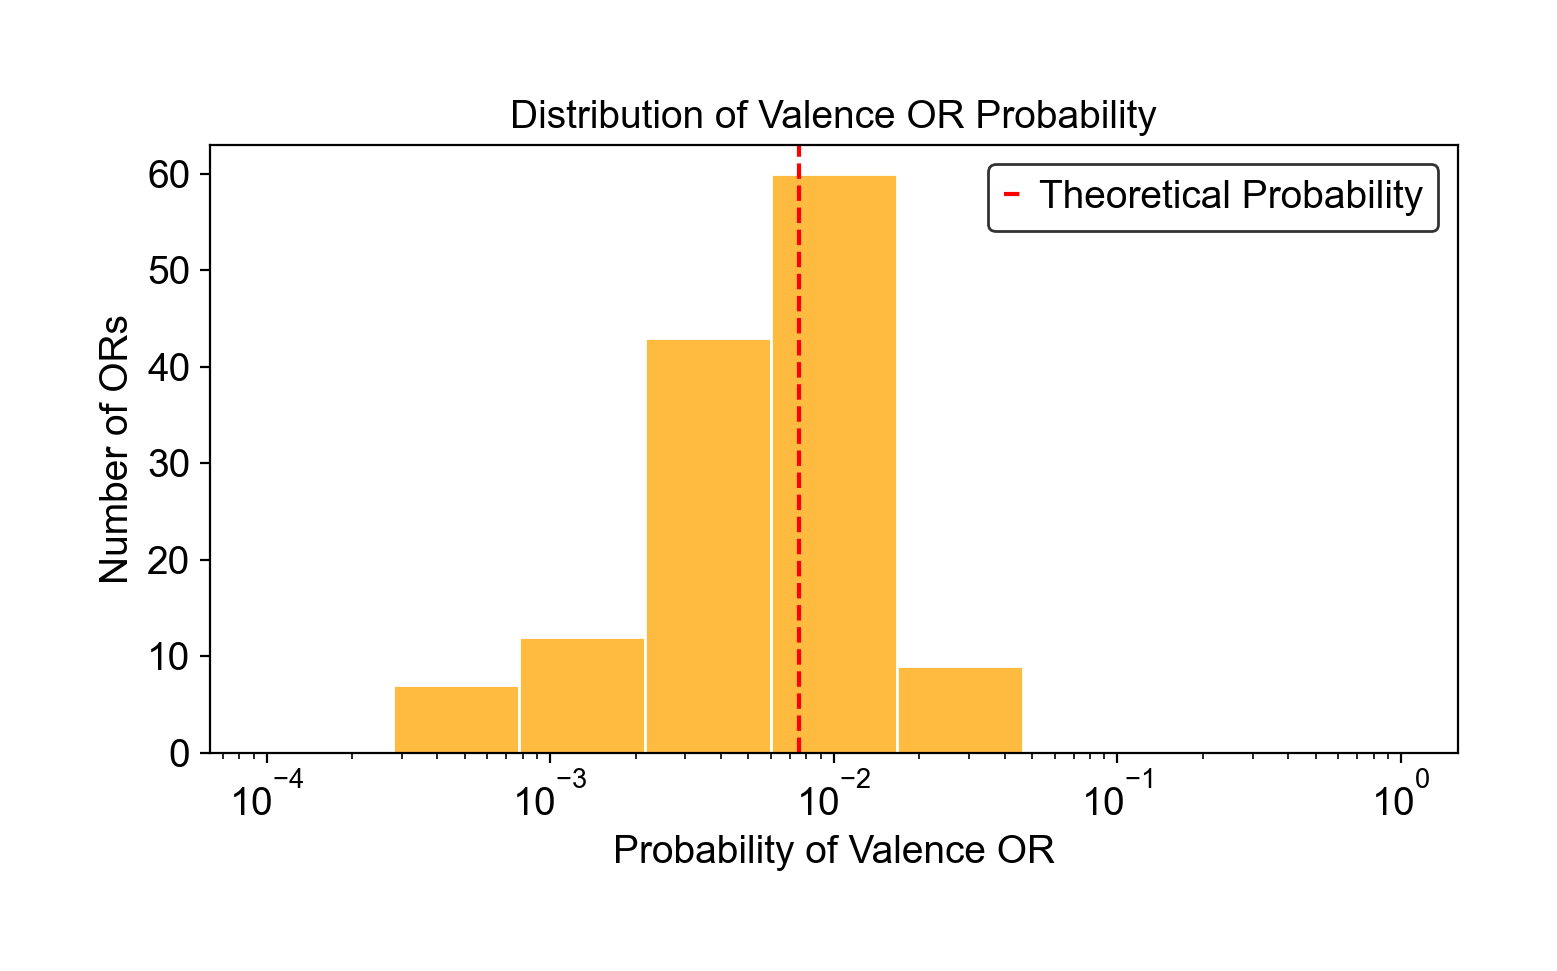

In [65]:
plt.figure(figsize=(8, 4))

# Calculate theoretical probability 
total_ORs = or_db.shape[0]
prob = 1 / total_ORs
print(f"Theoretical Probability: {prob}")
# plot line
plt.axvline(x=prob, color='red', linestyle='--', label='Theoretical Probability')

# Make bins 
bins = np.logspace(-4, 0, 10)

# P1 
ta_results = results[(results['ta_index_rel'] == 0) & (results['ta_rank'] == 0)] # Valence ORs of Top TA 
genes, counts = ta_results['gene_name_snrna'].value_counts().index, ta_results['gene_name_snrna'].value_counts().values
counts = counts / counts.sum()
print(f"Identified {len(genes)} Valence ORs")
sns.histplot(data=counts, color='orange', bins=bins, edgecolor='white', linewidth=1)

plt.xlabel('Probability of Valence OR') 
plt.xscale('log')
plt.ylabel('Number of ORs')
plt.legend()
plt.title('Distribution of Valence OR Probability')
plt.show()

## Assess Spread Across the TA 

In [66]:
# ta_index_2 represents distance from the 5' end of the tandem array 
results['dist_5p'] = results.apply(lambda x: x['ta_size'] - x['ta_index'] + 1 if x['strand'] == '-' else x['ta_index'], axis=1)

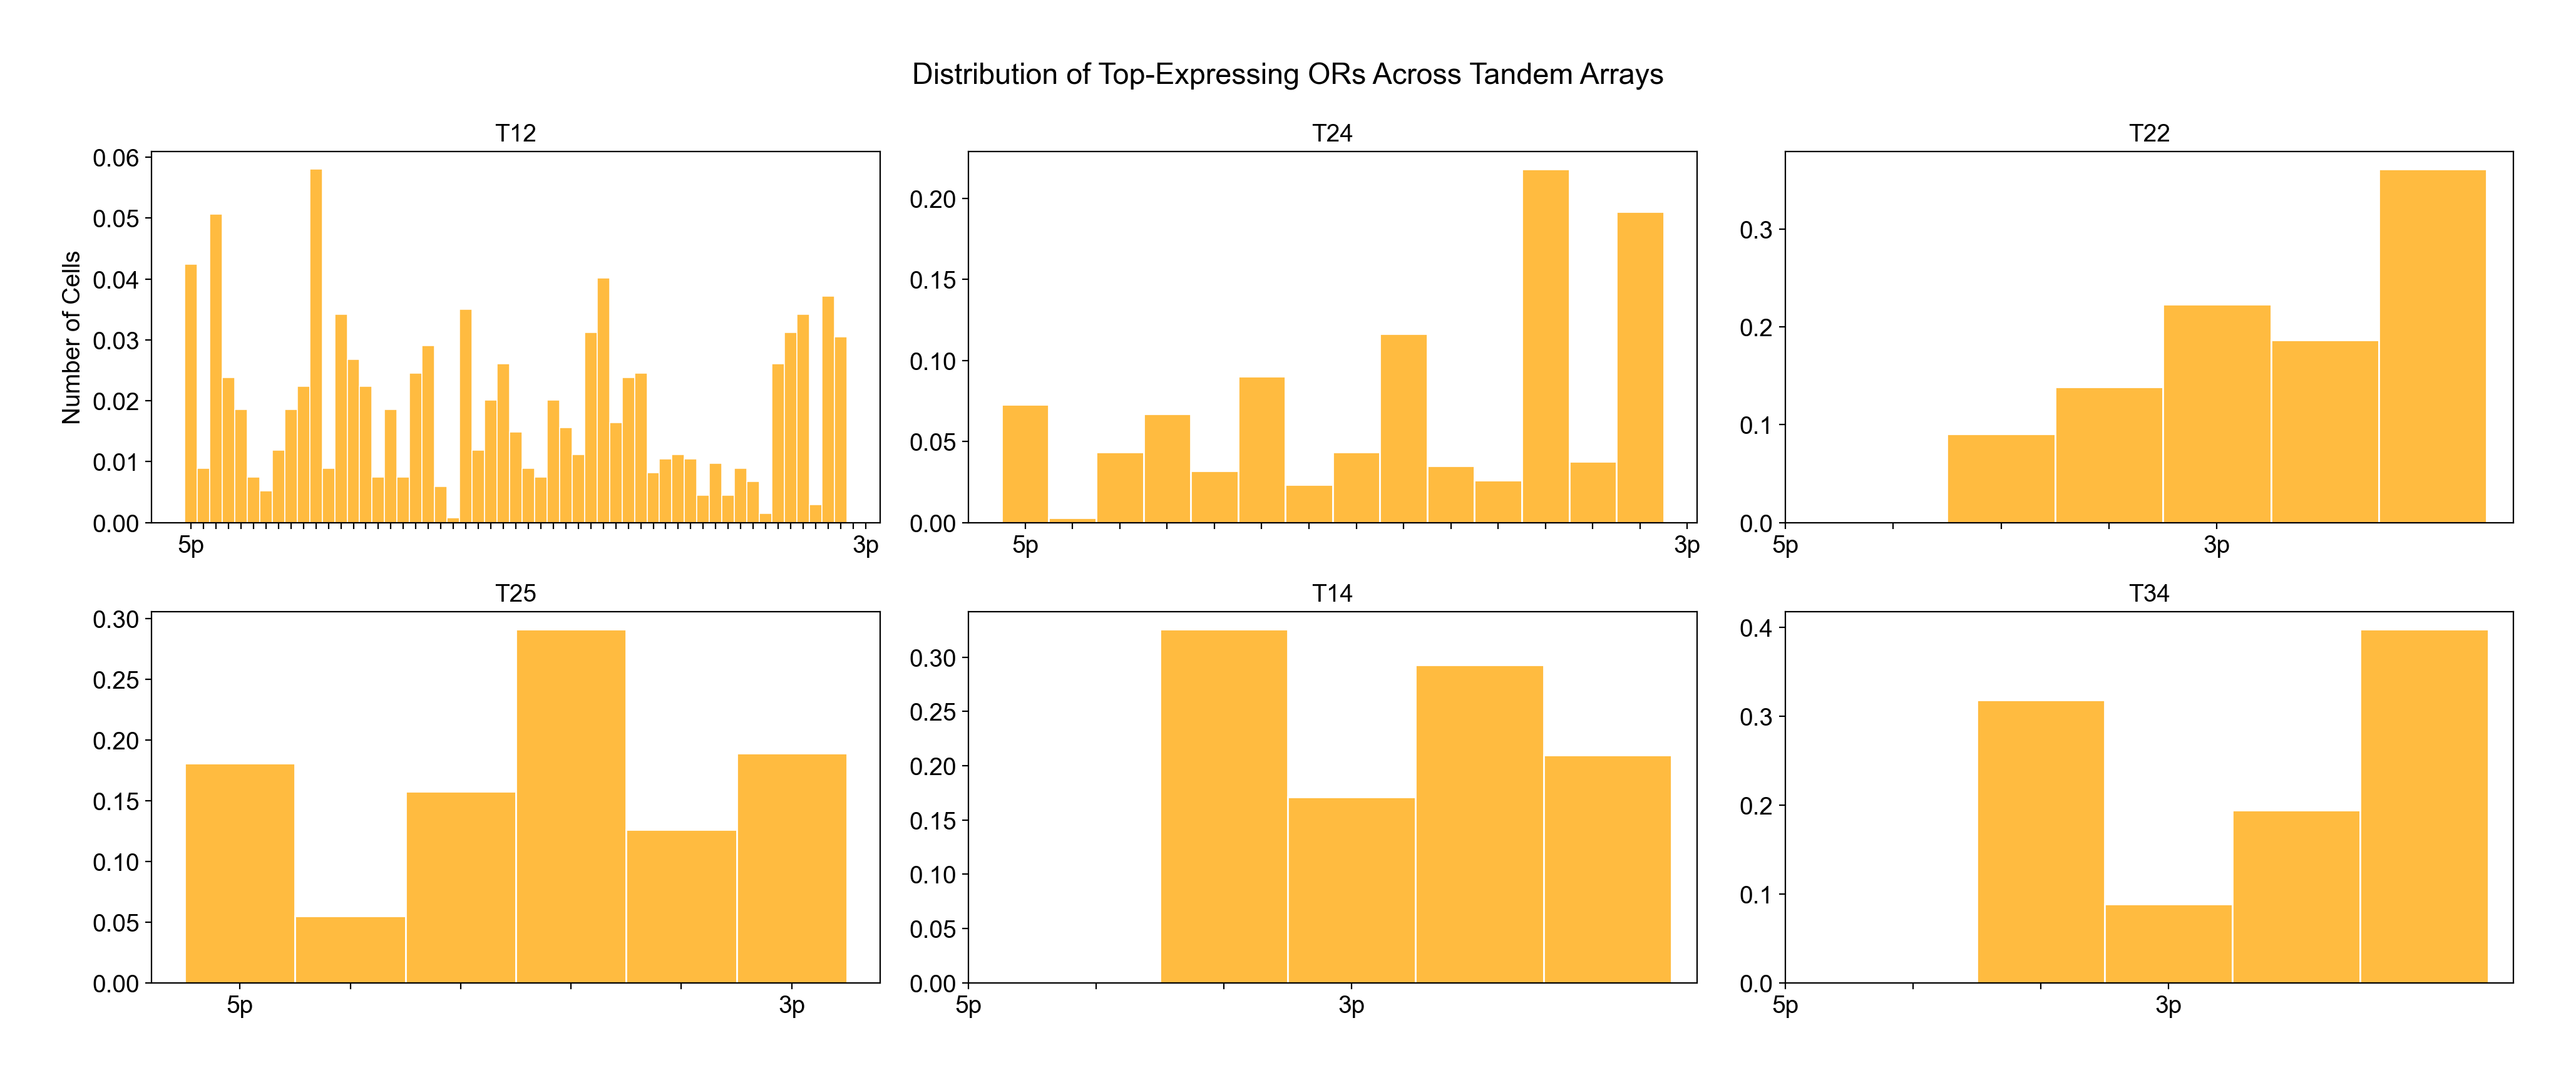

In [67]:
# For each tandem array, plot the distribution of dist_5p where ta_index_rel is 0 
# Get a list of TAs sorted by size 
top_12_tas = results[results['ta_rank'] == 0]['tandem_array'].value_counts().index[:6]

f, ax = plt.subplots(2, 3, figsize=(20, 8))
ax = ax.flatten()
for i, TA in enumerate(top_12_tas):
    ta_results = results[(results['tandem_array'] == TA) & (results['ta_index_rel'] == 0) & (results['ta_rank'] == 0)]
    sns.histplot(data=ta_results, x='dist_5p', ax=ax[i], color='orange', edgecolor='white', binwidth=1, discrete=True, stat="probability")
    ta_size = ta_results['ta_size'].iloc[0]
    ax[i].set_xticks(range(ta_size))
    xticklabels = ['5p'] + [''] * (ta_size - 2) + ['3p']
    ax[i].set_xticklabels(xticklabels)
    ax[i].set_title(f'T{TA}')
    ax[i].set_xlabel('')
    ax[i].set_ylabel('')


ax[0].set_ylabel('Number of Cells')
plt.suptitle('Distribution of Top-Expressing ORs Across Tandem Arrays')
plt.tight_layout()
plt.show()

# lncRNA TSS Analysis

In [59]:
all_genes = [tr.get_gene(gene) for gene in tr.genes.keys() if len(tr.get_gene(gene).transcripts) > 0]
all_lncRNAs = [gene for gene in all_genes if gene.transcripts[0].biotype == 'lnc_RNA']
len(all_lncRNAs), len(all_genes)

(1858, 12356)

In [60]:
def overlapping(chr1, start1, end1, chr2, start2, end2):
    return chr1 == chr2 and not (end1 < start2 or end2 < start1)

In [61]:
# Find nested lncRNAs within TAs 
or_db_no_orco = or_db.loc[~or_db.gene_name.str.contains('Or2')].reset_index(drop=True)
TAs = or_db_no_orco['tandem_array'].unique()
nested_lncRNAs = [] 

for ta_ in TAs: 
    # Get bounds of tandem array 
    TA_genes = or_db_no_orco.loc[or_db_no_orco['tandem_array'] == int(ta_)]
    # sort by start
    TA_genes = TA_genes.sort_values(by='start').reset_index(drop=True)
    TA_genes = TA_genes['gene_name']
    TA_chromosome = tr.get_gene(TA_genes.iloc[0]).chromosome
    first_gene_bounds = tr.get_gene(TA_genes.iloc[0]).get_transcript_longest_bounds().get_bounds()
    last_gene_bounds = tr.get_gene(TA_genes.iloc[-1]).get_transcript_longest_bounds().get_bounds()
    TA_bounds = [first_gene_bounds[0], last_gene_bounds[1]]
    
    for lncRNA in all_lncRNAs: 
        lnc_start, lnc_end = lncRNA.get_transcript_longest_bounds().get_bounds()
        lnc_strand = lncRNA.strand 
        #if lnc_start >= TA_bounds[0] and lnc_end <= TA_bounds[1] and lncRNA.chromosome == TA_chromosome: 
        if overlapping(TA_chromosome, TA_bounds[0], TA_bounds[1], lncRNA.chromosome, lnc_start, lnc_end):
            lnc_size = lnc_end - lnc_start
            nested_lncRNAs.append({'gene_name': lncRNA.name, 'TA': ta_, 'TA_location': f"{TA_chromosome}:{TA_bounds[0]}-{TA_bounds[1]}", 'lnc_strand': lnc_strand, 'lnc_size': lnc_size, 'lnc_start': lnc_start, 'lnc_end': lnc_end})

nested_lncRNAs = pd.DataFrame(nested_lncRNAs)
nested_lncRNAs

gene_name  TA                    TA_location lnc_strand  lnc_size  \
0   LOC102656092  12   NC_037639.1:9976746-10152787          -      2812   
1   LOC102656676  12   NC_037639.1:9976746-10152787          -      3577   
2   LOC107966088  12   NC_037639.1:9976746-10152787          -     12206   
3   LOC107966089  12   NC_037639.1:9976746-10152787          -      4935   
4   LOC107966095  12   NC_037639.1:9976746-10152787          -      3415   
..           ...  ..                            ...        ...       ...   
6   LOC107966099  12   NC_037639.1:9976746-10152787          -     10192   
7   LOC107966100  12   NC_037639.1:9976746-10152787          -      2879   
8   LOC113218588  12   NC_037639.1:9976746-10152787          -      2491   
9   LOC113218603  12   NC_037639.1:9976746-10152787          -      4690   
10  LOC107965274  22  NC_037648.1:11116384-11140441          +      4903   

    lnc_start   lnc_end  
0    10067130  10069942  
1    10109678  10113255  
2    10046889  10059095  
3    10118308  10123243  
4    10095847  10099262  
..        ...       ...  
6     9980987   9991179  
7     9991212   9994091  
8    10100712  10103203  
9    10021401  10026091  
10   11128452  11133355  

[11 rows x 7 columns]

Filter for lncRNAs present in both single cell datasets

In [62]:
# Remove lncRNAs that are not in the data 
nested_lncRNAs['in_data'] = nested_lncRNAs['gene_name'].isin(adata.var.index)
nested_lncRNAs = nested_lncRNAs.loc[nested_lncRNAs['in_data']]
nested_lncRNAs = nested_lncRNAs.reset_index(drop=True)
nested_lncRNAs.shape

(11, 8)

Identify the two ORs that flank the lncRNA 

In [63]:
or_db_no_orco = or_db[~or_db['gene_name'].str.contains('Or2')]
or_db_no_orco.shape

(129, 16)

In [64]:
# For each nested lncRNA, find all ORs that are upstream or downstream of the lncRNA TSS within the TA 
lnc_associated_ORs = [] 

for i, row in nested_lncRNAs.iterrows():
    # Get ORs in the TA
    TA_genes = or_db_no_orco.loc[or_db_no_orco['tandem_array'] == int(row.TA), 'gene_name']
    ORs_of_interest = [] 
    # For each gene, check if it is upstream or downstream of the lncRNA
    for gene in TA_genes: 
        gene_obj = tr.get_gene(gene) 
        gene_start, gene_end = gene_obj.get_transcript_longest_bounds().get_bounds()
        gene_strand = gene_obj.strand
        # Verify that the OR and lncRNA are on opposite strands 
        if gene_strand == row.lnc_strand: 
            continue 
        if gene_strand == "-" and row.lnc_strand == "+": 
            if gene_end < row.lnc_start: 
                ORs_of_interest.append([gene, "upstream", row.lnc_start - gene_start, gene_start, gene_end, gene_strand])
            elif gene_start > row.lnc_start: 
                ORs_of_interest.append([gene, "downstream", gene_start - row.lnc_start, gene_start, gene_end, gene_strand])
        elif gene_strand == "+" and row.lnc_strand == "-": 
            if gene_start > row.lnc_start: 
                ORs_of_interest.append([gene, "upstream", gene_start - row.lnc_start, gene_start, gene_end, gene_strand])
            elif gene_end < row.lnc_start: 
                ORs_of_interest.append([gene, "downstream", row.lnc_start - gene_start, gene_start, gene_end, gene_strand])
    
    # save to lnc_associated_ORs
    for or_name, location, distance, or_start, or_end, or_strand in ORs_of_interest:
        lnc_associated_ORs.append({'lncRNA': row.gene_name, 'lncRNA_size': row.lnc_size, 'TA': row.TA, 'or_name': or_name, 'location': location, 'tss2tss': distance, 'lnc_start': row.lnc_start, 'lnc_end': row.lnc_end, 'lnc_strand': row.lnc_strand, 'or_start': or_start, 'or_end': or_end, 'or_strand': or_strand})
    

lnc_associated_ORs = pd.DataFrame(lnc_associated_ORs)
lnc_associated_ORs

lncRNA  lncRNA_size  TA       or_name    location  tss2tss  \
0    LOC102656092         2812  12     LOC725205  downstream    90384   
1    LOC102656092         2812  12  LOC100577787  downstream    87086   
2    LOC102656092         2812  12           Or4  downstream    84172   
3    LOC102656092         2812  12           Or5  downstream    80132   
4    LOC102656092         2812  12  LOC102655367  downstream    76939   
..            ...          ...  ..           ...         ...      ...   
493  LOC107965274         4903  22         Or105    upstream    12068   
494  LOC107965274         4903  22  LOC102655147    upstream     3053   
495  LOC107965274         4903  22  LOC102655180  downstream      919   
496  LOC107965274         4903  22  LOC102656805  downstream     3804   
497  LOC107965274         4903  22          Or98  downstream    10002   

     lnc_start   lnc_end lnc_strand  or_start    or_end or_strand  
0     10067130  10069942          -   9976746   9979176         +  
1     10067130  10069942          -   9980044   9982278         +  
2     10067130  10069942          -   9982958   9984808         +  
3     10067130  10069942          -   9986998   9988716         +  
4     10067130  10069942          -   9990191   9992152         +  
..         ...       ...        ...       ...       ...       ...  
493   11128452  11133355          +  11116384  11118629         -  
494   11128452  11133355          +  11125399  11128016         -  
495   11128452  11133355          +  11129371  11132235         -  
496   11128452  11133355          +  11132256  11134536         -  
497   11128452  11133355          +  11138454  11140441         -  

[498 rows x 12 columns]

In [65]:
# gene_name_snrna 
lnc_associated_ORs['or_name_snrna'] = lnc_associated_ORs['or_name'].apply(lambda x: or_db.loc[or_db['gene_name'] == x, 'gene_name_snrna'].values[0])

Measure expression of the OR in cells expressing the lncRNA, for both snRNAseq datasets

In [66]:
# For cells that express each lncRNA, measure the expression of the OR 
unique_lncs = lnc_associated_ORs['lncRNA'].unique()
lnc_associated_ORs['OR_coexpression'] = None
for unique_lnc in unique_lncs: 
    lnc_cell_indices = adata[:, unique_lnc].X > 0
    if lnc_cell_indices.sum() == 0: 
        continue
    for i, row in lnc_associated_ORs.loc[lnc_associated_ORs['lncRNA'] == unique_lnc].iterrows(): 
        or_coexpression = adata[lnc_cell_indices, row['or_name_snrna']].X.mean()
        lnc_associated_ORs.at[i, 'OR_coexpression'] = or_coexpression if or_coexpression > 0 else 0

lnc_associated_ORs

lncRNA  lncRNA_size  TA       or_name    location  tss2tss  \
0    LOC102656092         2812  12     LOC725205  downstream    90384   
1    LOC102656092         2812  12  LOC100577787  downstream    87086   
2    LOC102656092         2812  12           Or4  downstream    84172   
3    LOC102656092         2812  12           Or5  downstream    80132   
4    LOC102656092         2812  12  LOC102655367  downstream    76939   
..            ...          ...  ..           ...         ...      ...   
493  LOC107965274         4903  22         Or105    upstream    12068   
494  LOC107965274         4903  22  LOC102655147    upstream     3053   
495  LOC107965274         4903  22  LOC102655180  downstream      919   
496  LOC107965274         4903  22  LOC102656805  downstream     3804   
497  LOC107965274         4903  22          Or98  downstream    10002   

     lnc_start   lnc_end lnc_strand  or_start    or_end or_strand  \
0     10067130  10069942          -   9976746   9979176         +   
1     10067130  10069942          -   9980044   9982278         +   
2     10067130  10069942          -   9982958   9984808         +   
3     10067130  10069942          -   9986998   9988716         +   
4     10067130  10069942          -   9990191   9992152         +   
..         ...       ...        ...       ...       ...       ...   
493   11128452  11133355          +  11116384  11118629         -   
494   11128452  11133355          +  11125399  11128016         -   
495   11128452  11133355          +  11129371  11132235         -   
496   11128452  11133355          +  11132256  11134536         -   
497   11128452  11133355          +  11138454  11140441         -   

    or_name_snrna OR_coexpression  
0       LOC725205        0.033978  
1    LOC100577787        0.023416  
2             Or4        0.038482  
3             Or5        0.025855  
4    LOC102655367        0.040333  
..            ...             ...  
493         Or105        1.177649  
494  LOC102655147        0.683987  
495  LOC102655180        0.437889  
496  LOC102656805         0.15121  
497          Or98        0.068294  

[498 rows x 14 columns]

Adjust distances so that upstream is negative and downstream is positive

In [67]:
lnc_associated_ORs['distance_adjusted'] = lnc_associated_ORs.apply(lambda x: x['tss2tss'] if x['location'] == 'downstream' else -x['tss2tss'], axis=1)
lnc_associated_ORs

lncRNA  lncRNA_size  TA       or_name    location  tss2tss  \
0    LOC102656092         2812  12     LOC725205  downstream    90384   
1    LOC102656092         2812  12  LOC100577787  downstream    87086   
2    LOC102656092         2812  12           Or4  downstream    84172   
3    LOC102656092         2812  12           Or5  downstream    80132   
4    LOC102656092         2812  12  LOC102655367  downstream    76939   
..            ...          ...  ..           ...         ...      ...   
493  LOC107965274         4903  22         Or105    upstream    12068   
494  LOC107965274         4903  22  LOC102655147    upstream     3053   
495  LOC107965274         4903  22  LOC102655180  downstream      919   
496  LOC107965274         4903  22  LOC102656805  downstream     3804   
497  LOC107965274         4903  22          Or98  downstream    10002   

     lnc_start   lnc_end lnc_strand  or_start    or_end or_strand  \
0     10067130  10069942          -   9976746   9979176         +   
1     10067130  10069942          -   9980044   9982278         +   
2     10067130  10069942          -   9982958   9984808         +   
3     10067130  10069942          -   9986998   9988716         +   
4     10067130  10069942          -   9990191   9992152         +   
..         ...       ...        ...       ...       ...       ...   
493   11128452  11133355          +  11116384  11118629         -   
494   11128452  11133355          +  11125399  11128016         -   
495   11128452  11133355          +  11129371  11132235         -   
496   11128452  11133355          +  11132256  11134536         -   
497   11128452  11133355          +  11138454  11140441         -   

    or_name_snrna OR_coexpression  distance_adjusted  
0       LOC725205        0.033978              90384  
1    LOC100577787        0.023416              87086  
2             Or4        0.038482              84172  
3             Or5        0.025855              80132  
4    LOC102655367        0.040333              76939  
..            ...             ...                ...  
493         Or105        1.177649             -12068  
494  LOC102655147        0.683987              -3053  
495  LOC102655180        0.437889                919  
496  LOC102656805         0.15121               3804  
497          Or98        0.068294              10002  

[498 rows x 15 columns]

In [68]:
# get unique lncRNAs
lnc_associated_ORs['lncRNA'].unique()

array(['LOC102656092', 'LOC102656676', 'LOC107966088', 'LOC107966089',
       'LOC107966095', 'LOC107966098', 'LOC107966099', 'LOC107966100',
       'LOC113218588', 'LOC113218603', 'LOC107965274'], dtype=object)

In [69]:
lncRNA = 'LOC102656092'
rows = lnc_associated_ORs.loc[lnc_associated_ORs['lncRNA'] == lncRNA]
upstream_ORs = rows.loc[rows['location'] == 'upstream']['or_name'].values
downstream_ORs = rows.loc[rows['location'] == 'downstream']['or_name'].values
rows

lncRNA  lncRNA_size  TA       or_name    location  tss2tss  \
0   LOC102656092         2812  12     LOC725205  downstream    90384   
1   LOC102656092         2812  12  LOC100577787  downstream    87086   
2   LOC102656092         2812  12           Or4  downstream    84172   
3   LOC102656092         2812  12           Or5  downstream    80132   
4   LOC102656092         2812  12  LOC102655367  downstream    76939   
..           ...          ...  ..           ...         ...      ...   
45  LOC102656092         2812  12          Or56    upstream    67104   
46  LOC102656092         2812  12          Or57    upstream    70321   
47  LOC102656092         2812  12          Or58    upstream    75787   
48  LOC102656092         2812  12  LOC102653637    upstream    77761   
49  LOC102656092         2812  12  LOC102655435    upstream    82867   

    lnc_start   lnc_end lnc_strand  or_start    or_end or_strand  \
0    10067130  10069942          -   9976746   9979176         +   
1    10067130  10069942          -   9980044   9982278         +   
2    10067130  10069942          -   9982958   9984808         +   
3    10067130  10069942          -   9986998   9988716         +   
4    10067130  10069942          -   9990191   9992152         +   
..        ...       ...        ...       ...       ...       ...   
45   10067130  10069942          -  10134234  10136939         +   
46   10067130  10069942          -  10137451  10142473         +   
47   10067130  10069942          -  10142917  10144562         +   
48   10067130  10069942          -  10144891  10147722         +   
49   10067130  10069942          -  10149997  10152787         +   

   or_name_snrna OR_coexpression  distance_adjusted  
0      LOC725205        0.033978              90384  
1   LOC100577787        0.023416              87086  
2            Or4        0.038482              84172  
3            Or5        0.025855              80132  
4   LOC102655367        0.040333              76939  
..           ...             ...                ...  
45          Or56        0.542651             -67104  
46          Or57        0.683357             -70321  
47          Or58        0.279353             -75787  
48  LOC102653637        0.755894             -77761  
49  LOC102655435        0.658862             -82867  

[50 rows x 15 columns]

Chromosome: NC_037639.1, Start: 9976646, End: 10152887


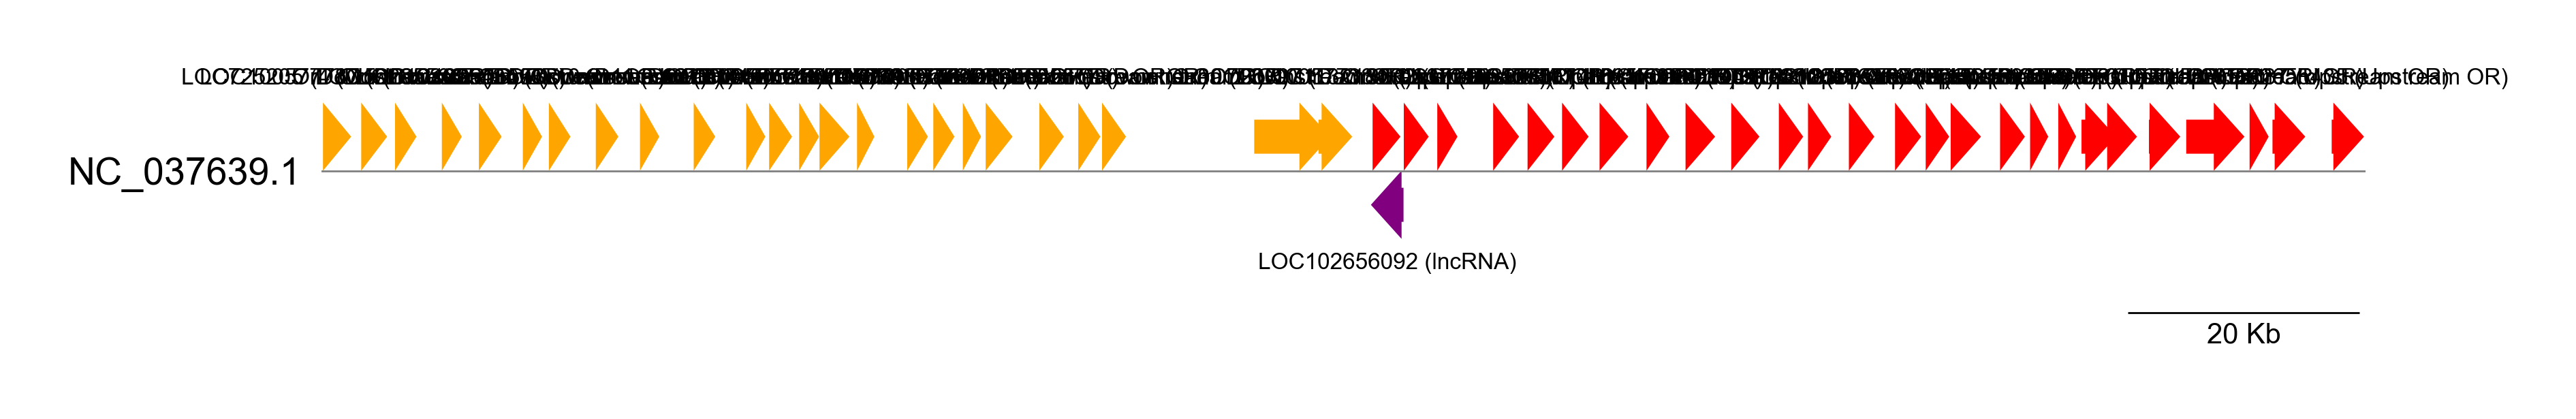

In [70]:
chromosome = tr.get_gene(lncRNA).chromosome
start = min(rows.or_start)-100
end = max(rows.or_end)+100
print(f"Chromosome: {chromosome}, Start: {start}, End: {end}")

white_plotting()
gv = GenomeViz(track_align_type="center", theme="light")
gv.set_scale_bar(ymargin=0.5)

fontsize=12 

# Get bounds 
track = gv.add_feature_track(chromosome, segments = (int(start), int(end)))
#track.add_sublabel(size=fontsize)

# Add gene models to plot 
for gene in [lncRNA] + list(upstream_ORs) + list(downstream_ORs):
    transcript = tr.get_gene(gene).get_transcript_longest_bounds()
    bounds = transcript.get_bounds()
    strand = np.where(transcript.strand == '+', 1, -1) 
    vpos = "top" if strand == 1 else "bottom"
    if gene in upstream_ORs:
        color = 'red'
        label = f'{gene} (Upstream OR)'
    elif gene in downstream_ORs:
        color = 'orange'
        label = f'{gene} (Downstream OR)'
    elif gene == lncRNA: 
        color = 'purple'
        label = f'{gene} (lncRNA)'
    else: 
        color = 'grey'
        label = gene
        
    track.add_feature(
        int(bounds[0]),
        int(bounds[1]), 
        strand, 
        plotstyle='arrow', 
        fc=color, 
        arrow_shaft_ratio = 0.5, 
        label=label, 
        text_kws={'color': 'black', 
                  'rotation': 0, 
                  'vpos': vpos, 
                  'hpos': 'center', 
                  'size':fontsize}
    )

fig = gv.plotfig()
plt.show()

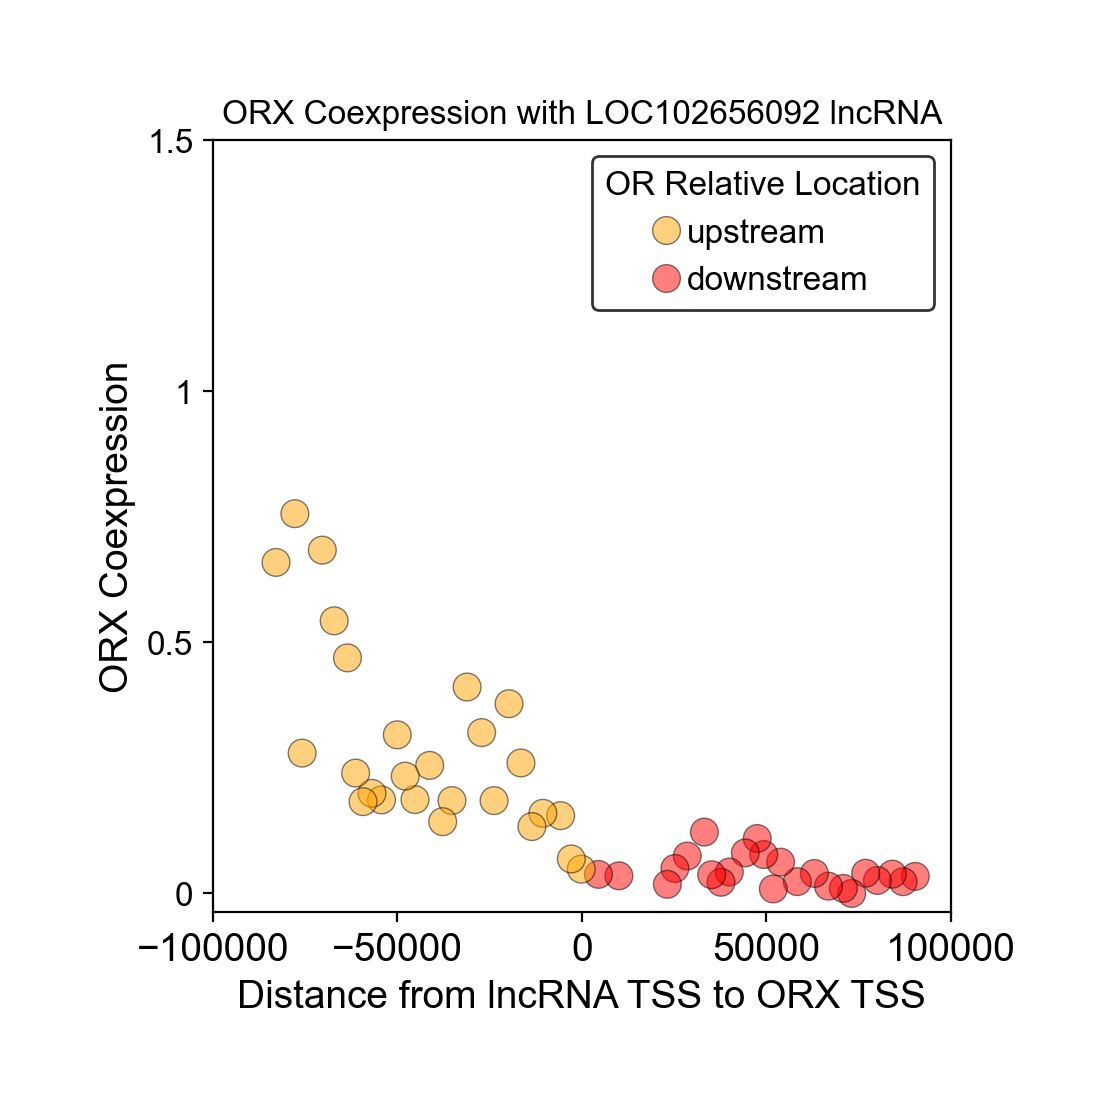

In [71]:
# Scatter plot of coexpression vs distance_adjusted, two subplots for P1 and P14, with KDE 
white_plotting()
fontsize=12
f, ax = plt.subplots(1, 1, figsize=(5, 5), sharey=True)
palette=['orange', 'red']
sns.scatterplot(data=rows, x='distance_adjusted', y="OR_coexpression", ax=ax, hue='location', hue_order=['upstream', 'downstream'], palette=palette, s=100, legend=True, lw=0.5, edgecolor='black', alpha=0.5)
ax.set_xlabel('Distance from lncRNA TSS to ORX TSS')
ax.set_ylabel('ORX Coexpression')
ax.set_title(f'ORX Coexpression with {lncRNA} lncRNA', fontsize=fontsize)
ax.set_xlim(-100_000, 100_000)
#ax.set_xticks([-20_000, -10_000, 0, 10_000, 20_000])
#ax.set_xticklabels(['-20kb', '-10kb', '0', '10kb', '20kb'], fontsize=fontsize)
ax.legend(title='OR Relative Location', loc='upper right', fontsize=fontsize, title_fontsize=fontsize)
ax.set_yticks([0, 0.5, 1, 1.5])
ax.set_yticklabels([0, 0.5, 1, 1.5], fontsize=fontsize)

plt.tight_layout()
plt.show()

In [72]:
# Plot the number of lncRNAs split by TA 
ta, counts = np.unique(nested_lncRNAs['TA'], return_counts=True)
counts = pd.DataFrame({'TA': ta, 'num_lnc': counts})
counts = counts.sort_values(by='num_lnc', ascending=False).reset_index(drop=True)
counts['num_ORs'] = counts['TA'].apply(lambda x: or_db_no_orco.loc[or_db_no_orco.tandem_array == x].shape[0])
counts

TA  num_lnc  num_ORs
0  12       10       50
1  22        1        5

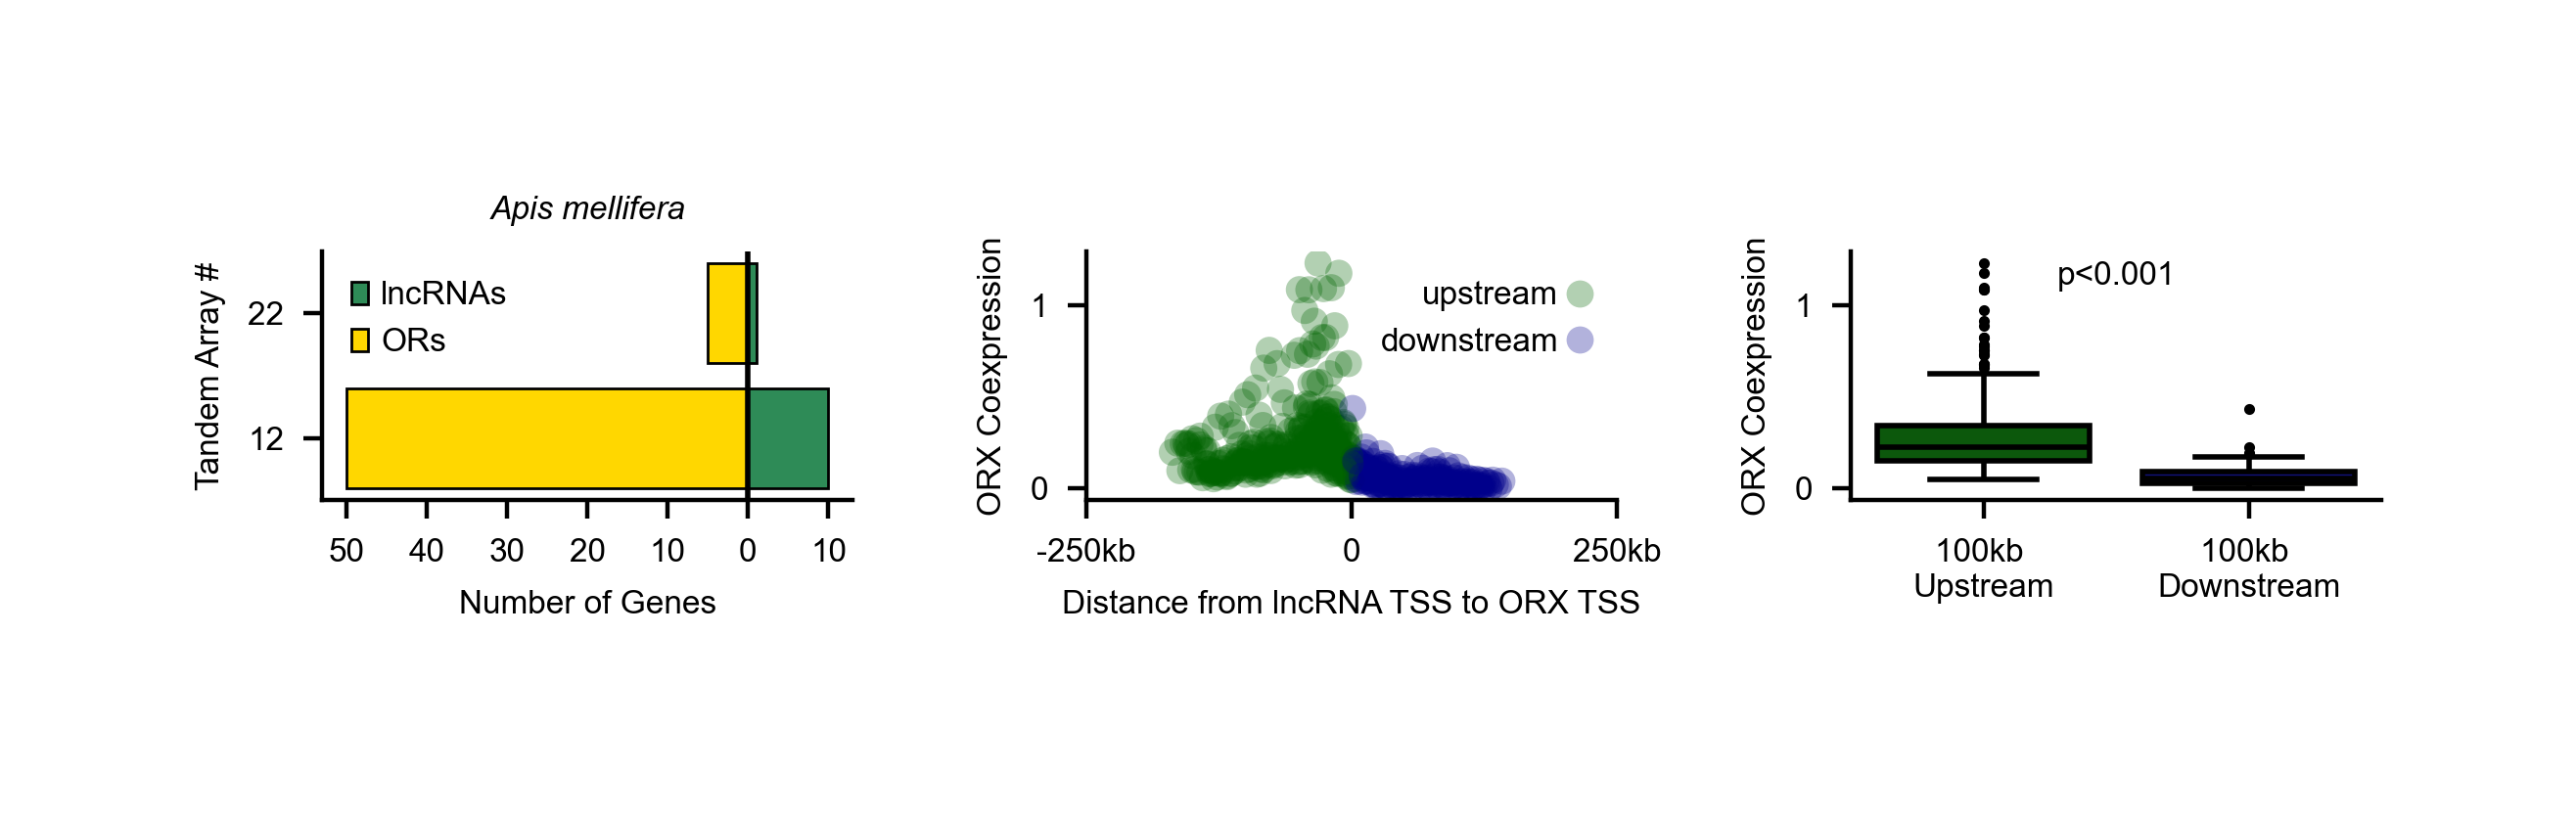

In [120]:
# Scatter plot of coexpression vs distance_adjusted, two subplots for P1 and P14, with KDE 
white_plotting()
fontsize=6
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']
f, axs = plt.subplots(1, 3, figsize=(6, 1.5), dpi=200)

ax = axs[0]

y_labels = counts['TA']
y_pos = np.arange(len(y_labels))

ax.barh(y_pos, counts['num_lnc'], color='seagreen', label='lncRNAs', linewidth=0.5, edgecolor='black')
ax.barh(y_pos, -counts['num_ORs'], color='gold', label='ORs', linewidth=0.5, edgecolor='black')

# Y axis 
ax.set_yticks(y_pos)
ax.set_yticklabels(y_labels, fontsize=fontsize)
ax.set_ylabel('Tandem Array #', fontsize=fontsize)
ax.set_title("Apis mellifera", fontsize=6, style='italic')

# X labels 
ax.set_xticks([-50, -40, -30, -20, -10, 0, 10], labels=[50, 40, 30, 20, 10, 0, 10], fontsize=fontsize)
ax.set_xlabel('')
ax.axvline(0, color='black', linewidth=1) 

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel("Number of Genes", fontsize=fontsize)
ax.legend(loc='upper left', fontsize=fontsize, frameon=False)

palette=['darkgreen', 'darkblue']
ax = axs[1]
sns.scatterplot(data=lnc_associated_ORs, x='distance_adjusted', y="OR_coexpression", ax=ax, hue='location', hue_order=['upstream', 'downstream'], palette=palette, s=25, legend=True, lw=0, edgecolor='black', alpha=0.3)
ax.set_xlabel('Distance from lncRNA TSS to ORX TSS', fontsize=fontsize)
ax.set_ylabel('ORX Coexpression', fontsize=fontsize)
ax.set_xlim(-250_000, 250_000)
ax.set_xticks([-250_000, 0, 250_000], labels=['-250kb', '0', '250kb'], fontsize=fontsize)
ax.set_yticks([0, 1], labels=[0, 1], fontsize=fontsize)
ax.legend(loc='upper right', fontsize=fontsize, frameon=False, markerfirst=False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)


ax = axs[2]
max_distance = 100_000
data_subset=lnc_associated_ORs[lnc_associated_ORs['tss2tss'] < max_distance]
labels = ['100kb \nUpstream', '100kb \nDownstream']
# Plot box plot of OR coexpression by location and add stats 
palette=['darkgreen', 'darkblue']
bx = sns.boxplot(data=data_subset, x='location', y='OR_coexpression', ax=ax, palette=palette, hue_order=['upstream', 'downstream'], order=['upstream', 'downstream'], linewidth=1, linecolor='black', fliersize=1)
ax.set_xlabel('')
ax.set_ylabel('ORX Coexpression', fontsize=fontsize)
ax.set_xticks([0, 1], labels=labels, fontsize=fontsize)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_yticks([0, 1], labels=[0, 1], fontsize=fontsize)

# Rank sum test 
upstream = data_subset.loc[data_subset['location'] == 'upstream', 'OR_coexpression']
downstream = data_subset.loc[data_subset['location'] == 'downstream', 'OR_coexpression']
from scipy.stats import ranksums
stat, p = ranksums(upstream, downstream)
p_value_str = f"p={p:.3f}" if p >= 0.001 else "p<0.001"
plt.text(0.5, 0.9, p_value_str, horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, fontsize=fontsize)

plt.tight_layout()
plt.savefig(f"/Users/giacomo.glotzer/Desktop/Rockefeller/Kronauer/lncRNA Paper/figure_pdfs/Amell-lncRNA-ORX-coexpression.pdf", format="pdf", pad_inches=0, bbox_inches=0, transparent=False)
plt.show()

## Identify cells with valence OR in a tandem array that has a lncRNA 

In [78]:
# Make a dataframe with cell ID in a column and individual columns for each OR 
cell_or_expression = pd.DataFrame(index=adata.obs.index, columns=or_db.gene_name_snrna)
for i, row in or_db.iterrows(): 
    cell_or_expression[row.gene_name_snrna] = adata[:,row['gene_name_snrna']].X.toarray().flatten()

# Drop Or2 from cell_or_expression
cell_or_expression = cell_or_expression.drop(columns='Or2')

In [79]:
# Find the highest-expressing OR in each cell 
cell_valence_OR = cell_or_expression.idxmax(axis=1)
cell_valence_OR = cell_valence_OR.reset_index()
cell_valence_OR.columns = ['cell_index', 'valence_OR']
cell_valence_OR['valence_OR_tr'] = cell_valence_OR['valence_OR'].apply(lambda x: or_db.loc[or_db['gene_name_snrna'] == x, 'gene_name'].values[0])
cell_valence_OR['tandem_array'] = cell_valence_OR['valence_OR'].apply(lambda x: or_db.loc[or_db['gene_name_snrna'] == x, 'tandem_array'].values[0])
cell_valence_OR['or_strand'] = cell_valence_OR['valence_OR_tr'].apply(lambda x: tr.get_gene(x).strand)
cell_valence_OR

cell_index    valence_OR valence_OR_tr  tandem_array or_strand
0     AAACAGCCAATGCCCG-1          Or37          Or37            12         +
1     AAACAGCCAATTGACT-1         Or109         Or109            25         +
2     AAACAGCCAGGCCAAA-1          Or12          Or12            12         +
3     AAACAGCCATTAGCCA-1  LOC102656271  LOC102656271            30         +
4     AAACATGCAAATATCC-1           Or4           Or4            12         +
...                  ...           ...           ...           ...       ...
3537  TTTGTGTTCTGCAAAC-1     LOC725205     LOC725205            12         +
3538  TTTGTTGGTAATCCCT-1          Or57          Or57            12         +
3539  TTTGTTGGTATACTGG-1  LOC107966050  LOC107966050             2         -
3540  TTTGTTGGTCGCATAA-1          Or55          Or55            12         +
3541  TTTGTTGGTTAATCGG-1  LOC102653637  LOC102653637            12         +

[3542 rows x 5 columns]

In [80]:
# count rows where valence_OR != valence_OR_tr
cell_valence_OR[cell_valence_OR['valence_OR'] != cell_valence_OR['valence_OR_tr']].shape

(174, 5)

In [81]:
# Remove cells that do not have a lncRNA in the tandem array 
cell_valence_OR = cell_valence_OR[cell_valence_OR['tandem_array'].isin(nested_lncRNAs['TA'])].reset_index(drop=True)
cell_valence_OR

cell_index    valence_OR valence_OR_tr  tandem_array or_strand
0     AAACAGCCAATGCCCG-1          Or37          Or37            12         +
1     AAACAGCCAGGCCAAA-1          Or12          Or12            12         +
2     AAACATGCAAATATCC-1           Or4           Or4            12         +
3     AAACCAACAGGCCATT-1          Or12          Or12            12         +
4     AAACCAACATGACTAT-1          Or51          Or51            12         +
...                  ...           ...           ...           ...       ...
1505  TTTGTGTTCGTTAACA-1          Or26          Or26            12         +
1506  TTTGTGTTCTGCAAAC-1     LOC725205     LOC725205            12         +
1507  TTTGTTGGTAATCCCT-1          Or57          Or57            12         +
1508  TTTGTTGGTCGCATAA-1          Or55          Or55            12         +
1509  TTTGTTGGTTAATCGG-1  LOC102653637  LOC102653637            12         +

[1510 rows x 5 columns]

## Assign lncRNAs to valence ORs 
- Assert that the lncRNA and valence OR are on opposite strands 
- Assert that all transcript isoforms have a 3' end that is upstream of the OR TSS 
- Assert that min distance from the lncRNA 3' end (across all transcript isoforms) to the TSS is less than 10kb 
- Only save the lncRNA with the minimum `tss_2_lnc_end` distance 
- Remove cells where no lncRNA was assigned 
- Save expression of lncRNA and valence OR for each cell 

In [82]:
# For each cell and valence OR, look for a lncRNA whose 3' end is upstream of the OR TSS and whose 5' end is closest to the OR TSS 
max_distance = 10_000
for i, row in tqdm(cell_valence_OR.iterrows(), total=cell_valence_OR.shape[0]):
    or_bounds = tr.get_gene(row['valence_OR_tr']).get_transcript_longest_cds().get_bounds()
    or_tss = or_bounds[0] if row['or_strand'] == "+" else or_bounds[1]
    # Get lncRNAs in the TA
    relevant_lncRNAs = nested_lncRNAs[nested_lncRNAs['TA'] == row['tandem_array']]
    relevant_lncRNAs['tss2tss'] = None
    relevant_lncRNAs['all_upstream'] = None
    for j, lncRNA in relevant_lncRNAs.iterrows():
        # check that strands are opposite 
        if row['or_strand'] == lncRNA['lnc_strand']:
            continue
        # get the bounds of the lncRNA 
        lnc_transcripts = tr.get_gene(lncRNA['gene_name']).transcripts 
        end_ind = 1 if lncRNA['lnc_strand'] == "+" else 0
        lnc_ends = [transcript.get_bounds()[end_ind] for transcript in lnc_transcripts]
        lnc_starts = [transcript.get_bounds()[1-end_ind] for transcript in lnc_transcripts]
        # Check that all transcripts have a 3' end upstream of the OR TSS
        all_upstream = all([lnc_end < or_tss for lnc_end in lnc_ends]) if row['or_strand'] == "+" else all([lnc_end > or_tss for lnc_end in lnc_ends])
        if all_upstream: 
            #tss_to_tss = min([abs(or_tss - lnc_start) for lnc_start in lnc_starts])
            tss_to_tss = min([(or_tss - lnc_start) for lnc_start in lnc_starts]) if row['or_strand'] == "+" else min([lnc_start - or_tss for lnc_start in lnc_starts])
            tss_2_lnc_end = min([abs(lnc_end - or_tss) for lnc_end in lnc_ends])
            relevant_lncRNAs.at[j, 'tss_2_lnc_end'] = tss_2_lnc_end
            relevant_lncRNAs.at[j, 'tss2tss'] = tss_to_tss
            relevant_lncRNAs.at[j, 'all_upstream'] = True
    # Save the lncRNA with the smallest tss2tss
    if relevant_lncRNAs.shape[0] > 0 and np.sum(relevant_lncRNAs['all_upstream']) > 0:
        relevant_lncRNAs = relevant_lncRNAs[relevant_lncRNAs['all_upstream']==True]
        relevant_lncRNAs = relevant_lncRNAs.iloc[np.argmin(relevant_lncRNAs['tss_2_lnc_end']), :]
        # Verify tss_2_lnc_end < max_distance 
        if relevant_lncRNAs['tss_2_lnc_end'] > max_distance: 
            continue
        cell_valence_OR.at[i, 'lncRNA'] = relevant_lncRNAs['gene_name']
        cell_valence_OR.at[i, 'tss_2_lnc_end'] = relevant_lncRNAs['tss_2_lnc_end']
        cell_valence_OR.at[i, 'tss2tss'] = relevant_lncRNAs['tss2tss']
        cell_valence_OR.at[i, 'lnc_strand'] = relevant_lncRNAs['lnc_strand']

cell_valence_OR

100%|██████████| 1510/1510 [00:02<00:00, 724.09it/s]


cell_index    valence_OR valence_OR_tr  tandem_array or_strand  \
0     AAACAGCCAATGCCCG-1          Or37          Or37            12         +   
1     AAACAGCCAGGCCAAA-1          Or12          Or12            12         +   
2     AAACATGCAAATATCC-1           Or4           Or4            12         +   
3     AAACCAACAGGCCATT-1          Or12          Or12            12         +   
4     AAACCAACATGACTAT-1          Or51          Or51            12         +   
...                  ...           ...           ...           ...       ...   
1505  TTTGTGTTCGTTAACA-1          Or26          Or26            12         +   
1506  TTTGTGTTCTGCAAAC-1     LOC725205     LOC725205            12         +   
1507  TTTGTTGGTAATCCCT-1          Or57          Or57            12         +   
1508  TTTGTTGGTCGCATAA-1          Or55          Or55            12         +   
1509  TTTGTTGGTTAATCGG-1  LOC102653637  LOC102653637            12         +   

            lncRNA  tss_2_lnc_end  tss2tss lnc_strand  
0              NaN            NaN      NaN        NaN  
1              NaN            NaN      NaN        NaN  
2     LOC107966099         1971.0  -8221.0          -  
3              NaN            NaN      NaN        NaN  
4     LOC107966089         3087.0  -1848.0          -  
...            ...            ...      ...        ...  
1505  LOC107966088         2146.0 -10060.0          -  
1506           NaN            NaN      NaN        NaN  
1507           NaN            NaN      NaN        NaN  
1508           NaN            NaN      NaN        NaN  
1509           NaN            NaN      NaN        NaN  

[1510 rows x 9 columns]

In [83]:
print(f"Dropped {cell_valence_OR[cell_valence_OR.tss_2_lnc_end < 0].shape[0]} rows where tss_2_lnc_end is negative")
cell_valence_OR = cell_valence_OR[cell_valence_OR.tss_2_lnc_end > 0].reset_index(drop=True)
cell_valence_OR = cell_valence_OR.dropna().reset_index(drop=True)
cell_valence_OR

Dropped 0 rows where tss_2_lnc_end is negative


cell_index    valence_OR valence_OR_tr  tandem_array or_strand  \
0    AAACATGCAAATATCC-1           Or4           Or4            12         +   
1    AAACCAACATGACTAT-1          Or51          Or51            12         +   
2    AAACGCGCACAAGCCT-1  LOC100577334  LOC100577334            12         +   
3    AAAGCAAGTGCTCCAC-1  LOC113218533  LOC113218533            12         +   
4    AAAGGACGTGCTCACC-1  LOC113218533  LOC113218533            12         +   
..                  ...           ...           ...           ...       ...   
536  TTTGGCTGTAAAGCAA-1          Or10          Or10            12         +   
537  TTTGGCTGTTAGGCTA-1  LOC102655553  LOC102655553            12         +   
538  TTTGGTAAGTTATGTG-1          Or26          Or26            12         +   
539  TTTGTCCCACTGGCCA-1          Or35          Or35            12         +   
540  TTTGTGTTCGTTAACA-1          Or26          Or26            12         +   

           lncRNA  tss_2_lnc_end  tss2tss lnc_strand  
0    LOC107966099         1971.0  -8221.0          -  
1    LOC107966089         3087.0  -1848.0          -  
2    LOC102656092          145.0  -2667.0          -  
3    LOC113218588         7643.0   5152.0          -  
4    LOC113218588         7643.0   5152.0          -  
..            ...            ...      ...        ...  
536  LOC107966098         9387.0    156.0          -  
537  LOC107966098         1530.0  -7701.0          -  
538  LOC107966088         2146.0 -10060.0          -  
539  LOC102656092         5724.0   2912.0          -  
540  LOC107966088         2146.0 -10060.0          -  

[541 rows x 9 columns]

In [84]:
# Get expression of lncRNA and valence OR in each cell 
cell_valence_OR['lncRNA_expression'] = cell_valence_OR.apply(lambda x: adata[x['cell_index'], x['lncRNA']].X.toarray().flatten()[0], axis=1)
cell_valence_OR['valence_OR_expression'] = cell_valence_OR.apply(lambda x: adata[x['cell_index'], x['valence_OR']].X.toarray().flatten()[0], axis=1)

<Axes: xlabel='lncRNA_expression', ylabel='valence_OR_expression'>

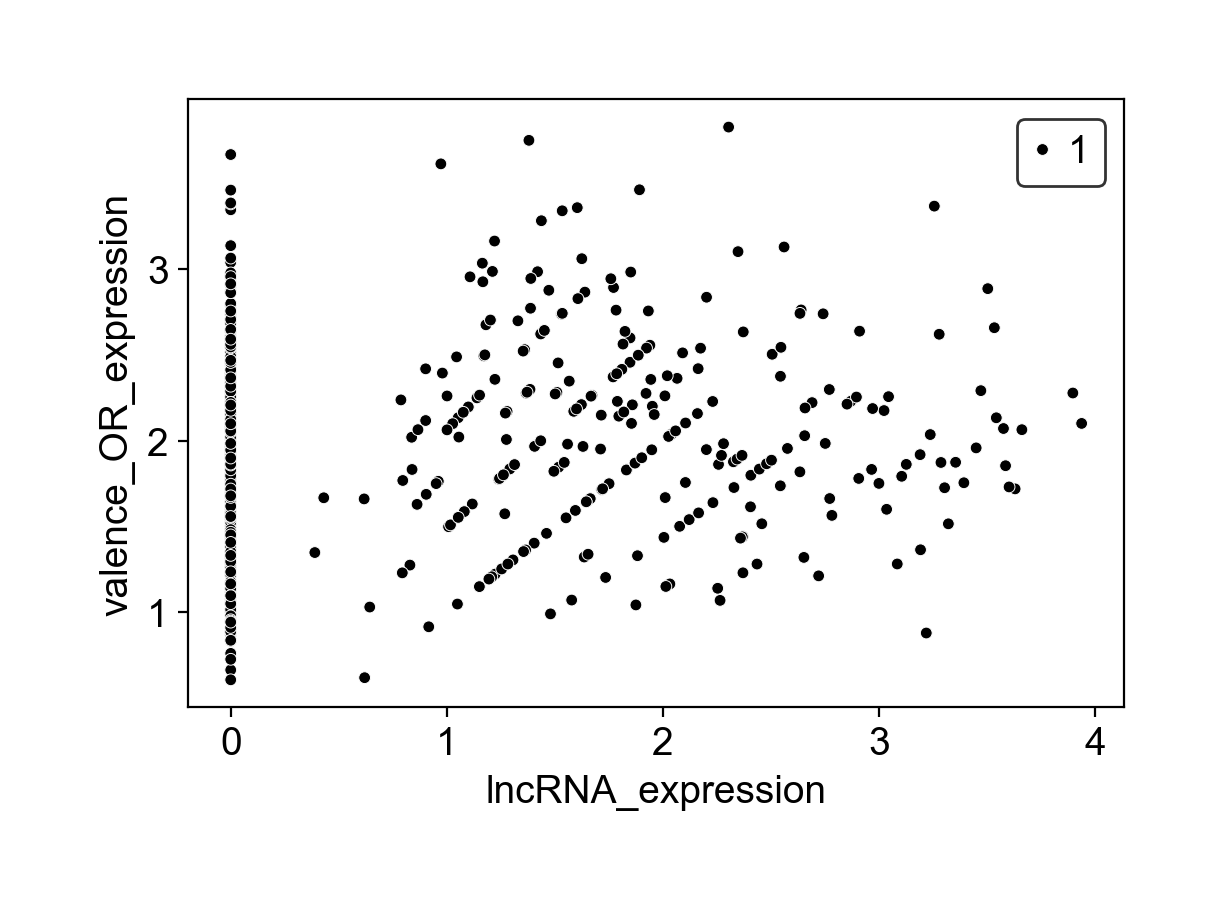

In [85]:
# Plot scatter of lncRNA expression vs valence OR expression
white_plotting()
plt.figure(figsize=(6, 4))
sns.scatterplot(data=cell_valence_OR, x='lncRNA_expression', y='valence_OR_expression', color='black', size=1)

## Get ORs upstream and downstream of the valence OR 
- Assert that the valence OR is not at the start or the end of the tandem array (ensuring it has both a downstream and upstream OR)
- Assert that the valence OR and both it's upstream and downstream ORs are on the same strand 
- Save the expression of both the upstream and downstream ORs for each cell 

In [86]:
# Get upstream and downstream ORs 
for i, row in tqdm(cell_valence_OR.iterrows(), total=cell_valence_OR.shape[0]): 
    valence_strand = or_db.loc[or_db['gene_name'] == row['valence_OR_tr'], 'strand'].values[0]
    valence_tss = or_db.loc[or_db['gene_name'] == row['valence_OR_tr'], 'start'].values[0]
    other_ORs = or_db.loc[or_db['tandem_array'] == row['tandem_array']] 
    valence_index = or_db.loc[or_db['gene_name'] == row['valence_OR_tr'], 'ta_index'].values[0]
    TA_size = or_db.loc[or_db['gene_name'] == row['valence_OR_tr'], 'ta_size'].values[0]
    # if or's index is 1 or ta_index, continue 
    if valence_index == 0 or valence_index == TA_size:
        continue
    if valence_tss == np.min(other_ORs['start']) or valence_tss == np.max(other_ORs['start']):
        continue
    if valence_strand == '+': 
        # find OR in other_ORs that is closest to the start of valence_OR
        upstream_OR = other_ORs[other_ORs['start'] < valence_tss].sort_values(by='start', ascending=False).iloc[0]
        downstream_OR = other_ORs[other_ORs['start'] > valence_tss].sort_values(by='start').iloc[0]
    else: 
        # find OR in other_ORs that is closest to the start of valence_OR
        upstream_OR = other_ORs[other_ORs['start'] > valence_tss].sort_values(by='start').iloc[0]
        downstream_OR = other_ORs[other_ORs['start'] < valence_tss].sort_values(by='start', ascending=False).iloc[0]
    cell_valence_OR.at[i, 'upstream_OR'] = upstream_OR['gene_name_snrna']
    cell_valence_OR.at[i, 'downstream_OR'] = downstream_OR['gene_name_snrna']
cell_valence_OR

100%|██████████| 541/541 [00:00<00:00, 1083.68it/s]


cell_index    valence_OR valence_OR_tr  tandem_array or_strand  \
0    AAACATGCAAATATCC-1           Or4           Or4            12         +   
1    AAACCAACATGACTAT-1          Or51          Or51            12         +   
2    AAACGCGCACAAGCCT-1  LOC100577334  LOC100577334            12         +   
3    AAAGCAAGTGCTCCAC-1  LOC113218533  LOC113218533            12         +   
4    AAAGGACGTGCTCACC-1  LOC113218533  LOC113218533            12         +   
..                  ...           ...           ...           ...       ...   
536  TTTGGCTGTAAAGCAA-1          Or10          Or10            12         +   
537  TTTGGCTGTTAGGCTA-1  LOC102655553  LOC102655553            12         +   
538  TTTGGTAAGTTATGTG-1          Or26          Or26            12         +   
539  TTTGTCCCACTGGCCA-1          Or35          Or35            12         +   
540  TTTGTGTTCGTTAACA-1          Or26          Or26            12         +   

           lncRNA  tss_2_lnc_end  tss2tss lnc_strand  lncRNA_expression  \
0    LOC107966099         1971.0  -8221.0          -           1.410473   
1    LOC107966089         3087.0  -1848.0          -           2.326178   
2    LOC102656092          145.0  -2667.0          -           0.000000   
3    LOC113218588         7643.0   5152.0          -           0.000000   
4    LOC113218588         7643.0   5152.0          -           1.387270   
..            ...            ...      ...        ...                ...   
536  LOC107966098         9387.0    156.0          -           0.000000   
537  LOC107966098         1530.0  -7701.0          -           2.720489   
538  LOC107966088         2146.0 -10060.0          -           1.714471   
539  LOC102656092         5724.0   2912.0          -           0.000000   
540  LOC107966088         2146.0 -10060.0          -           0.000000   

     valence_OR_expression   upstream_OR downstream_OR  
0                 1.973496  LOC100577787           Or5  
1                 1.878432          Or50          Or52  
2                 1.438262     LOC726097  LOC113218602  
3                 2.593862  LOC100576881  LOC100576816  
4                 2.773808  LOC100576881  LOC100576816  
..                     ...           ...           ...  
536               1.166710           Or9          Or11  
537               1.213317  LOC102655434           Or9  
538               2.150547          Or25          Or27  
539               2.470204  LOC113218602          Or37  
540               2.593194          Or25          Or27  

[541 rows x 13 columns]

In [87]:
# Drop NaN Rows 
cell_valence_OR = cell_valence_OR.dropna().reset_index(drop=True)

In [88]:
# Get strand for upstream and downstream ORs
cell_valence_OR['upstream_OR_strand'] = cell_valence_OR['upstream_OR'].apply(lambda x: or_db.loc[or_db['gene_name_snrna'] == x, 'strand'].values[0])
cell_valence_OR['downstream_OR_strand'] = cell_valence_OR['downstream_OR'].apply(lambda x: or_db.loc[or_db['gene_name_snrna'] == x, 'strand'].values[0])

In [89]:
# Remove rows where upstream and valence and downstream ORs are not all on the same strand 
cell_valence_OR = cell_valence_OR[(cell_valence_OR['upstream_OR_strand'] == cell_valence_OR['or_strand']) & (cell_valence_OR['downstream_OR_strand'] == cell_valence_OR['or_strand'])].reset_index(drop=True)

In [90]:
# Get expression of upstream and downstream ORs in each cell
cell_valence_OR['upstream_OR_expression'] = cell_valence_OR.apply(lambda x: adata[x['cell_index'], x['upstream_OR']].X.toarray().flatten()[0], axis=1)
cell_valence_OR['downstream_OR_expression'] = cell_valence_OR.apply(lambda x: adata[x['cell_index'], x['downstream_OR']].X.toarray().flatten()[0], axis=1)

In [91]:
cell_valence_OR

cell_index    valence_OR valence_OR_tr  tandem_array or_strand  \
0    AAACATGCAAATATCC-1           Or4           Or4            12         +   
1    AAACCAACATGACTAT-1          Or51          Or51            12         +   
2    AAACGCGCACAAGCCT-1  LOC100577334  LOC100577334            12         +   
3    AAAGCAAGTGCTCCAC-1  LOC113218533  LOC113218533            12         +   
4    AAAGGACGTGCTCACC-1  LOC113218533  LOC113218533            12         +   
..                  ...           ...           ...           ...       ...   
536  TTTGGCTGTAAAGCAA-1          Or10          Or10            12         +   
537  TTTGGCTGTTAGGCTA-1  LOC102655553  LOC102655553            12         +   
538  TTTGGTAAGTTATGTG-1          Or26          Or26            12         +   
539  TTTGTCCCACTGGCCA-1          Or35          Or35            12         +   
540  TTTGTGTTCGTTAACA-1          Or26          Or26            12         +   

           lncRNA  tss_2_lnc_end  tss2tss lnc_strand  lncRNA_expression  \
0    LOC107966099         1971.0  -8221.0          -           1.410473   
1    LOC107966089         3087.0  -1848.0          -           2.326178   
2    LOC102656092          145.0  -2667.0          -           0.000000   
3    LOC113218588         7643.0   5152.0          -           0.000000   
4    LOC113218588         7643.0   5152.0          -           1.387270   
..            ...            ...      ...        ...                ...   
536  LOC107966098         9387.0    156.0          -           0.000000   
537  LOC107966098         1530.0  -7701.0          -           2.720489   
538  LOC107966088         2146.0 -10060.0          -           1.714471   
539  LOC102656092         5724.0   2912.0          -           0.000000   
540  LOC107966088         2146.0 -10060.0          -           0.000000   

     valence_OR_expression   upstream_OR downstream_OR upstream_OR_strand  \
0                 1.973496  LOC100577787           Or5                  +   
1                 1.878432          Or50          Or52                  +   
2                 1.438262     LOC726097  LOC113218602                  +   
3                 2.593862  LOC100576881  LOC100576816                  +   
4                 2.773808  LOC100576881  LOC100576816                  +   
..                     ...           ...           ...                ...   
536               1.166710           Or9          Or11                  +   
537               1.213317  LOC102655434           Or9                  +   
538               2.150547          Or25          Or27                  +   
539               2.470204  LOC113218602          Or37                  +   
540               2.593194          Or25          Or27                  +   

    downstream_OR_strand  upstream_OR_expression  downstream_OR_expression  
0                      +                0.000000                  0.000000  
1                      +                1.046528                  1.046528  
2                      +                0.000000                  0.000000  
3                      +                2.225081                  0.000000  
4                      +                2.303756                  2.303756  
..                   ...                     ...                       ...  
536                    +                0.000000                  0.000000  
537                    +                0.000000                  0.000000  
538                    +                1.714471                  1.714471  
539                    +                0.000000                  1.152144  
540                    +                2.330133                  1.409303  

[541 rows x 17 columns]

## Initial Plots

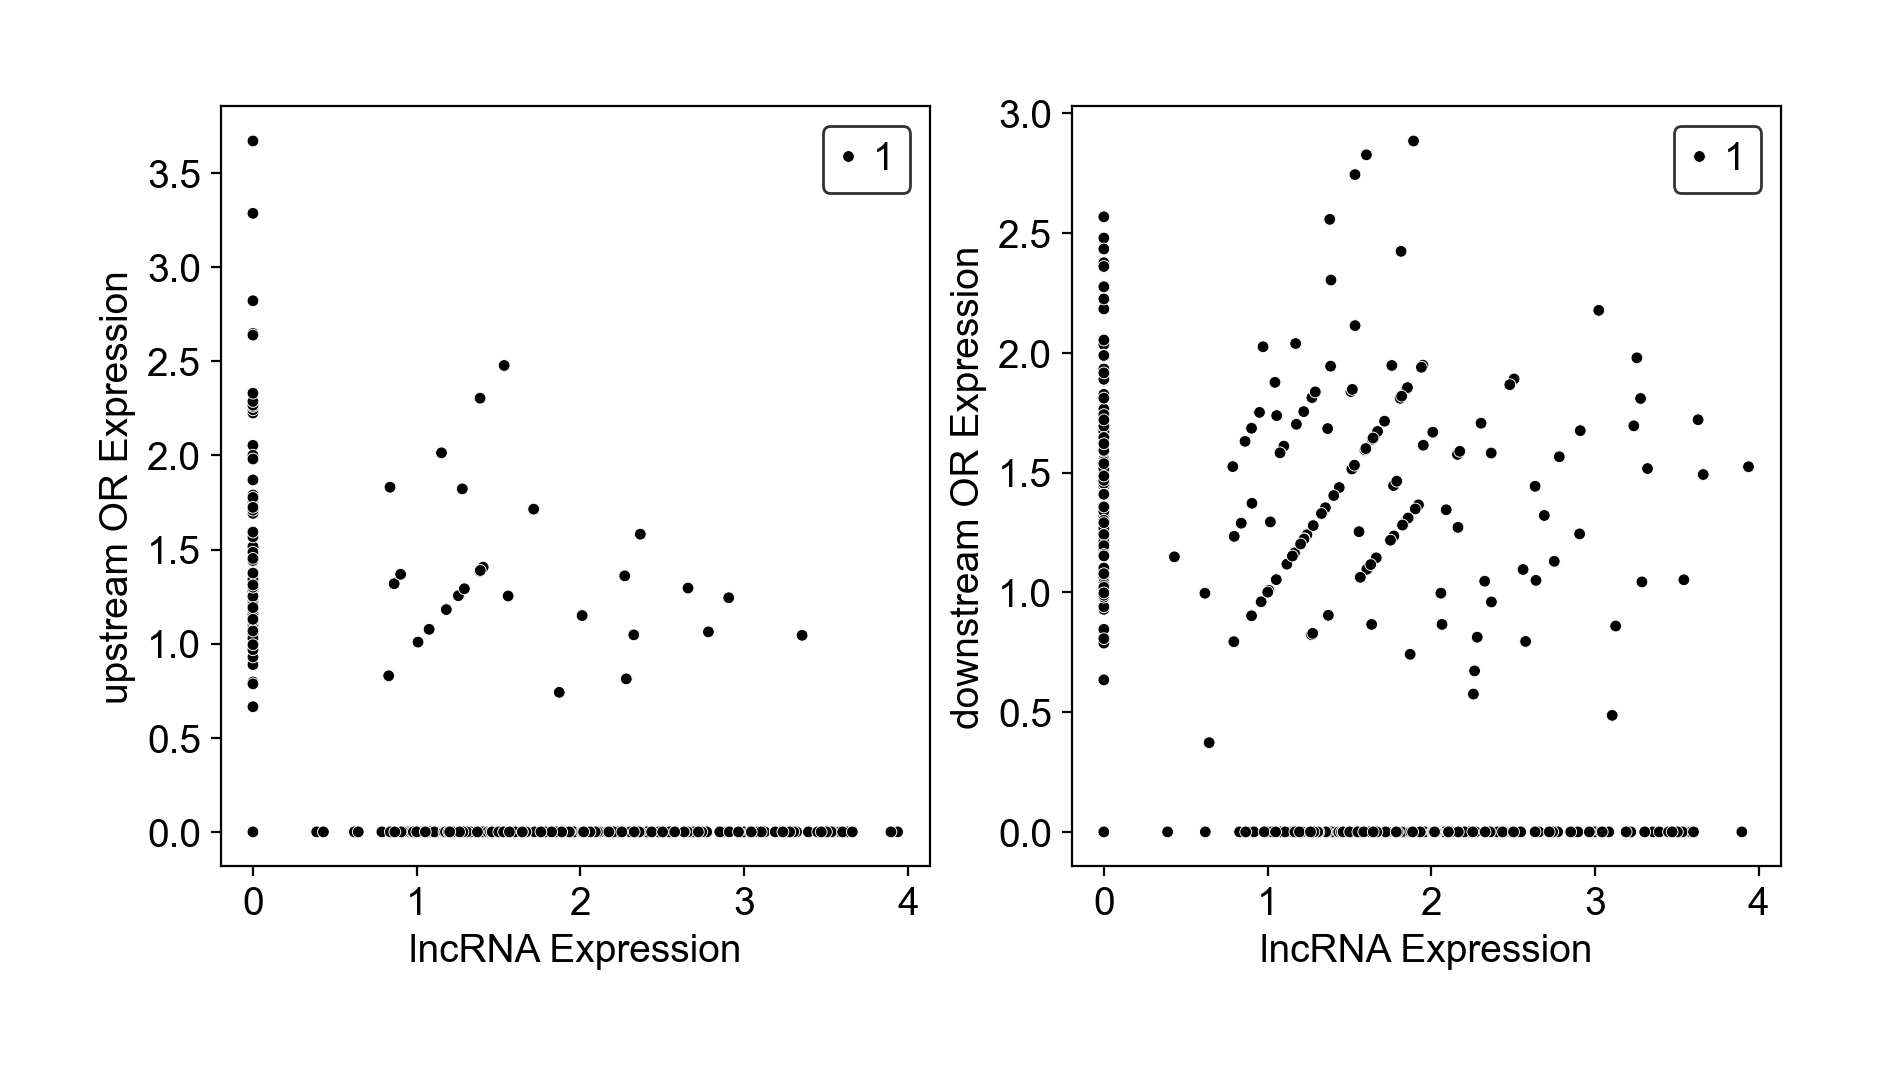

In [92]:
# Plot scatter of upstream and downstream expression vs lncRNA expression 
f, ax = plt.subplots(1, 2, figsize=(10, 5))
white_plotting()
for i, or_type in enumerate(['upstream', 'downstream']):
    sns.scatterplot(data=cell_valence_OR, x='lncRNA_expression', y=f'{or_type}_OR_expression', ax=ax[i], color='black', size=1)
    ax[i].set_xlabel('lncRNA Expression')
    ax[i].set_ylabel(f'{or_type} OR Expression')

## Plot Examples

In [93]:
# get unique lncRNAs that have at least 30 cells 
lncRNA_counts = cell_valence_OR['lncRNA'].value_counts()
lncRNAs = lncRNA_counts[lncRNA_counts > 30].index
lncRNAs

Index(['LOC107966099', 'LOC107965274', 'LOC113218603', 'LOC102656092',
       'LOC107966098', 'LOC107966088', 'LOC113218588', 'LOC107966095',
       'LOC102656676'],
      dtype='object', name='lncRNA')

In [94]:
lncRNA = 'LOC113218603'
cells = cell_valence_OR[(cell_valence_OR['lncRNA'] == lncRNA)]
cells['valence_OR'].value_counts()


valence_OR
LOC100577671    30
LOC100577938    25
LOC100577634    10
Name: count, dtype: int64

In [95]:
# find cells where lncRNA = LOC109611159
valence_OR = "LOC100577634"
cells = cell_valence_OR[(cell_valence_OR['lncRNA'] == lncRNA) & (cell_valence_OR['valence_OR'] == valence_OR)]
pd.set_option('display.max_rows', 10)
cells

cell_index    valence_OR valence_OR_tr  tandem_array or_strand  \
58   AGCAAGGGTTAAGCGC-1  LOC100577634  LOC100577634            12         +   
59   AGCAATTGTAACCTAG-1  LOC100577634  LOC100577634            12         +   
65   AGCTACTAGTTAGTGC-1  LOC100577634  LOC100577634            12         +   
71   AGGCTAAAGTTGCCTC-1  LOC100577634  LOC100577634            12         +   
85   AGTGAGTCAACATAAG-1  LOC100577634  LOC100577634            12         +   
108  ATTACGTCAAACCTAT-1  LOC100577634  LOC100577634            12         +   
152  CCCGCAACACCATATG-1  LOC100577634  LOC100577634            12         +   
323  GCTAGCGGTTAAGCTG-1  LOC100577634  LOC100577634            12         +   
451  TCAGGAGCAACCCTCC-1  LOC100577634  LOC100577634            12         +   
515  TGTTGTTTCCGCAAGC-1  LOC100577634  LOC100577634            12         +   

           lncRNA  tss_2_lnc_end  tss2tss lnc_strand  lncRNA_expression  \
58   LOC113218603         5735.0   1045.0          -           0.000000   
59   LOC113218603         5735.0   1045.0          -           2.771719   
65   LOC113218603         5735.0   1045.0          -           1.622689   
71   LOC113218603         5735.0   1045.0          -           1.278714   
85   LOC113218603         5735.0   1045.0          -           0.000000   
108  LOC113218603         5735.0   1045.0          -           0.000000   
152  LOC113218603         5735.0   1045.0          -           0.000000   
323  LOC113218603         5735.0   1045.0          -           2.435312   
451  LOC113218603         5735.0   1045.0          -           3.084183   
515  LOC113218603         5735.0   1045.0          -           0.000000   

     valence_OR_expression   upstream_OR downstream_OR upstream_OR_strand  \
58                1.862177  LOC100577671  LOC100577938                  +   
59                1.664255  LOC100577671  LOC100577938                  +   
65                2.211937  LOC100577671  LOC100577938                  +   
71                2.172026  LOC100577671  LOC100577938                  +   
85                2.009548  LOC100577671  LOC100577938                  +   
108               1.973496  LOC100577671  LOC100577938                  +   
152               1.019778  LOC100577671  LOC100577938                  +   
323               1.282279  LOC100577671  LOC100577938                  +   
451               1.282655  LOC100577671  LOC100577938                  +   
515               2.058337  LOC100577671  LOC100577938                  +   

    downstream_OR_strand  upstream_OR_expression  downstream_OR_expression  
58                     +                0.000000                  0.000000  
59                     +                0.000000                  0.000000  
65                     +                0.000000                  0.000000  
71                     +                1.821971                  1.278714  
85                     +                1.442196                  1.442196  
108                    +                1.120133                  0.000000  
152                    +                0.000000                  0.634611  
323                    +                0.000000                  0.000000  
451                    +                0.000000                  0.000000  
515                    +                1.485340                  0.000000

Chromosome: NC_037639.1, Start: 10021396, End: 10031215


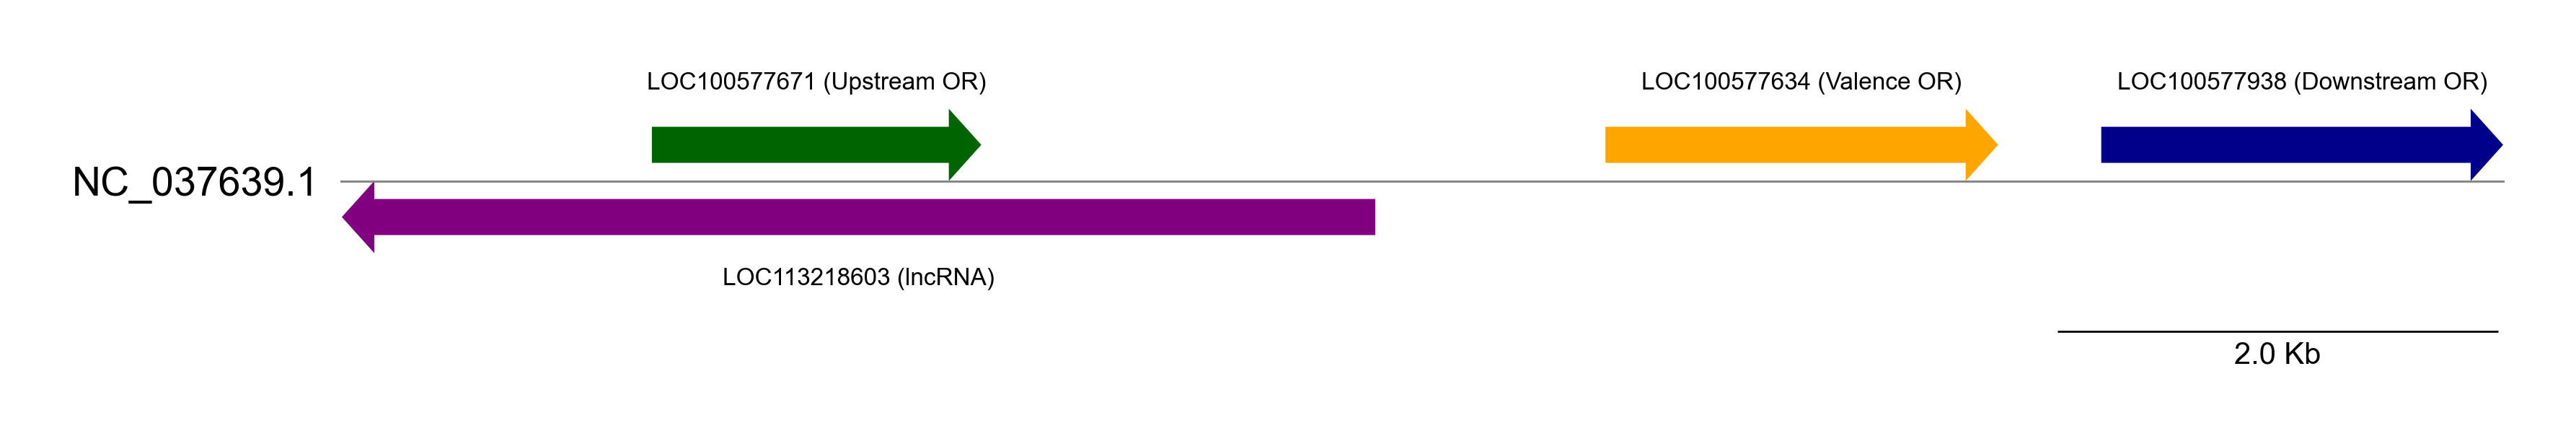

In [96]:
upstream_OR = cells['upstream_OR'].values[0]
downstream_OR = cells['downstream_OR'].values[0]
all_bounds = [tr.get_gene(gene).get_transcript_longest_bounds().get_bounds() for gene in [lncRNA, upstream_OR, valence_OR, downstream_OR]]
chromosome = tr.get_gene(lncRNA).chromosome
start = min([bounds[0] for bounds in all_bounds]) - 5
end = max([bounds[1] for bounds in all_bounds]) + 5
print(f"Chromosome: {chromosome}, Start: {start}, End: {end}")

genes_to_plot = [] 

for gene in list(tr.genes.keys()): 
    gene_obj = tr.get_gene(gene) 
    if gene_obj.chromosome != chromosome: 
        continue
    for transcript in gene_obj.transcripts: 
        if transcript.get_bounds()[0] > start and transcript.get_bounds()[1] < end: 
            genes_to_plot.append(gene)
            break 

white_plotting()
gv = GenomeViz(track_align_type="center", theme="light")
gv.set_scale_bar(ymargin=0.5)

fontsize=12 

# Get bounds 
track = gv.add_feature_track(chromosome, segments = (int(start), int(end)))
#track.add_sublabel(size=fontsize)

# Add gene models to plot 
for gene in genes_to_plot:
    transcript = tr.get_gene(gene).get_transcript_longest_bounds()
    if upstream_OR in gene: 
        color = 'darkgreen'
        label = f'{gene} (Upstream OR)'
    elif downstream_OR in gene:
        color = 'darkblue'
        label = f'{gene} (Downstream OR)'
    elif valence_OR in gene:
        color = 'orange'
        label = f'{gene} (Valence OR)'
    elif lncRNA in gene: 
        color = 'purple'
        label = f'{gene} (lncRNA)'
    else: 
        color = 'grey'
        label = gene
        
    bounds = transcript.get_bounds()
    strand = np.where(transcript.strand == '+', 1, -1) 
    vpos = "top" if strand == 1 else "bottom"
    track.add_feature(
        int(bounds[0]),
        int(bounds[1]), 
        strand, 
        plotstyle='arrow', 
        fc=color, 
        arrow_shaft_ratio = 0.5, 
        label=label, 
        text_kws={'color': 'black', 
                  'rotation': 0, 
                  'vpos': vpos, 
                  'hpos': 'center', 
                  'size':fontsize}
    )

fig = gv.plotfig()
plt.show()

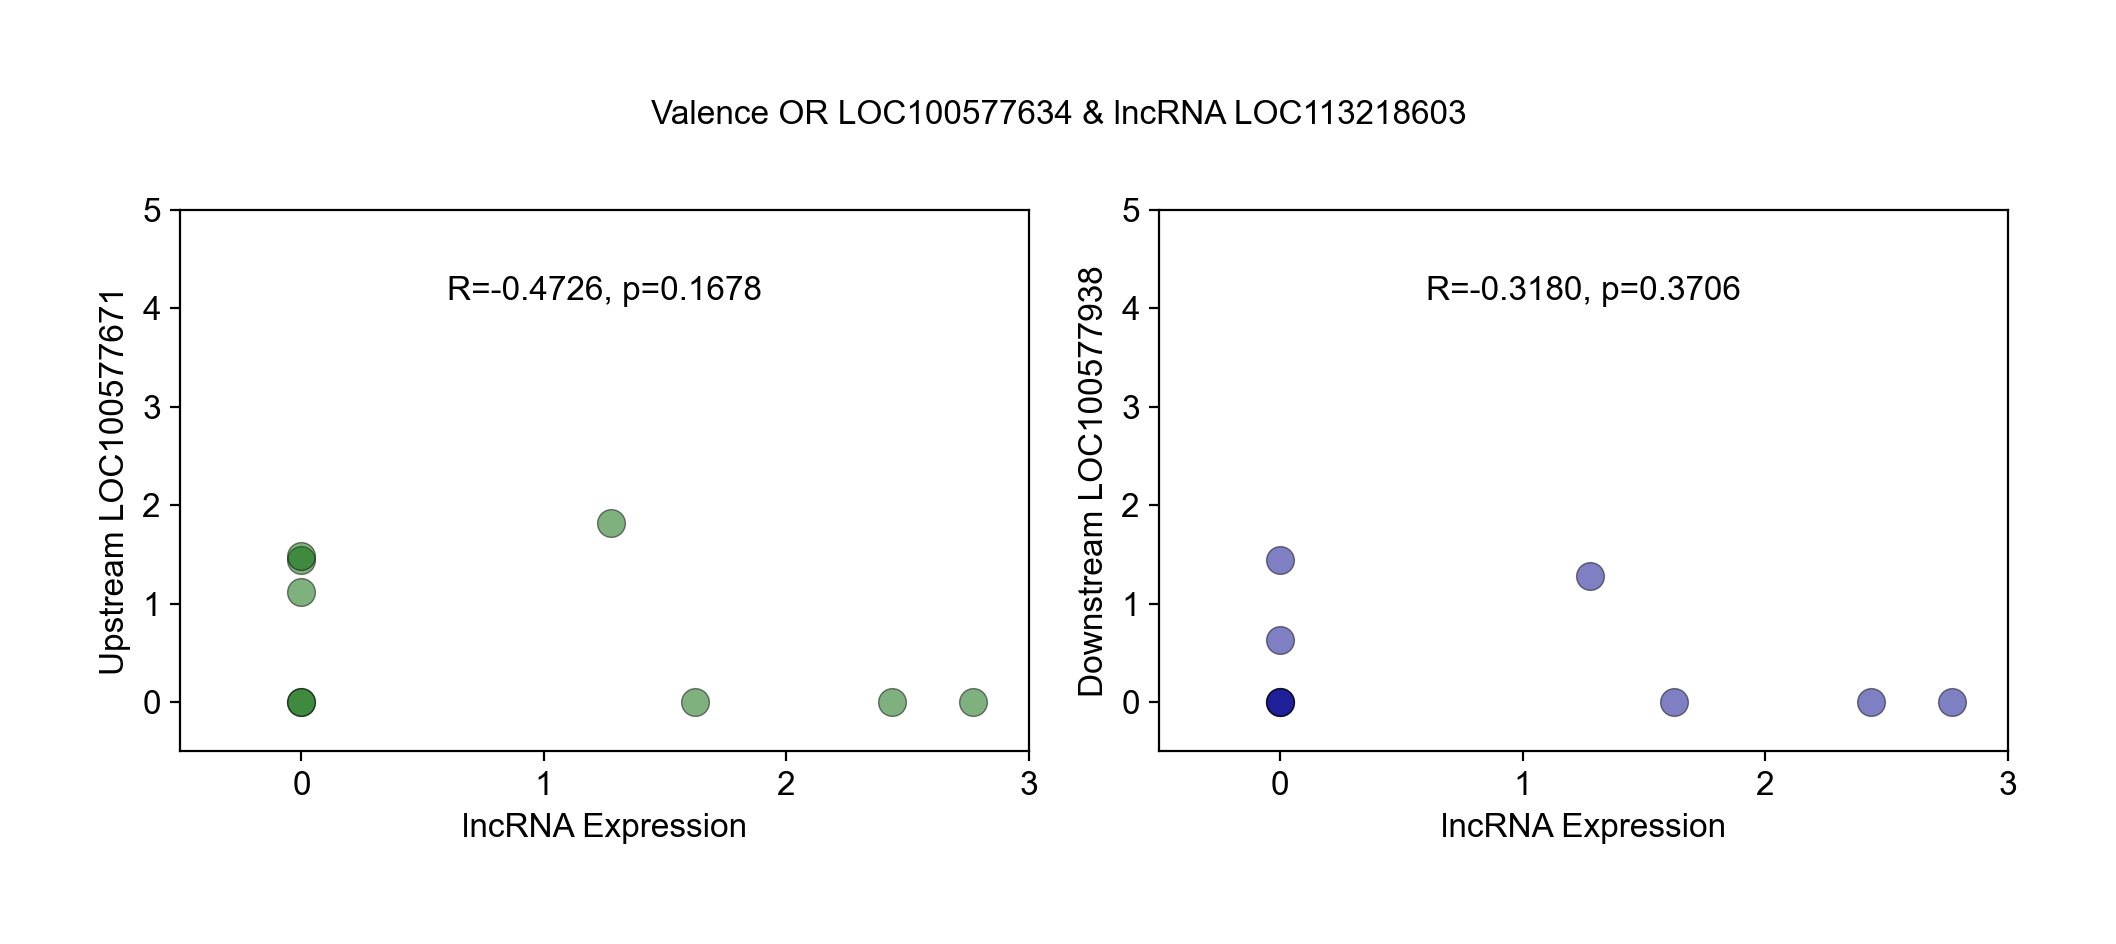

In [97]:
# Plot ustream OR expresion and downstream OR expression vs lncRNA expression bin 
white_plotting()
fontsize=12
f, ax = plt.subplots(1, 2, figsize=(10, 4), sharex=True)
colors = ['darkgreen', 'darkblue']
for i, OR in enumerate(['Upstream', 'Downstream']):
    sns.scatterplot(data=cells, x='lncRNA_expression', y=f'{OR.lower()}_OR_expression', ax=ax[i], color=colors[i], s=100, legend=False, lw=0.5, edgecolor='black', alpha=0.5)
    ax[i].set_xlabel('lncRNA Expression', fontsize=fontsize)
    ax[i].set_ylabel(f'{OR} {cells.iloc[0][OR.lower() + "_OR"]}', fontsize=fontsize)
    r, p = pearsonr(cells['lncRNA_expression'], cells[f'{OR.lower()}_OR_expression'])
    ax[i].text(0.5, 0.85, f'R={r:.4f}, p={p:.4f}', fontsize=fontsize, ha='center', va='center', transform=ax[i].transAxes, color='black')
    ax[i].set_ylim(-0.5, 5)
    ax[i].set_yticks([0, 1, 2, 3, 4, 5])
    ax[i].set_yticklabels(['0', '1', '2', '3', '4', '5'], fontsize=fontsize)
    ax[i].set_xlim(-0.5, 3)
    ax[i].set_xticks([0, 1, 2, 3])
    ax[i].set_xticklabels(['0', '1', '2', '3'], fontsize=fontsize)

plt.suptitle(f"Valence OR {valence_OR} & lncRNA {lncRNA}", fontsize=fontsize)
plt.tight_layout()
plt.show()

## lncRNAs with 3' end close to OR TSS 

In [98]:
min(cell_valence_OR['tss_2_lnc_end']), max(cell_valence_OR['tss_2_lnc_end'])

(145.0, 9387.0)

In [99]:
min(cell_valence_OR['lncRNA_expression']), max(cell_valence_OR['lncRNA_expression'])

(0.0, 3.9374442100524902)

In [100]:
min(cell_valence_OR['upstream_OR_expression']), max(cell_valence_OR['upstream_OR_expression'])

(0.0, 3.6699862480163574)

In [101]:
min(cell_valence_OR['downstream_OR_expression']), max(cell_valence_OR['downstream_OR_expression'])

(0.0, 2.8840818405151367)

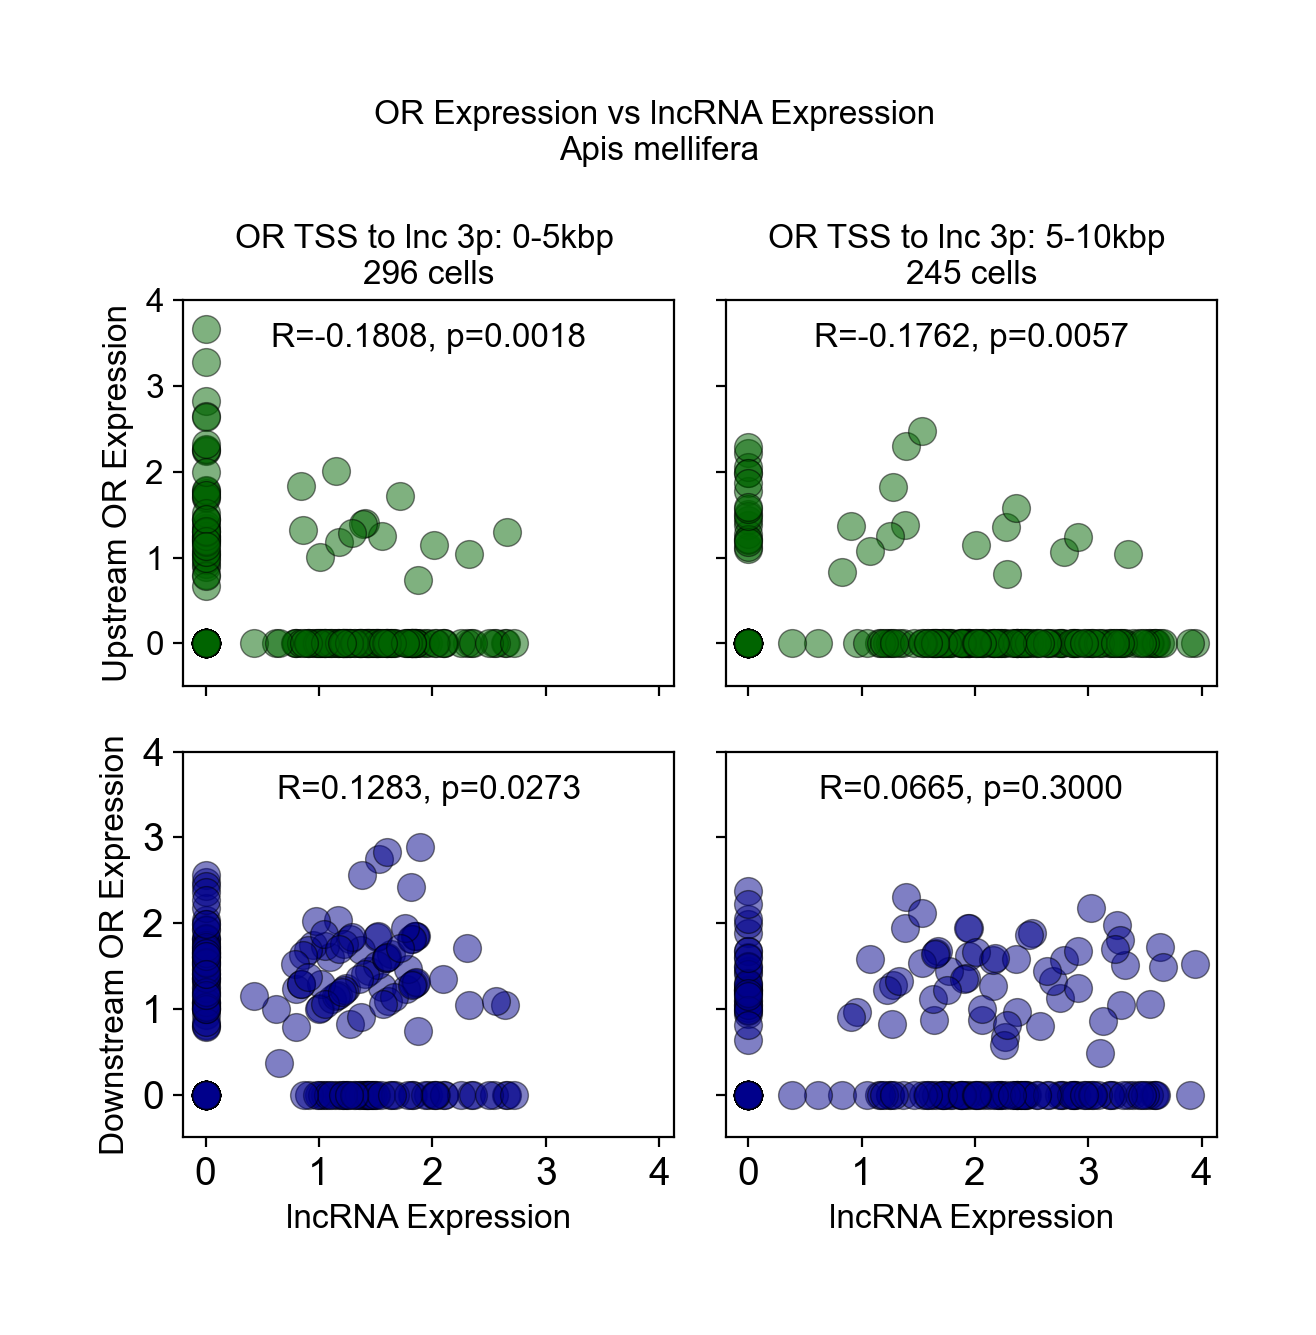

In [102]:
distances = [0, 5000, 10000] 
white_plotting()
fontsize=12
# For each tss_2_lnc_end bin, plot a scatter plot of upstream OR expression vs lncRNA expression
f, ax = plt.subplots(2, len(distances)-1, figsize=(6, 6), sharex=True, sharey=True)
for i in range(len(distances)-1): 
    min_dist = distances[i]
    max_dist = distances[i+1]
    p14_cell_valence_OR_close_bin = cell_valence_OR[(cell_valence_OR['tss_2_lnc_end'] > min_dist) & (cell_valence_OR['tss_2_lnc_end'] < max_dist)]
    
    # Upstream 
    sns.scatterplot(data=p14_cell_valence_OR_close_bin, x='lncRNA_expression', y='upstream_OR_expression', ax=ax[0, i], color='darkgreen', s=100, legend=False, alpha=0.5, lw=0.5, edgecolor='black')
    r, p = pearsonr(p14_cell_valence_OR_close_bin['lncRNA_expression'], p14_cell_valence_OR_close_bin['upstream_OR_expression'])
    ax[0, i].text(0.5, 0.9, f'R={r:.4f}, p={p:.4f}', fontsize=fontsize, ha='center', va='center', transform=ax[0, i].transAxes, color='black')
    ax[0, i].set_ylabel('Upstream OR Expression', fontsize=fontsize)
    ax[0, i].set_title(f'OR TSS to lnc 3p: {int(min_dist/1000)}-{int(max_dist/1000)}kbp \n{p14_cell_valence_OR_close_bin.shape[0]} cells', fontsize=fontsize)
    ax[0, i].set_ylim(-0.5, 4)

    # Downstream 
    sns.scatterplot(data=p14_cell_valence_OR_close_bin, x='lncRNA_expression', y='downstream_OR_expression', ax=ax[1, i], color='darkblue', s=100, legend=False, alpha=0.5, lw=0.5, edgecolor='black')
    r, p = pearsonr(p14_cell_valence_OR_close_bin['lncRNA_expression'], p14_cell_valence_OR_close_bin['downstream_OR_expression'])
    ax[1, i].text(0.5, 0.9, f'R={r:.4f}, p={p:.4f}', fontsize=fontsize, ha='center', va='center', transform=ax[1, i].transAxes, color='black')
    ax[1, i].set_ylabel('Downstream OR Expression', fontsize=fontsize)
    ax[1, i].set_xlabel('lncRNA Expression', fontsize=fontsize)
    ax[0, i].set_yticks([0, 1, 2, 3, 4])
    ax[0, i].set_yticklabels(['0', '1', '2', '3', '4'], fontsize=fontsize)
    # xticks 0 - 6, fontsize
    ax[0, i].set_xticks([0, 1, 2, 3, 4])
    ax[0, i].set_xticklabels(['0', '1', '2', '3', '4'], fontsize=fontsize)

plt.suptitle("OR Expression vs lncRNA Expression \nApis mellifera", fontsize=fontsize)

plt.tight_layout()
plt.show()

In [103]:
# Get unique lncRNAs 
lncRNAs = cell_valence_OR['lncRNA'].unique()

# For each lncRNA, get the Pearson correlation of lncRNA expression vs OR expression for upstream and downstream ORs
results = [] 
for lncRNA in lncRNAs: 
    # Get the valence OR with the smallest tss_2_lnc_end
    closest_valence, tss_2_lnc_end = cell_valence_OR.loc[cell_valence_OR['lncRNA'] == lncRNA].sort_values('tss_2_lnc_end').iloc[0][['valence_OR', 'tss_2_lnc_end']]
    cells = cell_valence_OR[(cell_valence_OR['lncRNA'] == lncRNA) & (cell_valence_OR['valence_OR'] == closest_valence)]
    if cells.shape[0] < 3: 
        # Skip if there are fewer than 3 cells, necessary for Pearson correlation
        continue
    r_up, p_up = pearsonr(cells['lncRNA_expression'], cells[f'upstream_OR_expression'])
    r_down, p_down = pearsonr(cells['lncRNA_expression'], cells[f'downstream_OR_expression'])

    results.append({'lncRNA': lncRNA, 'valence': closest_valence, 'n_cells':cells.shape[0], 'r_up': r_up, 'p_up': p_up, 'r_down': r_down, 'p_down': p_down, 'tss_2_lnc_end': tss_2_lnc_end})

results = pd.DataFrame(results)
results

lncRNA       valence  n_cells      r_up      p_up    r_down  \
0   LOC107966099           Or4       68 -0.012617  0.918662  0.072757   
1   LOC107966089          Or51        6  0.303837  0.558270  0.102365   
2   LOC102656092  LOC100577334       12       NaN       NaN  0.530293   
3   LOC113218588  LOC100576914       11 -0.210330  0.534756 -0.278587   
4   LOC107966088          Or26       16  0.237003  0.376804 -0.016474   
..           ...           ...      ...       ...       ...       ...   
6   LOC113218603  LOC100577671       30 -0.341900  0.064420  0.263557   
7   LOC107966098  LOC102655553        7       NaN       NaN       NaN   
8   LOC107965274  LOC102655180       37 -0.564773  0.000271  0.366017   
9   LOC102656676  LOC100576816       14 -0.268554  0.353217  0.209005   
10  LOC107966100  LOC102655434       10  0.407083  0.242982 -0.103600   

      p_down  tss_2_lnc_end  
0   0.555438         1971.0  
1   0.846989         3087.0  
2   0.076132          145.0  
3   0.406796         1602.0  
4   0.951715         2146.0  
..       ...            ...  
6   0.159355         1407.0  
7        NaN         1530.0  
8   0.025886         1120.0  
9   0.473316         2658.0  
10  0.775792         2770.0  

[11 rows x 8 columns]

In [104]:
# LOC107966098 lncRNA in cell_valence_OR
cell_valence_OR[cell_valence_OR['lncRNA'] == 'LOC107966098']

cell_index    valence_OR valence_OR_tr  tandem_array or_strand  \
11   AAGCATGAGGGTCTAT-1          Or10          Or10            12         +   
12   AAGCGCTGTACAATGT-1           Or9           Or9            12         +   
15   AATCATCCACCCTCAC-1           Or9           Or9            12         +   
64   AGCTAACTCACTCGCT-1           Or9           Or9            12         +   
69   AGGAGCTAGCAAACCT-1          Or10          Or10            12         +   
..                  ...           ...           ...           ...       ...   
491  TGCTTCCAGCCTAATA-1          Or10          Or10            12         +   
505  TGTAAAGCATTGTGGC-1           Or9           Or9            12         +   
528  TTGTTCCCAACACCTA-1          Or10          Or10            12         +   
536  TTTGGCTGTAAAGCAA-1          Or10          Or10            12         +   
537  TTTGGCTGTTAGGCTA-1  LOC102655553  LOC102655553            12         +   

           lncRNA  tss_2_lnc_end  tss2tss lnc_strand  lncRNA_expression  \
11   LOC107966098         9387.0    156.0          -           0.000000   
12   LOC107966098         5577.0  -3654.0          -           2.751090   
15   LOC107966098         5577.0  -3654.0          -           3.286515   
64   LOC107966098         5577.0  -3654.0          -           3.575773   
69   LOC107966098         9387.0    156.0          -           2.690055   
..            ...            ...      ...        ...                ...   
491  LOC107966098         9387.0    156.0          -           2.965609   
505  LOC107966098         5577.0  -3654.0          -           3.278266   
528  LOC107966098         9387.0    156.0          -           3.236924   
536  LOC107966098         9387.0    156.0          -           0.000000   
537  LOC107966098         1530.0  -7701.0          -           2.720489   

     valence_OR_expression   upstream_OR downstream_OR upstream_OR_strand  \
11                2.409184           Or9          Or11                  +   
12                1.985505  LOC102655553          Or10                  +   
15                1.874529  LOC102655553          Or10                  +   
64                2.072473  LOC102655553          Or10                  +   
69                2.223487           Or9          Or11                  +   
..                     ...           ...           ...                ...   
491               1.834021           Or9          Or11                  +   
505               2.622120  LOC102655553          Or10                  +   
528               2.037268           Or9          Or11                  +   
536               1.166710           Or9          Or11                  +   
537               1.213317  LOC102655434           Or9                  +   

    downstream_OR_strand  upstream_OR_expression  downstream_OR_expression  
11                     +                     0.0                  0.000000  
12                     +                     0.0                  1.129543  
15                     +                     0.0                  1.043540  
64                     +                     0.0                  0.000000  
69                     +                     0.0                  1.320822  
..                   ...                     ...                       ...  
491                    +                     0.0                  0.000000  
505                    +                     0.0                  1.809263  
528                    +                     0.0                  1.694959  
536                    +                     0.0                  0.000000  
537                    +                     0.0                  0.000000  

[48 rows x 17 columns]

In [105]:
# drop nan rows 
results = results.dropna().reset_index(drop=True)

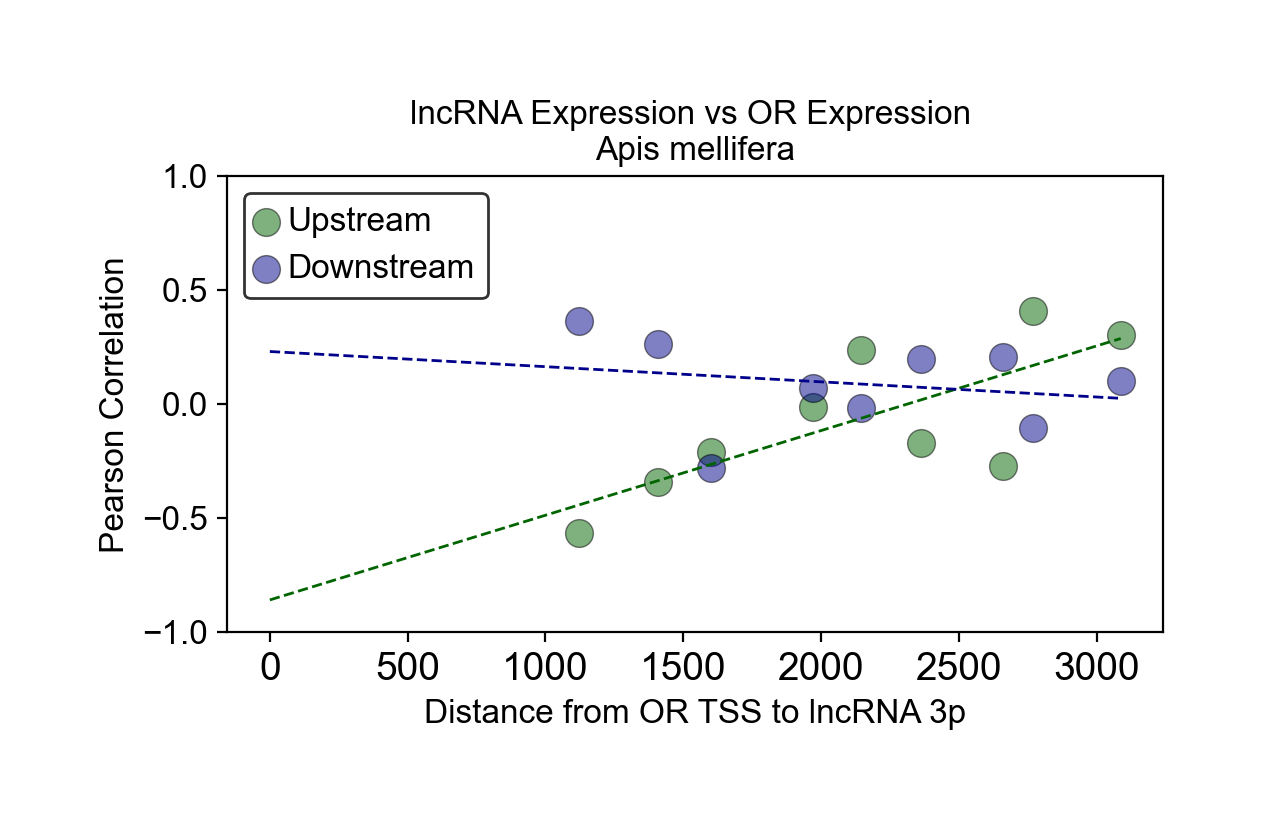

In [106]:
# plot r_up and r_down as a function of tss_2_lnc_end
white_plotting()
fontsize=12
f, ax = plt.subplots(1, 1, figsize=(6, 3), sharey=True)
colors = ['darkgreen', 'darkblue']
sns.scatterplot(data=results, x='tss_2_lnc_end', y='r_up', ax=ax, color='darkgreen', s=100, label='Upstream', alpha=0.5, lw=0.5, edgecolor='black')
sns.scatterplot(data=results, x='tss_2_lnc_end', y='r_down', ax=ax, color='darkblue', s=100, label='Downstream', alpha=0.5, lw=0.5, edgecolor='black')
from scipy.stats import linregress
x = np.linspace(0, np.max(results['tss_2_lnc_end']), 100)
slope, intercept, r_value, p_value, std_err = linregress(results['tss_2_lnc_end'], results['r_up'])
plt.plot(x, slope*x + intercept, color='darkgreen', linestyle='--', lw=1) 
slope, intercept, r_value, p_value, std_err = linregress(results['tss_2_lnc_end'], results['r_down'])
plt.plot(x, slope*x + intercept, color='darkblue', linestyle='--', lw=1)
ax.set_xlabel('Distance from OR TSS to lncRNA 3p', fontsize=fontsize)
ax.set_ylabel('Pearson Correlation', fontsize=fontsize)
plt.title('lncRNA Expression vs OR Expression \nApis mellifera', fontsize=fontsize)
plt.legend(loc='upper left', fontsize=fontsize)
plt.ylim(-1, 1)
plt.yticks([-1, -0.5, 0, 0.5, 1], fontsize=fontsize)
plt.show()

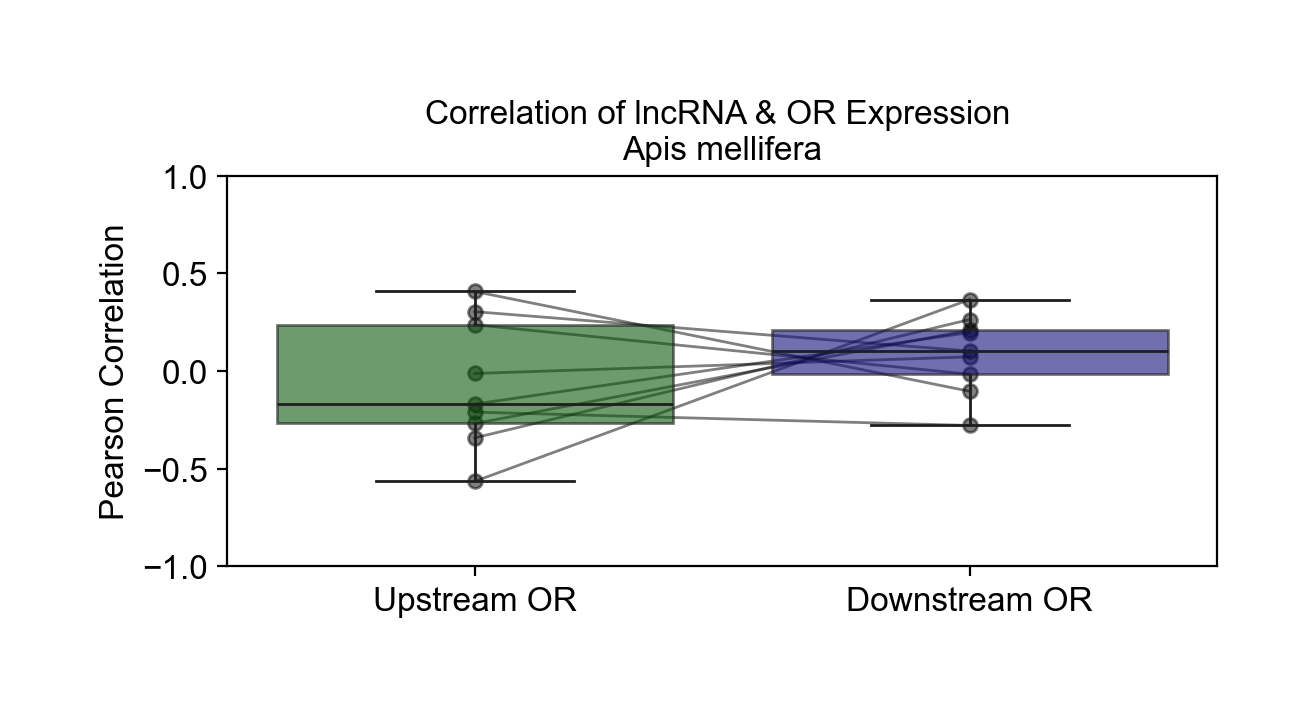

In [107]:
# Plot paired jitter plot of r_up and r_down for each lncRNA
white_plotting()
plt.figure(figsize=(6, 3))
plt.plot([0, 1], [results['r_up'], results['r_down']], color='black', alpha=0.5, marker='o', markersize=5, lw=1)
palette=['darkgreen', 'darkblue']
bx = sns.boxplot(data=results[['r_up', 'r_down']], palette=palette, linewidth=1)
for patch in bx.patches:
    patch.set_alpha(0.6)
plt.xticks([0, 1], ['Upstream OR', 'Downstream OR'], fontsize=12)
plt.ylabel('Pearson Correlation', fontsize=12)
plt.title('Correlation of lncRNA & OR Expression \nApis mellifera', fontsize=12)
plt.ylim(-1, 1)
plt.yticks([-1, -0.5, 0, 0.5, 1], fontsize=12)
plt.tight_layout()
plt.show()

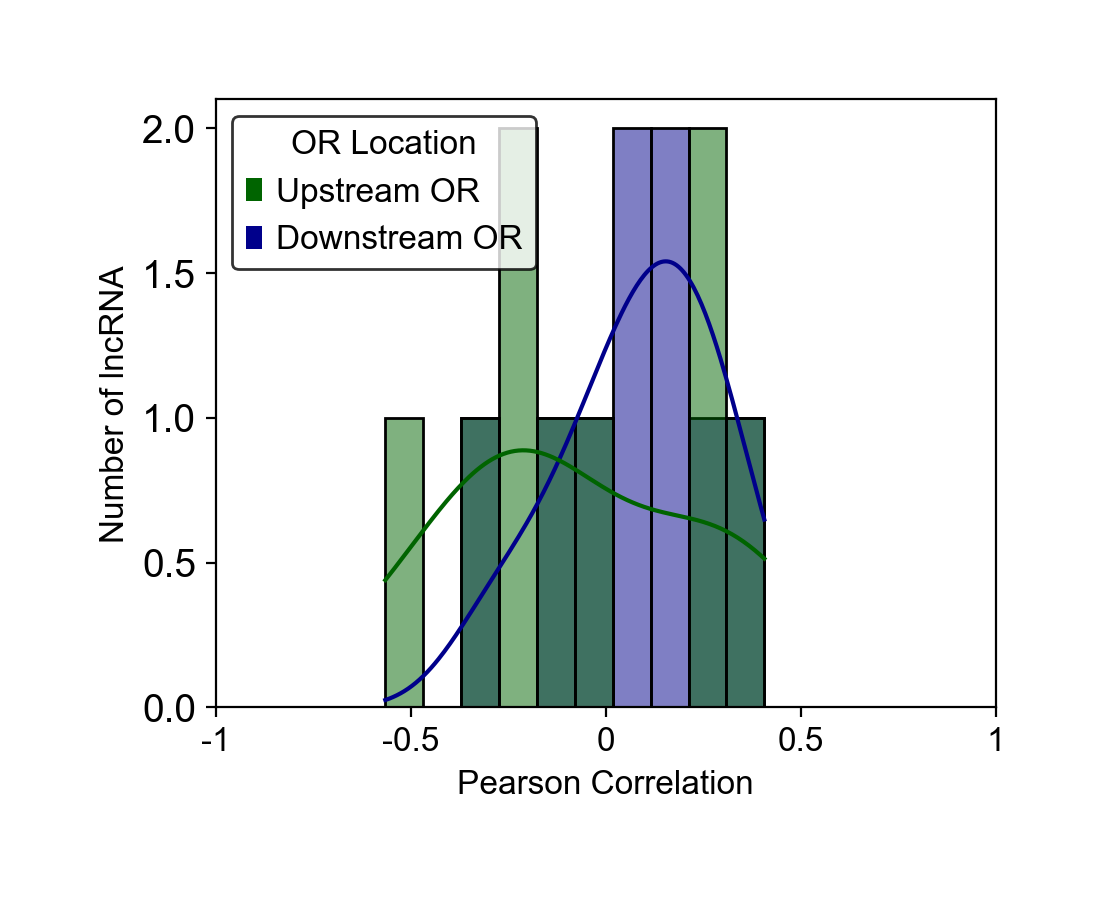

In [108]:
# Plot histograms of r_up and r_down in two subplots 
results_melted = results.melt(id_vars=['lncRNA', 'valence', 'n_cells', 'tss_2_lnc_end'], value_vars=['r_up', 'r_down'], var_name='OR', value_name='r')
white_plotting()
fontsize=12
f, ax = plt.subplots(1, 1, figsize=(5, 4), sharey=True, sharex=True)
colors = ['darkgreen', 'darkblue']
sns.histplot(results_melted, x='r', hue='OR', ax=ax, kde=True, palette=colors, legend=False, bins=10) 
ax.set_xlabel('Pearson Correlation', fontsize=fontsize)
ax.set_ylabel('Number of lncRNA', fontsize=fontsize)
ax.set_xlim(-1, 1)
ax.set_xticks([-1, -0.5, 0, 0.5, 1])
ax.set_xticklabels([-1, -0.5, 0, 0.5, 1], fontsize=fontsize)
plt.bar(0, 0, color='darkgreen', label='Upstream OR')
plt.bar(0, 0, color='darkblue', label='Downstream OR')
plt.legend(title='OR Location', loc='upper left', fontsize=fontsize, title_fontsize=fontsize)

In [109]:
# Get unique valence ORs 
valence_ORs = cell_valence_OR['valence_OR'].unique()

# For each lncRNA, get the Pearson correlation of lncRNA expression vs OR expression for upstream and downstream ORs
results = [] 
for valence_OR in valence_ORs: 
    cells = cell_valence_OR[(cell_valence_OR['valence_OR'] == valence_OR)]
    if cells.shape[0] < 3: 
        continue
    r_up, p_up = pearsonr(cells['lncRNA_expression'], cells[f'upstream_OR_expression'])
    r_down, p_down = pearsonr(cells['lncRNA_expression'], cells[f'downstream_OR_expression'])
    r_valence, p_up = pearsonr(cells['lncRNA_expression'], cells[f'valence_OR_expression'])
    # Get the tss_2_lnc_end for the valence OR
    tss_2_lnc_end = cell_valence_OR.loc[cell_valence_OR['valence_OR'] == valence_OR, 'tss_2_lnc_end'].values[0]
    tss2tss = cell_valence_OR.loc[cell_valence_OR['valence_OR'] == valence_OR, 'tss2tss'].values[0]

    results.append({'valence': valence_OR, 'n_cells':cells.shape[0],  'tss_2_lnc_end': tss_2_lnc_end, 'tss2tss': tss2tss, 
                    'r_up': r_up, 'p_up': p_up, 'r_down': r_down, 'p_down': p_down, 'r_valence': r_valence, 'p_valence': p_up})

results = pd.DataFrame(results)
results = results.dropna().reset_index(drop=True)
results

valence  n_cells  tss_2_lnc_end  tss2tss      r_up      p_up  \
0            Or4       68         1971.0  -8221.0 -0.012617  0.058823   
1           Or51        6         3087.0  -1848.0  0.303837  0.135353   
2   LOC113218533       15         7643.0   5152.0  0.413825  0.097697   
3           Or26       16         2146.0 -10060.0  0.237003  0.517554   
4           Or52       12         5677.0    742.0  0.045593  0.322217   
..           ...      ...            ...      ...       ...       ...   
17  LOC100576881       14         4117.0   1626.0 -0.143451  0.214007   
18  LOC100577634       10         5735.0   1045.0 -0.472551  0.363519   
19  LOC102655434       10         2770.0   -109.0  0.407083  0.035996   
20          Or50       12         7456.0   3879.0 -0.090909  0.599172   
21          Or53        9         8106.0   3171.0  0.529806  0.755050   

      r_down    p_down  r_valence  p_valence  
0   0.072757  0.555438   0.230316   0.058823  
1   0.102365  0.846989  -0.682317   0.135353  
2   0.411080  0.127955   0.443561   0.097697  
3  -0.016474  0.951715  -0.174700   0.517554  
4   0.105318  0.744615   0.312792   0.322217  
..       ...       ...        ...        ...  
17  0.327221  0.253458   0.354231   0.214007  
18 -0.317974  0.370595  -0.322449   0.363519  
19 -0.103600  0.775792   0.664733   0.035996  
20  0.846016  0.000523   0.169167   0.599172  
21 -0.171306  0.659440  -0.121733   0.755050  

[22 rows x 10 columns]

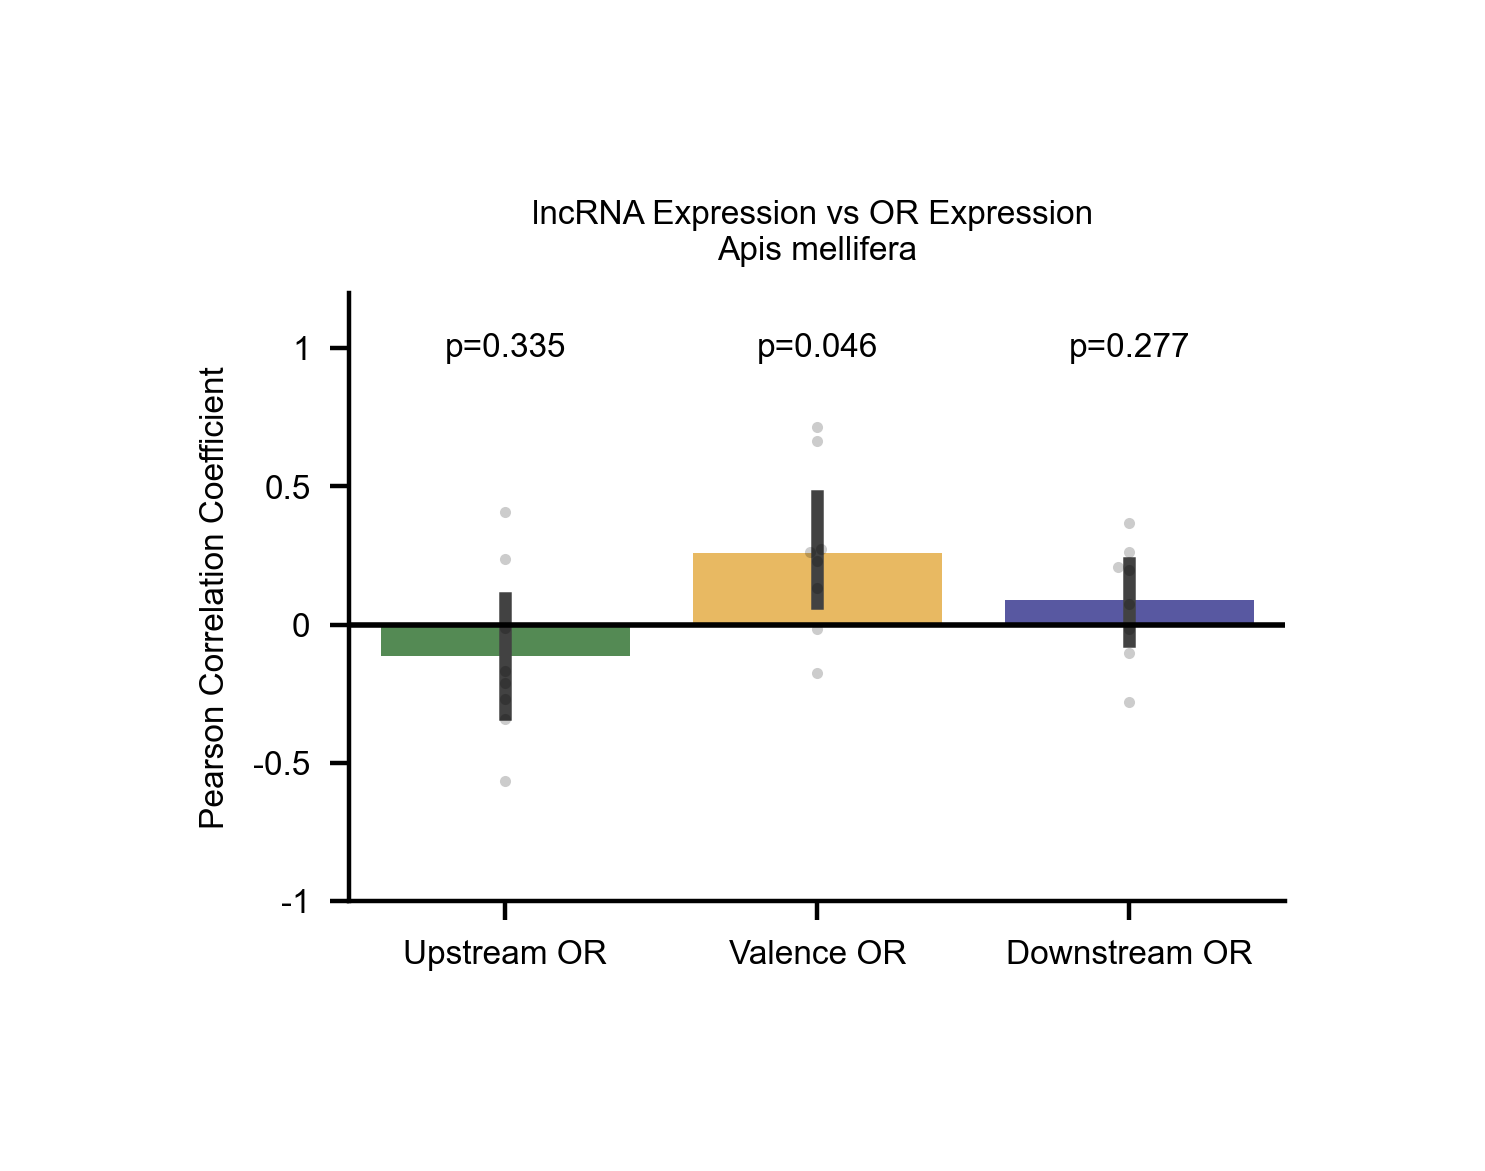

In [110]:
# Plot bar plots of r_up, r_valence and r_down all in the same plot 
max_distance = 3_000 
results_subset = results[results['tss_2_lnc_end'] < max_distance]
white_plotting()
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']
f, ax = plt.subplots(1, 1, figsize=(3, 2), dpi=200)

sns.swarmplot(data=results_subset, x=0, y='r_up', ax=ax, color='black', size=2, alpha=0.2)
sns.swarmplot(data=results_subset, x=1, y='r_valence', ax=ax, color='black', size=2, alpha=0.2)
sns.swarmplot(data=results_subset, x=2, y='r_down', ax=ax, color='black', size=2, alpha=0.2)

sns.barplot(data=results_subset, x=0, y='r_up', ax=ax, color='darkgreen', alpha=0.7, label='Upstream')
sns.barplot(data=results_subset, x=1, y='r_valence', ax=ax, color='orange', alpha=0.7, label='Valence')
sns.barplot(data=results_subset, x=2, y='r_down', ax=ax, color='darkblue', alpha=0.7, label='Downstream')

ax.set_xticks([0, 1, 2], ['Upstream OR', 'Valence OR', 'Downstream OR'], fontsize=6)
ax.set_ylabel('Pearson Correlation Coefficient', fontsize=6)
ax.set_title('lncRNA Expression vs OR Expression \nApis mellifera', fontsize=6)
plt.legend([],[], frameon=False)
ax.set_ylim(-1, 1.2)
ax.set_yticks([-1, -0.5, 0, 0.5, 1], labels=['-1', '-0.5', '0', '0.5', '1'], fontsize=6)
# line at y=0
plt.axhline(0, color='black', lw=1)

# remove spines 
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)


# Add stats (different from 0) 
from scipy.stats import ttest_1samp
for i, or_ in enumerate(['up', 'valence', 'down']):
    r = results_subset[f'r_{or_}']
    t, p = ttest_1samp(r, 0)
    p_value_str = f"p={p:.3f}" if p >= 0.001 else "p<0.001"
    plt.text(i, 1, p_value_str, ha='center', va='center', transform=ax.transData, fontsize=6, color='black')

plt.show()

## Plot correlations for each unique lncRNA

In [111]:
# Get unique lncRNAs 
lncRNAs = cell_valence_OR['lncRNA'].unique()

# For each lncRNA, get the Pearson correlation of lncRNA expression vs OR expression for upstream and downstream ORs
results = [] 
for lncRNA in lncRNAs: 
    # Get the valence OR with the smallest tss_2_lnc_end
    closest_valence, tss_2_lnc_end = cell_valence_OR.loc[cell_valence_OR['lncRNA'] == lncRNA].sort_values('tss_2_lnc_end').iloc[0][['valence_OR', 'tss_2_lnc_end']]
    cells = cell_valence_OR[(cell_valence_OR['lncRNA'] == lncRNA) & (cell_valence_OR['valence_OR'] == closest_valence)]
    if cells.shape[0] < 3: 
        # Skip if there are fewer than 3 cells, necessary for Pearson correlation
        continue
    r_up, p_up = pearsonr(cells['lncRNA_expression'], cells[f'upstream_OR_expression'])
    r_down, p_down = pearsonr(cells['lncRNA_expression'], cells[f'downstream_OR_expression'])
    r_valence, p_up = pearsonr(cells['lncRNA_expression'], cells['valence_OR_expression'])

    tss_2_lnc_end = cells['tss_2_lnc_end'].values[0]
    tss2tss = cells['tss2tss'].values[0]

    results.append({'lncRNA':lncRNA, 'valence': closest_valence, 'n_cells':cells.shape[0],  'tss_2_lnc_end': tss_2_lnc_end, 'tss2tss': tss2tss, 
                    'r_up': r_up, 'p_up': p_up, 'r_down': r_down, 'p_down': p_down, 'r_valence': r_valence, 'p_valence': p_up})

results = pd.DataFrame(results)
results

lncRNA       valence  n_cells  tss_2_lnc_end  tss2tss      r_up  \
0   LOC107966099           Or4       68         1971.0  -8221.0 -0.012617   
1   LOC107966089          Or51        6         3087.0  -1848.0  0.303837   
2   LOC102656092  LOC100577334       12          145.0  -2667.0       NaN   
3   LOC113218588  LOC100576914       11         1602.0   -889.0 -0.210330   
4   LOC107966088          Or26       16         2146.0 -10060.0  0.237003   
..           ...           ...      ...            ...      ...       ...   
6   LOC113218603  LOC100577671       30         1407.0  -3283.0 -0.341900   
7   LOC107966098  LOC102655553        7         1530.0  -7701.0       NaN   
8   LOC107965274  LOC102655180       37         1120.0  -3783.0 -0.564773   
9   LOC102656676  LOC100576816       14         2658.0   -919.0 -0.268554   
10  LOC107966100  LOC102655434       10         2770.0   -109.0  0.407083   

        p_up    r_down    p_down  r_valence  p_valence  
0   0.058823  0.072757  0.555438   0.230316   0.058823  
1   0.135353  0.102365  0.846989  -0.682317   0.135353  
2   0.356058  0.530293  0.076132   0.292594   0.356058  
3   0.418251 -0.278587  0.406796   0.272103   0.418251  
4   0.517554 -0.016474  0.951715  -0.174700   0.517554  
..       ...       ...       ...        ...        ...  
6   0.483707  0.263557  0.159355   0.132946   0.483707  
7   0.208752       NaN       NaN   0.542086   0.208752  
8   0.118395  0.366017  0.025886   0.261202   0.118395  
9   0.004177  0.209005  0.473316   0.713336   0.004177  
10  0.035996 -0.103600  0.775792   0.664733   0.035996  

[11 rows x 11 columns]

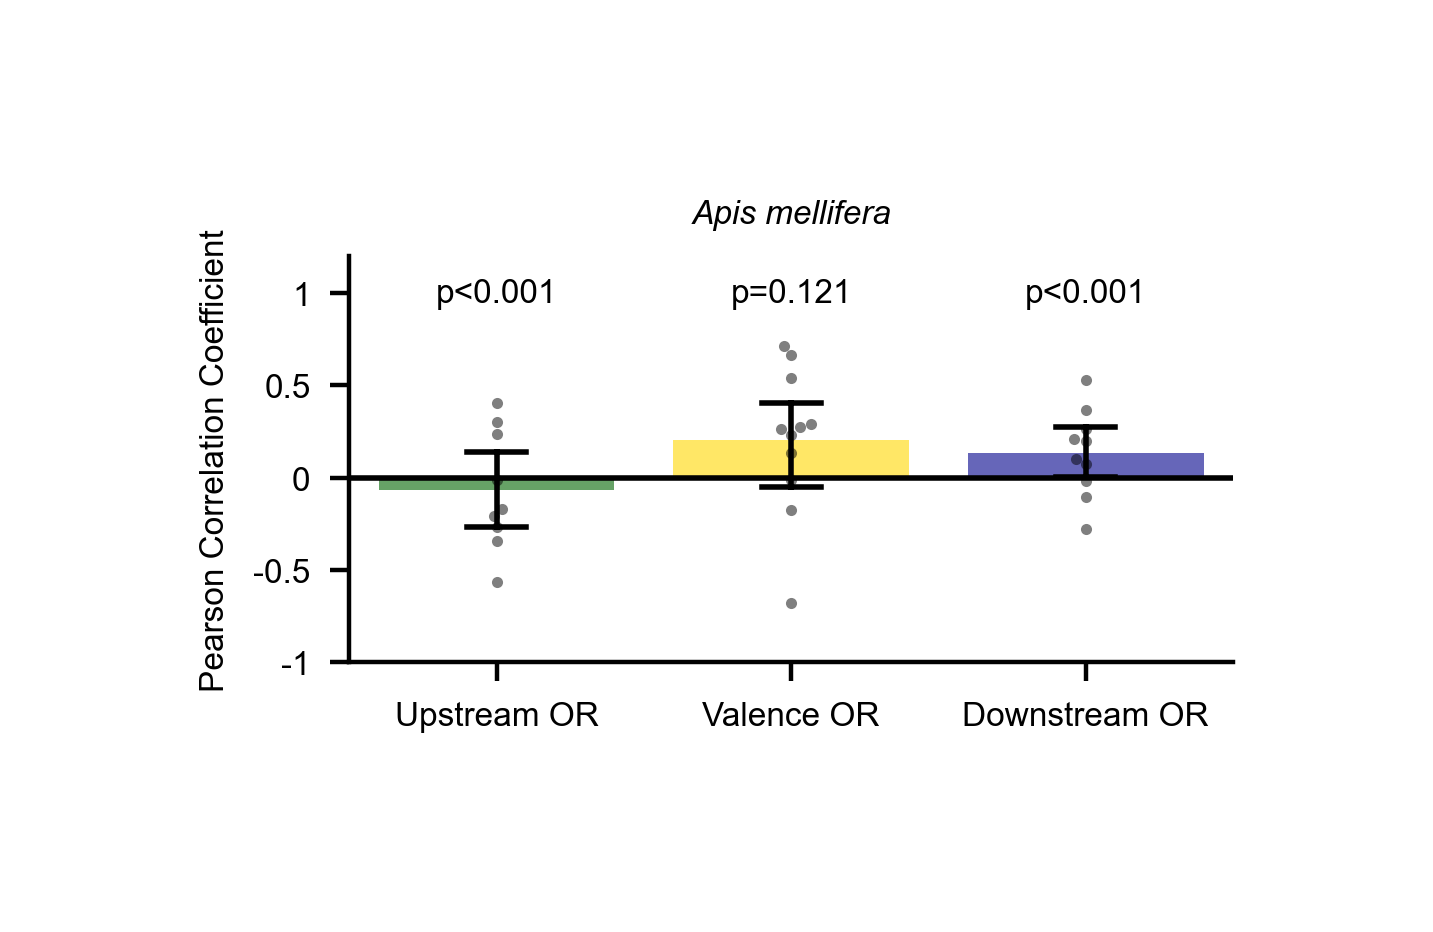

In [117]:
# Plot bar plot of unique lncRNAs with closest valence OR, r_up, r_valence, r_down
max_distance = 5_000 
results_subset = results[(results['tss_2_lnc_end'] < max_distance) & (results['tss_2_lnc_end'] > 0)]
white_plotting()
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']
f, ax = plt.subplots(1, 1, figsize=(3, 1.75), dpi=200)

sns.barplot(data=results_subset, x=0, y='r_up', ax=ax, color='darkgreen', alpha=0.6, label='Upstream', saturation=1, errcolor='black', capsize=0.2, errwidth=1)
sns.barplot(data=results_subset, x=1, y='r_valence', ax=ax, color='gold', alpha=0.6, label='Valence', saturation=1, errcolor='black', capsize=0.2, errwidth=1)
sns.barplot(data=results_subset, x=2, y='r_down', ax=ax, color='darkblue', alpha=0.6, label='Downstream', saturation=1, errcolor='black', capsize=0.2, errwidth=1)

sns.swarmplot(data=results_subset, x=0, y='r_up', ax=ax, color='black', size=2, alpha=0.5)
sns.swarmplot(data=results_subset, x=1, y='r_valence', ax=ax, color='black', size=2, alpha=0.5)
sns.swarmplot(data=results_subset, x=2, y='r_down', ax=ax, color='black', size=2, alpha=0.5)

ax.set_xticks([0, 1, 2], ['Upstream OR', 'Valence OR', 'Downstream OR'], fontsize=6)
ax.set_ylabel('Pearson Correlation Coefficient', fontsize=6)
ax.set_title('Apis mellifera', fontsize=6, style='italic')
plt.legend([],[], frameon=False)
ax.set_ylim(-1, 1.2)
ax.set_yticks([-1, -0.5, 0, 0.5, 1], labels=['-1', '-0.5', '0', '0.5', '1'], fontsize=6)
# line at y=0
plt.axhline(0, color='black', lw=1)

# remove spines 
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)


# Add stats (different from 0) 
from scipy.stats import ttest_1samp
for i, or_ in enumerate(['up', 'valence', 'down']):
    r = results_subset[f'r_{or_}']
    t, p = ttest_1samp(r, 0)
    p_value_str = f"p={p:.3f}" if p >= 0.001 else "p<0.001"
    plt.text(i, 1, p_value_str, ha='center', va='center', transform=ax.transData, fontsize=6, color='black')

plt.tight_layout()
plt.savefig(f"/Users/giacomo.glotzer/Desktop/Rockefeller/Kronauer/lncRNA Paper/figure_pdfs/Amell-lnc-inhibits-correlations.pdf", format="pdf", pad_inches=0, bbox_inches=0, transparent=False)
plt.show()

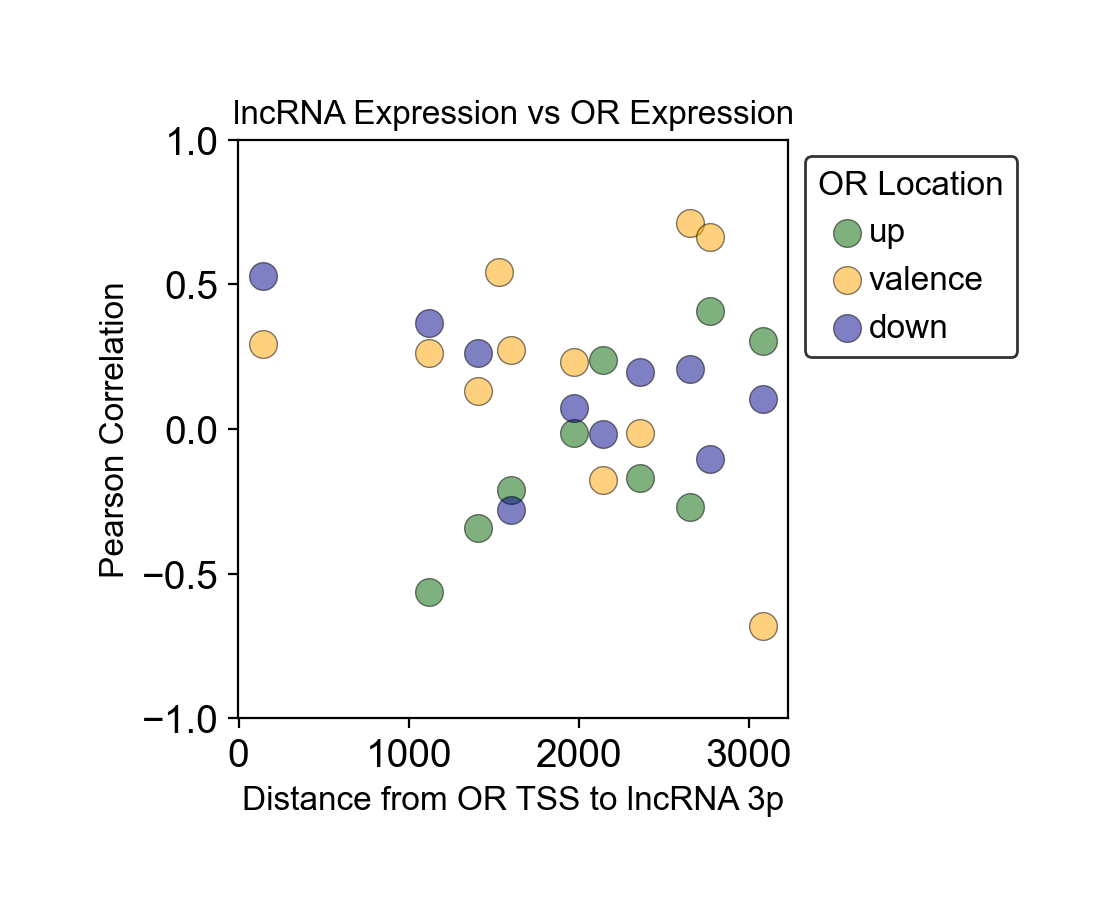

In [113]:
# Plot scatters of r_up, r_valence, r_down vs tss_2_lnc_end
white_plotting()
fontsize=12
f, ax = plt.subplots(1, 1, figsize=(5, 4))
colors = ['darkgreen', 'orange', 'darkblue']
for i, OR in enumerate(['up', 'valence', 'down']):
    sns.scatterplot(data=results, x='tss_2_lnc_end', y=f'r_{OR}', ax=ax, color=colors[i], s=100, label=OR, alpha=0.5, lw=0.5, edgecolor='black')
    ax.set_xlabel('Distance from OR TSS to lncRNA 3p', fontsize=fontsize)
    ax.set_ylabel('Pearson Correlation', fontsize=fontsize)
    ax.set_title('lncRNA Expression vs OR Expression', fontsize=fontsize)
    ax.set_ylim(-1, 1)

# legend outside 
plt.legend(title='OR Location', loc='upper left', fontsize=fontsize, title_fontsize=fontsize, bbox_to_anchor=(1, 1))
plt.tight_layout()

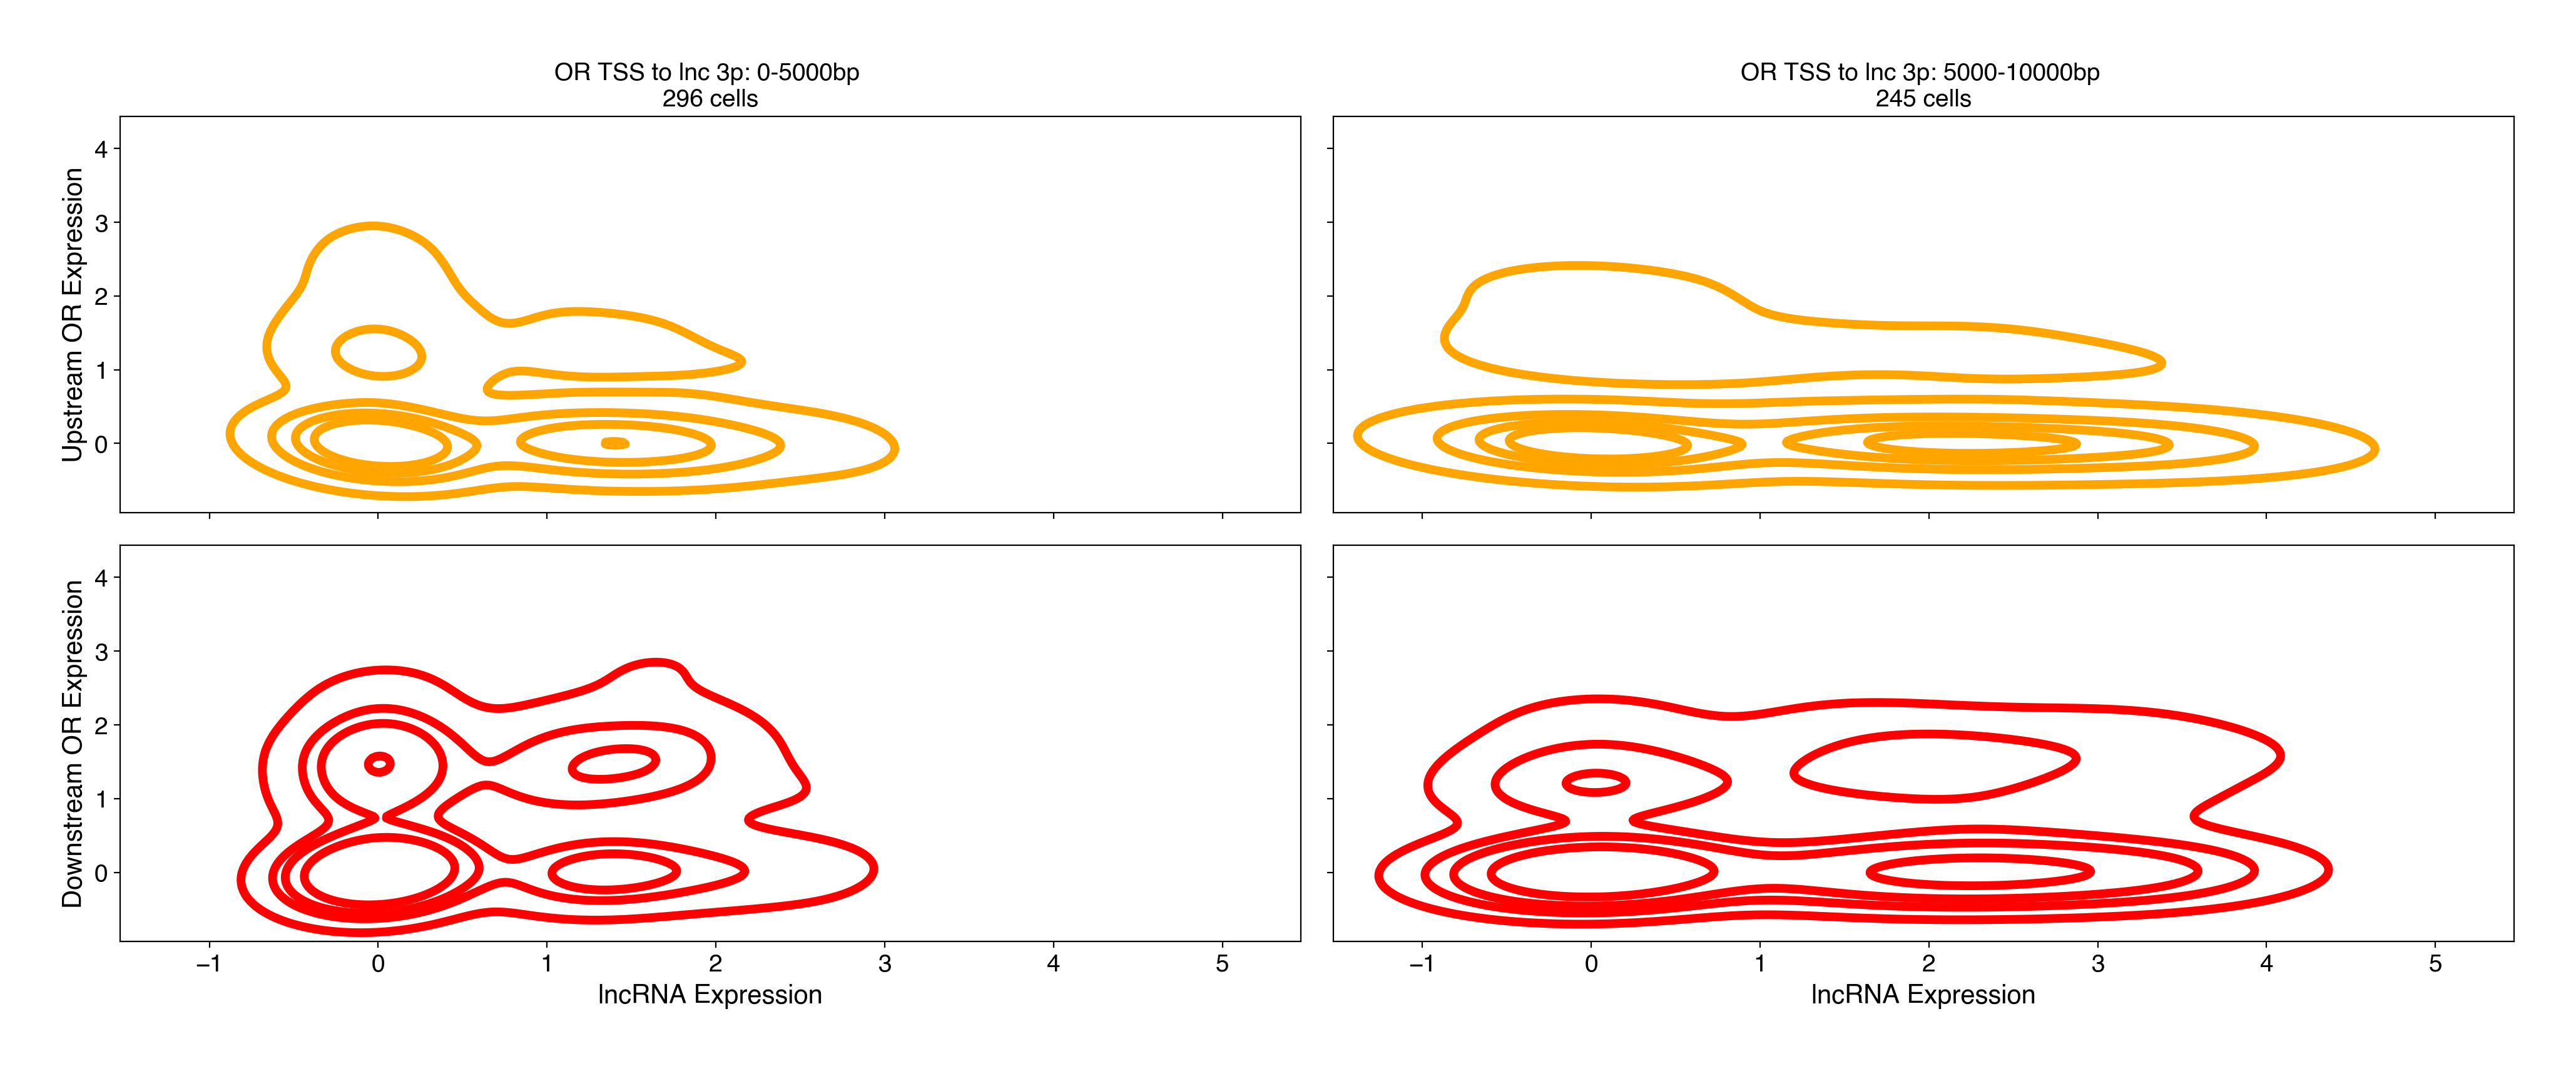

In [116]:
distances = [0, 5000, 10000] 
# For each tss_2_lnc_end bin, plot a scatter plot of upstream OR expression vs lncRNA expression
f, ax = plt.subplots(2, len(distances)-1, figsize=(20, 8), sharex=True, sharey=True)
for i in range(len(distances)-1): 
    min_dist = distances[i]
    max_dist = distances[i+1]
    cell_valence_OR_bin = cell_valence_OR[(cell_valence_OR['tss_2_lnc_end'] > min_dist) & (cell_valence_OR['tss_2_lnc_end'] < max_dist)]
    
    # Upstream 
    sns.kdeplot(data=cell_valence_OR_bin, x='lncRNA_expression', y='upstream_OR_expression', ax=ax[0, i], color='orange', levels=5, linewidths=5)
    r, p = pearsonr(cell_valence_OR_bin['lncRNA_expression'], cell_valence_OR_bin['upstream_OR_expression'])
    ax[0, i].text(0.4, 0.9, f'R={r:.4f}, p={p:.4f}', fontsize=12, ha='center', va='center', transform=ax[0, i].transAxes, color='white')
    ax[0, i].set_ylabel('Upstream OR Expression', fontsize=15)
    ax[0, i].set_title(f'OR TSS to lnc 3p: {min_dist}-{max_dist}bp \n{cell_valence_OR_bin.shape[0]} cells')

    # Downstream 
    sns.kdeplot(data=cell_valence_OR_bin, x='lncRNA_expression', y='downstream_OR_expression', ax=ax[1, i], color='red', levels=5, linewidths=5)
    r, p = pearsonr(cell_valence_OR_bin['lncRNA_expression'], cell_valence_OR_bin['downstream_OR_expression'])
    ax[1, i].text(0.4, 0.9, f'R={r:.4f}, p={p:.4f}', fontsize=12, ha='center', va='center', transform=ax[1, i].transAxes, color='white')
    ax[1, i].set_ylabel('Downstream OR Expression', fontsize=15)
    ax[1, i].set_xlabel('lncRNA Expression', fontsize=15)

plt.tight_layout()
plt.show()

# Split by Upstream > Downstream 

In [117]:
# upstream vs downstream? 
cell_valence_OR['upstream_or_downstream'] = cell_valence_OR.apply(lambda x: 'upstream' if x['upstream_OR_expression'] > x['downstream_OR_expression'] else 'downstream', axis=1)
upstream_vs_downstream_counts = cell_valence_OR['upstream_or_downstream'].value_counts()
upstream_vs_downstream_counts

upstream_or_downstream
downstream    482
upstream       59
Name: count, dtype: int64

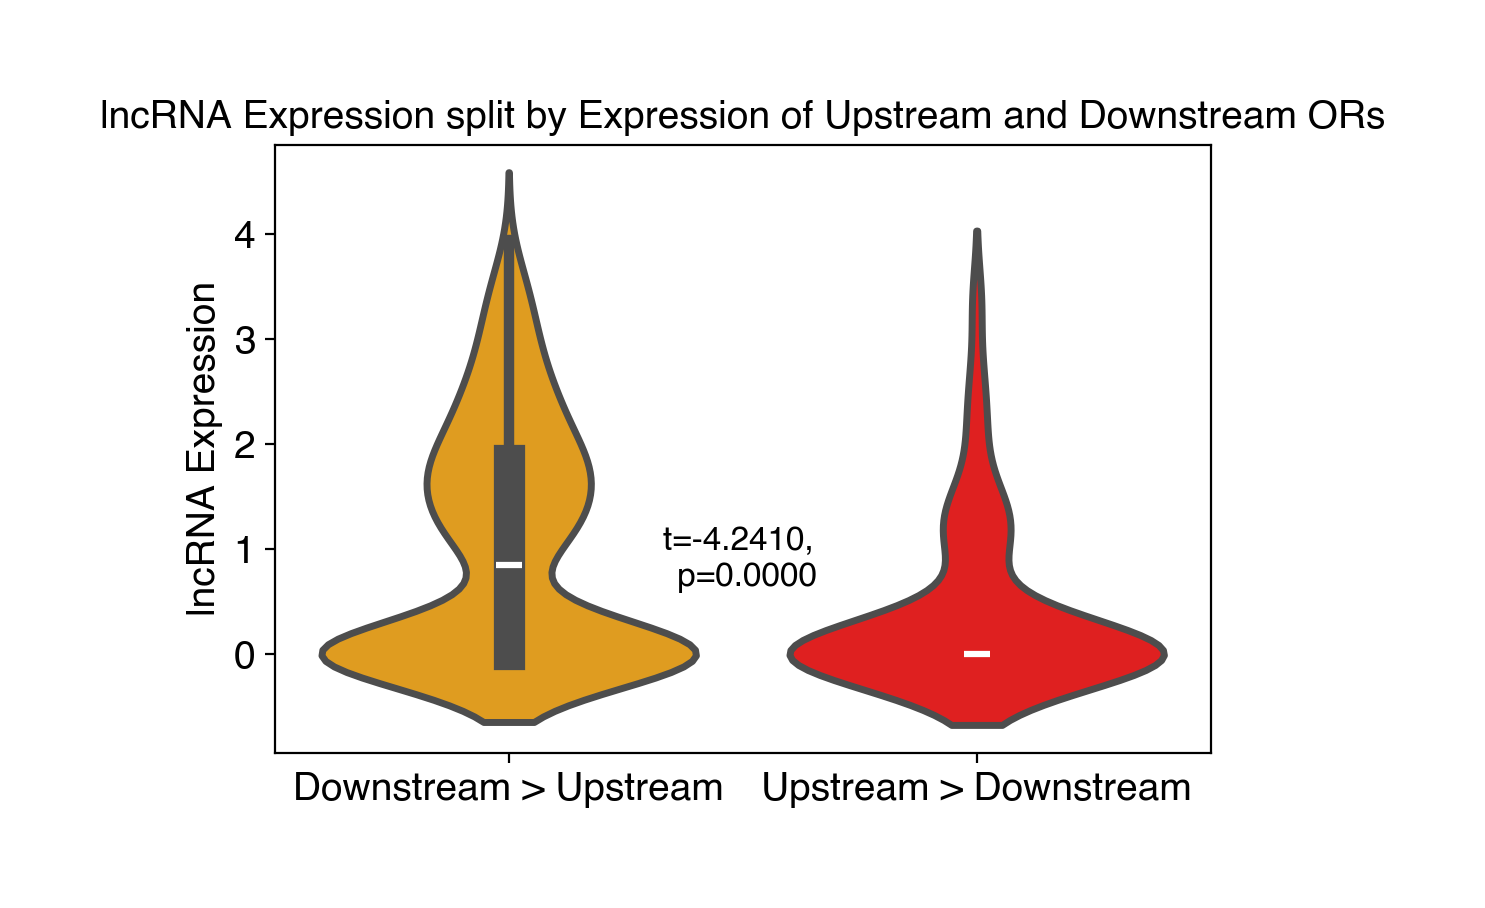

In [118]:
# violin plot lncRNA expression split by upstream and downstream OR expression
plt.figure(figsize=(6, 4))
sns.violinplot(data=cell_valence_OR, x='upstream_or_downstream', y='lncRNA_expression', palette=['orange', 'red'], linewidth=2.5)
plt.xticks([0, 1], ['Downstream > Upstream', 'Upstream > Downstream'])
plt.xlabel('')
plt.ylabel('lncRNA Expression')
plt.title('lncRNA Expression split by Expression of Upstream and Downstream ORs')
# Get p-value for difference in lncRNA expression between upstream and downstream
from scipy.stats import ttest_ind
t_statistic, pvalue = ttest_ind(cell_valence_OR[cell_valence_OR['upstream_or_downstream'] == 'upstream']['lncRNA_expression'], cell_valence_OR[cell_valence_OR['upstream_or_downstream'] == 'downstream']['lncRNA_expression'])
plt.text(0.5, 0.9, f't={t_statistic:.4f}, \n p={pvalue:.4f}', fontsize=12, ha='center', va='center')
plt.show()